<a href="https://colab.research.google.com/github/AlexanderPetrovGH/COMP400/blob/main/Comp400_April24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Hello Comp400")



Mounted at /content/drive
hello my friend how are you


In [2]:
import time
start_time = time.time()

#@title Plotting helpers

def plot_density(data_frame, variable, breakdown_by=None, show=False):
  
  sns.kdeplot(data=data_frame, x=variable, hue=breakdown_by)
  if show: plt.show()

def histogram(data_frame, variable, breakdown_by=None, show=False):

  sns.barplot(data=data_frame, x=variable, hue=breakdown_by)
  if show:
    plt.show()

def plot_correlation_matrix(data_frame, variables, show=False):

  sns.heatmap(data_frame[variables].corr(method="spearman"))
  if show: plt.show()

def compare_correlation_matrix(data_frame_a, data_frame_b, variables, show=False):

  diff = np.abs(data_frame_a[variables].corr(method="spearman") - data_frame_b[variables].corr(method="spearman"))
  print(np.sum(np.sum(diff)))
  sns.heatmap(diff, cmap="rocket_r", vmin=0, vmax=1)
  if show: plt.show()


# this is me
def return_sum(data_frame_a, data_frame_b, variables, show=False):
  diff = np.abs(data_frame_a[variables].corr(method="spearman") - data_frame_b[variables].corr(method="spearman"))
  return np.sum(np.sum(diff))

def compare_density(data_frame_a, data_frame_b, variable, title, show=False):

  vals_a = data_frame_a[variable].values
  vals_b = data_frame_b[variable].values
   
  
  if len(vals_a) > len(vals_b):
    vals_a = np.random.choice(vals_a, len(vals_b))
  elif len(vals_b) > len(vals_a):
    vals_b = np.random.choice(vals_b, len(vals_a))

  
  data_frame = pd.DataFrame(np.hstack([vals_a,vals_b]),columns=[variable])
  
  data_frame.at[:,'dataset'] = 'synthetic'


  # we changed this to .loc, instead of .at, else we get error
  data_frame.loc[0:len(vals_a), 'dataset'] = 'original'

  sns.kdeplot(data=data_frame, x=variable, hue='dataset').set_title(title + ' density')
  if show: plt.show()



def compare_mass(data_frame_a, data_frame_b, variable, title, show=False):

  vals_a = data_frame_a[variable].values
  vals_b = data_frame_b[variable].values
   
  
  if len(vals_a) > len(vals_b):
    vals_a = np.random.choice(vals_a, len(vals_b))
  elif len(vals_b) > len(vals_a):
    vals_b = np.random.choice(vals_b, len(vals_a))

  
  data_frame = pd.DataFrame(np.hstack([vals_a,vals_b]),columns=[variable])
  
  data_frame.at[:,'dataset'] = 'synthetic'


  # we changed this to .loc, instead of .at, else we get error
  data_frame.loc[0:len(vals_a), 'dataset'] = 'original'

  sns.histplot(data=data_frame, x=variable, hue='dataset').set_title(title + ' histogram')
  if show: 
    plt.show()





In [3]:
# @title Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [4]:
#@title DataFrameTransformer

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from collections import defaultdict
from typing import Hashable
from random import randrange

class DataFrameTransformer():
  # attributes of this class:
  # df, the data frame
  # dtypes, the data types involved in the data frame(e.g. float, int, datetime, string)
  # numerical_features
  # categorical_features
  # numerical transformer
  # onehot_columns

  def __init__(self, df, numerical_features, categorical_features):
    self.dtypes = df.dtypes
    self.df = df.copy()

    self.numerical_features = numerical_features
    self.categorical_features = categorical_features
    
    self.transform_numerical()
    self.transform_categorical()
    self.df.reset_index()

  def transform_numerical(self):
    # quantile transformer takes data and makes it more smooth and more like a distribution we know and love
    # in this case, since there is no parameter specifying this, it is unifrom distribition
  # Recall the the Probability Integral Transformation:
  # If a random variable X has a continuous distribution function F, 
  # then the random variable Y:=F(X) has the distribution function of U(0,1).

    self.numerical_transformer = QuantileTransformer(n_quantiles=50, output_distribution="uniform") # we create the object which shall perform the probability transform
    self.df[self.numerical_features] = self.numerical_transformer.fit_transform(
        self.df[self.numerical_features])    # we apply the transform onto the numerical features and update them as such

  def transform_categorical(self):

    onehot_columns = []
    for column in self.categorical_features:
      dummies = pd.get_dummies(self.df[column].astype(int), prefix=column, prefix_sep='-')
      onehot_columns = onehot_columns + list(dummies.columns)
      self.df = pd.concat([self.df, dummies], axis=1).drop([column],axis=1)

    self.onehot_columns = onehot_columns

  def untransform(self, df, default_category={}):

    categorical_df = self.from_dummies(df[self.onehot_columns], sep='-', default_category=default_category)
    numerical_data = self.numerical_transformer.inverse_transform(df[self.numerical_features])    # we undo the transform via the inverse transform
    numerical_df = pd.DataFrame(numerical_data, columns=self.numerical_features)

    merged_columns = list(numerical_df.columns) + list(categorical_df.columns)    
    categorical_df = categorical_df.transpose().reset_index(drop=True).transpose()
    numerical_df = numerical_df.transpose().reset_index(drop=True).transpose()

    df_merged = np.concatenate([numerical_df.values, categorical_df.values], axis=1)  
    df_merged = pd.DataFrame(df_merged, columns=merged_columns)
   
    for column in df_merged.columns:
      df_merged[column] = df_merged[column].astype(self.dtypes[column])
      
    return df_merged

  def get_num_classes_by_categorical_feature(self):

    return np.asarray([2 for c in self.onehot_columns]) # why 2? -> because "1 and 0"

  def get_num_numerical_features(self):
    return len(self.numerical_features)

  def from_dummies(self, data, sep='_', default_category=None):
    # reverses the 1hot encoding basically (?)
    from pandas.core.reshape.concat import concat

    # 'data' parameter must be a data frame! else -> error
    if not isinstance(data, pd.DataFrame):
        raise TypeError(
            "Expected 'data' to be a 'DataFrame'; "
            f"Received 'data' of type: {type(data).__name__}"
        )

    # will raise error if some of the data is missing or problematic (e.g NA or NaN)
    if data.isna().any().any():
        raise ValueError(
            "Dummy DataFrame contains NA value in column: "
            f"'{data.isna().any().idxmax()}'"
        )

    # index data with a list of all columns that are dummies
    try:
        data_to_decode = data.astype("boolean", copy=False)
    except TypeError:
        raise TypeError("Passed DataFrame contains non-dummy data")

    # collect prefixes and get lists to slice data for each prefix
    variables_slice = defaultdict(list)
    for col in data_to_decode.columns:
        prefix = col.split(sep)[0]
        if len(prefix) == len(col):
            raise ValueError(f"Separator not specified for column: {col}")
        variables_slice[prefix].append(col)
    
    if not len(default_category) == len(variables_slice):
        len_msg = (
            f"Length of 'default_category' ({len(default_category)}) "
            f"did not match the length of the columns being encoded "
            f"({len(variables_slice)})"
        )
        raise ValueError(len_msg)
    
    cat_data = {}
    for prefix, prefix_slice in variables_slice.items():
        cats = [col[len(prefix + sep) :] for col in prefix_slice]    
        assigned = data_to_decode.loc[:, prefix_slice].sum(axis=1)
        data_slice = data_to_decode.loc[:, prefix_slice].to_numpy()

        for j in range(0, data_slice.shape[0]):
          # if np.sum(data_slice[j, :]) == 1: continue    --> I've removed this line, because I don't think it's necessary
          if np.sum(data_slice[j, :]) == 0:
            cat = default_category[prefix]
          else:
            cat = int(randrange(0,len(cats)))
          for i in range(0, len(cats)): 
            data_slice[j, i] = (i == cat)

        cats_array = np.array(cats, dtype="object")
        # get indices of True entries along axis=1
        cat_data[prefix] = cats_array[data_slice.nonzero()[1]]

    return pd.DataFrame(cat_data)

In [5]:
#@title TabDPPM: MLP Components

"""
Code was adapted from https://github.com/Yura52/rtdl
"""

import math
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union, cast

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch import Tensor

ModuleType = Union[str, Callable[..., nn.Module]]

class SiLU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

def _is_glu_activation(activation: ModuleType):
    return (
        isinstance(activation, str)
        and activation.endswith('GLU')
        or activation in [ReGLU, GEGLU]
    )


def _all_or_none(values):
    assert all(x is None for x in values) or all(x is not None for x in values)

def reglu(x: Tensor) -> Tensor:
    """The ReGLU activation function from [1].
    References:
        [1] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)


def geglu(x: Tensor) -> Tensor:
    """The GEGLU activation function from [1].
    References:
        [1] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """
    assert x.shape[-1] % 2 == 0
    a, b = x.chunk(2, dim=-1)
    return a * F.gelu(b)

class ReGLU(nn.Module):
    """The ReGLU activation function from [shazeer2020glu].

    Examples:
        .. testcode::

            module = ReGLU()
            x = torch.randn(3, 4)
            assert module(x).shape == (3, 2)

    References:
        * [shazeer2020glu] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """

    def forward(self, x: Tensor) -> Tensor:
        return reglu(x)


class GEGLU(nn.Module):
    """The GEGLU activation function from [shazeer2020glu].

    Examples:
        .. testcode::

            module = GEGLU()
            x = torch.randn(3, 4)
            assert module(x).shape == (3, 2)

    References:
        * [shazeer2020glu] Noam Shazeer, "GLU Variants Improve Transformer", 2020
    """

    def forward(self, x: Tensor) -> Tensor:
        return geglu(x)

def _make_nn_module(module_type: ModuleType, *args) -> nn.Module:
    return (
        (
            ReGLU()
            if module_type == 'ReGLU'
            else GEGLU()
            if module_type == 'GEGLU'
            else getattr(nn, module_type)(*args)
        )
        if isinstance(module_type, str)
        else module_type(*args)
    )


class MLP(nn.Module):
    """The MLP model used in [gorishniy2021revisiting].

    The following scheme describes the architecture:

    .. code-block:: text

          MLP: (in) -> Block -> ... -> Block -> Linear -> (out)
        Block: (in) -> Linear -> Activation -> Dropout -> (out)

    Examples:
        .. testcode::

            x = torch.randn(4, 2)
            module = MLP.make_baseline(x.shape[1], [3, 5], 0.1, 1)
            assert module(x).shape == (len(x), 1)

    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """

    class Block(nn.Module):
        """The main building block of `MLP`."""

        def __init__(
            self,
            *,
            d_in: int,
            d_out: int,
            bias: bool,
            activation: ModuleType,
            dropout: float,
        ) -> None:
            super().__init__()
            self.linear = nn.Linear(d_in, d_out, bias)
            self.activation = _make_nn_module(activation)
            self.dropout = nn.Dropout(dropout)

        def forward(self, x: Tensor) -> Tensor:
            return self.dropout(self.activation(self.linear(x)))

    def __init__(
        self,
        *,
        d_in: int,
        d_layers: List[int],
        dropouts: Union[float, List[float]],
        activation: Union[str, Callable[[], nn.Module]],
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()
        if isinstance(dropouts, float):
            dropouts = [dropouts] * len(d_layers)
        assert len(d_layers) == len(dropouts)
        assert activation not in ['ReGLU', 'GEGLU']

        self.blocks = nn.ModuleList(
            [
                MLP.Block(
                    d_in=d_layers[i - 1] if i else d_in,
                    d_out=d,
                    bias=True,
                    activation=activation,
                    dropout=dropout,
                )
                for i, (d, dropout) in enumerate(zip(d_layers, dropouts))
            ]
        )
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)

    @classmethod
    def make_baseline(
        cls: Type['MLP'],
        d_in: int,
        d_layers: List[int],
        dropout: float,
        d_out: int,
    ) -> 'MLP':
        """Create a "baseline" `MLP`.

        This variation of MLP was used in [gorishniy2021revisiting]. Features:

        * :code:`Activation` = :code:`ReLU`
        * all linear layers except for the first one and the last one are of the same dimension
        * the dropout rate is the same for all dropout layers

        Args:
            d_in: the input size
            d_layers: the dimensions of the linear layers. If there are more than two
                layers, then all of them except for the first and the last ones must
                have the same dimension. Valid examples: :code:`[]`, :code:`[8]`,
                :code:`[8, 16]`, :code:`[2, 2, 2, 2]`, :code:`[1, 2, 2, 4]`. Invalid
                example: :code:`[1, 2, 3, 4]`.
            dropout: the dropout rate for all hidden layers
            d_out: the output size
        Returns:
            MLP

        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        assert isinstance(dropout, float)
        if len(d_layers) > 2:
            assert len(set(d_layers[1:-1])) == 1, (
                'if d_layers contains more than two elements, then'
                ' all elements except for the first and the last ones must be equal.'
            )
        return MLP(
            d_in=d_in,
            d_layers=d_layers,  # type: ignore
            dropouts=dropout,
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.float()
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        return x


In [6]:
#@title TabDPPM: ResNet Components
class ResNet(nn.Module):
    """The ResNet model used in [gorishniy2021revisiting].
    The following scheme describes the architecture:
    .. code-block:: text
        ResNet: (in) -> Linear -> Block -> ... -> Block -> Head -> (out)
                 |-> Norm -> Linear -> Activation -> Dropout -> Linear -> Dropout ->|
                 |                                                                  |
         Block: (in) ------------------------------------------------------------> Add -> (out)
          Head: (in) -> Norm -> Activation -> Linear -> (out)
    Examples:
        .. testcode::
            x = torch.randn(4, 2)
            module = ResNet.make_baseline(
                d_in=x.shape[1],
                n_blocks=2,
                d_main=3,
                d_hidden=4,
                dropout_first=0.25,
                dropout_second=0.0,
                d_out=1
            )
            assert module(x).shape == (len(x), 1)
    References:
        * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
    """

    class Block(nn.Module):
        """The main building block of `ResNet`."""

        def __init__(
            self,
            *,
            d_main: int,
            d_hidden: int,
            bias_first: bool,
            bias_second: bool,
            dropout_first: float,
            dropout_second: float,
            normalization: ModuleType,
            activation: ModuleType,
            skip_connection: bool,
        ) -> None:
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_main)
            self.linear_first = nn.Linear(d_main, d_hidden, bias_first)
            self.activation = _make_nn_module(activation)
            self.dropout_first = nn.Dropout(dropout_first)
            self.linear_second = nn.Linear(d_hidden, d_main, bias_second)
            self.dropout_second = nn.Dropout(dropout_second)
            self.skip_connection = skip_connection

        def forward(self, x: Tensor) -> Tensor:
            x_input = x
            x = self.normalization(x)
            x = self.linear_first(x)
            x = self.activation(x)
            x = self.dropout_first(x)
            x = self.linear_second(x)
            x = self.dropout_second(x)
            if self.skip_connection:
                x = x_input + x
            return x

    class Head(nn.Module):
        """The final module of `ResNet`."""

        def __init__(
            self,
            *,
            d_in: int,
            d_out: int,
            bias: bool,
            normalization: ModuleType,
            activation: ModuleType,
        ) -> None:
            super().__init__()
            self.normalization = _make_nn_module(normalization, d_in)
            self.activation = _make_nn_module(activation)
            self.linear = nn.Linear(d_in, d_out, bias)

        def forward(self, x: Tensor) -> Tensor:
            if self.normalization is not None:
                x = self.normalization(x)
            x = self.activation(x)
            x = self.linear(x)
            return x

    def __init__(
        self,
        *,
        d_in: int,
        n_blocks: int,
        d_main: int,
        d_hidden: int,
        dropout_first: float,
        dropout_second: float,
        normalization: ModuleType,
        activation: ModuleType,
        d_out: int,
    ) -> None:
        """
        Note:
            `make_baseline` is the recommended constructor.
        """
        super().__init__()

        self.first_layer = nn.Linear(d_in, d_main)
        if d_main is None:
            d_main = d_in
        self.blocks = nn.Sequential(
            *[
                ResNet.Block(
                    d_main=d_main,
                    d_hidden=d_hidden,
                    bias_first=True,
                    bias_second=True,
                    dropout_first=dropout_first,
                    dropout_second=dropout_second,
                    normalization=normalization,
                    activation=activation,
                    skip_connection=True,
                )
                for _ in range(n_blocks)
            ]
        )
        self.head = ResNet.Head(
            d_in=d_main,
            d_out=d_out,
            bias=True,
            normalization=normalization,
            activation=activation,
        )

    @classmethod
    def make_baseline(
        cls: Type['ResNet'],
        *,
        d_in: int,
        n_blocks: int,
        d_main: int,
        d_hidden: int,
        dropout_first: float,
        dropout_second: float,
        d_out: int,
    ) -> 'ResNet':
        """Create a "baseline" `ResNet`.
        This variation of ResNet was used in [gorishniy2021revisiting]. Features:
        * :code:`Activation` = :code:`ReLU`
        * :code:`Norm` = :code:`BatchNorm1d`
        Args:
            d_in: the input size
            n_blocks: the number of Blocks
            d_main: the input size (or, equivalently, the output size) of each Block
            d_hidden: the output size of the first linear layer in each Block
            dropout_first: the dropout rate of the first dropout layer in each Block.
            dropout_second: the dropout rate of the second dropout layer in each Block.
        References:
            * [gorishniy2021revisiting] Yury Gorishniy, Ivan Rubachev, Valentin Khrulkov, Artem Babenko, "Revisiting Deep Learning Models for Tabular Data", 2021
        """
        return cls(
            d_in=d_in,
            n_blocks=n_blocks,
            d_main=d_main,
            d_hidden=d_hidden,
            dropout_first=dropout_first,
            dropout_second=dropout_second,
            normalization='BatchNorm1d',
            activation='ReLU',
            d_out=d_out,
        )

    def forward(self, x: Tensor) -> Tensor:
        x = x.float()
        x = self.first_layer(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

class ResNetDiffusion(nn.Module):
    def __init__(self, d_in, num_classes, is_y_cond, rtdl_params, dim_t = 128, type="resnet"):
        super().__init__()
        self.dim_t = dim_t
        self.num_classes = num_classes
        self.is_y_cond = is_y_cond

        self.mlp = ResNet.make_baseline(**rtdl_params
                # d_in=dim_t,
                # n_blocks=4,
                # d_main=128,
                # d_hidden=256,
                # dropout_first=0.5,
                # dropout_second=0.5,
                # d_out=d_in
            )

        if self.num_classes > 0 and is_y_cond:
            self.label_emb = nn.Embedding(self.num_classes, dim_t)
        elif self.num_classes == 0 and is_y_cond:
            self.label_emb = nn.Linear(1, dim_t)
        
        self.proj = nn.Linear(d_in, dim_t)
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )
    
    def forward(self, x, timesteps, y=None):
        emb = self.time_embed(timestep_embedding(timesteps, self.dim_t))
        if self.is_y_cond and y is not None:
            if self.num_classes > 0:
                y = y.squeeze()
            else:
                y = y.resize(y.size(0), 1).float()
            emb += F.silu(self.label_emb(y))
        x = self.proj(x) + emb
        return self.mlp(x)

class MLPDiffusion(nn.Module):

    def __init__(self, d_in, num_classes, is_y_cond, rtdl_params, dim_t = 128, type="mlp"):
        super().__init__()
        self.dim_t = dim_t
        self.num_classes = num_classes
        self.is_y_cond = is_y_cond

        #d0 = rtdl_params['d_layers'][0]

        rtdl_params['d_in'] = dim_t
        rtdl_params['d_out'] = d_in

        self.mlp = MLP.make_baseline(**rtdl_params)

        if self.num_classes > 0 and is_y_cond:
            self.label_emb = nn.Embedding(self.num_classes, dim_t)
        elif self.num_classes == 0 and is_y_cond:
            self.label_emb = nn.Linear(1, dim_t)
        
        self.proj = nn.Linear(d_in, dim_t)
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )
    
    def forward(self, x, timesteps, y=None):
        emb = self.time_embed(timestep_embedding(timesteps, self.dim_t))
        if self.is_y_cond and y is not None:
            if self.num_classes > 0:
                y = y.squeeze()
            else:
                y = y.resize(y.size(0), 1).float()
            emb += F.silu(self.label_emb(y))
        x = self.proj(x) + emb
        return self.mlp(x)


In [7]:
#@title TabDPPM: dataset loading helpers

import hashlib
from collections import Counter
from copy import deepcopy
from dataclasses import astuple, dataclass, replace
from importlib.resources import path
from pathlib import Path
from typing import Any, Optional, Union, cast, Tuple, Dict, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing
import torch
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

ArrayDict = Dict[str, np.ndarray]
TensorDict = Dict[str, torch.Tensor]

CAT_MISSING_VALUE = '__nan__'
CAT_RARE_VALUE = '__rare__'

def get_category_sizes(X: Union[torch.Tensor, np.ndarray]) -> List[int]:
    XT = X.T.cpu().tolist() if isinstance(X, torch.Tensor) else X.T.tolist()
    return [len(set(x)) for x in XT]

###############
## DataLoader##
###############

class TabDataset(torch.utils.data.Dataset):
    def __init__(
        self, dataset, split
    ):
        super().__init__()
        
        self.X_num = torch.from_numpy(dataset.X_num[split]) if dataset.X_num is not None else None
        self.X_cat = torch.from_numpy(dataset.X_cat[split]) if dataset.X_cat is not None else None
        self.y = torch.from_numpy(dataset.y[split])

        assert self.y is not None
        assert self.X_num is not None or self.X_cat is not None 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        out_dict = {
            'y': self.y[idx].long() if self.y is not None else None,
        }

        x = np.empty((0,))
        if self.X_num is not None:
            x = self.X_num[idx]
        if self.X_cat is not None:
            x = torch.cat([x, self.X_cat[idx]], dim=0)
        return x.float(), out_dict

def prepare_dataloader(
    dataset,
    split,
    batch_size,
):

    torch_dataset = TabDataset(dataset, split)
    loader = torch.utils.data.DataLoader(
        torch_dataset,
        batch_size=batch_size,
        shuffle=(split == 'train'),
        num_workers=1,
    )
    while True:
        yield from loader

def prepare_torch_dataloader(
    dataset,
    split,
    shuffle,
    batch_size,
) -> torch.utils.data.DataLoader:

    torch_dataset = TabDataset(dataset, split)
    loader = torch.utils.data.DataLoader(torch_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=1)

    return loader

def dataset_from_csv(paths : Dict[str, str], cat_features, target, T):
    assert 'train' in paths
    y = {}
    X_num = {}
    X_cat = {} if len(cat_features) else None
    for split in paths.keys():
        df = pd.read_csv(paths[split])
        y[split] = df[target].to_numpy().astype(float)
        if X_cat is not None:
            X_cat[split] = df[cat_features].to_numpy().astype(str)
        X_num[split] = df.drop(cat_features + [target], axis=1).to_numpy().astype(float)

    dataset = Dataset(X_num, X_cat, y, {}, None, len(np.unique(y['train'])))
    return transform_dataset(dataset, T, None)

class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

def prepare_fast_dataloader(
    D,
    split,
    batch_size
):
    if D.X_cat is not None:
        if D.X_num is not None:
            X = torch.from_numpy(np.concatenate([D.X_num[split], D.X_cat[split]], axis=1)).float()
        else:
            X = torch.from_numpy(D.X_cat[split]).float()
    else:
        X = torch.from_numpy(D.X_num[split]).float()
    y = torch.from_numpy(D.y[split])
    dataloader = FastTensorDataLoader(X, y, batch_size=batch_size, shuffle=(split=='train'))
    while True:
        yield from dataloader


In [8]:
#@title TabDDPM: helper functions

import math
import torch
from copy import deepcopy

def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for torch.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )

def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.
    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs

def sum_except_batch(x, num_dims=1):
    '''
    Sums all dimensions except the first.
    Args:
        x: Tensor, shape (batch_size, ...)
        num_dims: int, number of batch dims (default=1)
    Returns:
        x_sum: Tensor, shape (batch_size,)
    '''
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

def ohe_to_categories(ohe, K):
    K = torch.from_numpy(K)
    indices = torch.cat([torch.zeros((1,)), K.cumsum(dim=0)], dim=0).int().tolist()
    res = []
    for i in range(len(indices) - 1):
        res.append(ohe[:, indices[i]:indices[i+1]].argmax(dim=1))
    return torch.stack(res, dim=1)

def log_1_min_a(a):
    return torch.log(1 - a.exp() + 1e-40)


def log_add_exp(a, b):
    maximum = torch.max(a, b)
    return maximum + torch.log(torch.exp(a - maximum) + torch.exp(b - maximum))

def exists(x):
    return x is not None

def log_1_min_a(a):
    return torch.log(1 - a.exp() + 1e-40)

def extract(a, t, x_shape):
    b, *_ = t.shape
    t = t.to(a.device)
    out = a.gather(-1, t)
    while len(out.shape) < len(x_shape):
        out = out[..., None]
    return out.expand(x_shape)

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def log_categorical(log_x_start, log_prob):
    return (log_x_start.exp() * log_prob).sum(dim=1)

def index_to_log_onehot(x, num_classes):
    onehots = []
    for i in range(len(num_classes)):
        onehots.append(F.one_hot(x[:, i], num_classes[i]))
 
    x_onehot = torch.cat(onehots, dim=1)
    log_onehot = torch.log(x_onehot.float().clamp(min=1e-30))
    return log_onehot

def log_sum_exp_by_classes(x, slices):
    device = x.device
    res = torch.zeros_like(x)
    for ixs in slices:
        res[:, ixs] = torch.logsumexp(x[:, ixs], dim=1, keepdim=True)

    assert x.size() == res.size()

    return res

@torch.jit.script
def log_sub_exp(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    m = torch.maximum(a, b)
    return torch.log(torch.exp(a - m) - torch.exp(b - m)) + m

@torch.jit.script
def sliced_logsumexp(x, slices):
    lse = torch.logcumsumexp(
        torch.nn.functional.pad(x, [1, 0, 0, 0], value=-float('inf')),
        dim=-1)

    slice_starts = slices[:-1]
    slice_ends = slices[1:]

    slice_lse = log_sub_exp(lse[:, slice_ends], lse[:, slice_starts])
    slice_lse_repeated = torch.repeat_interleave(
        slice_lse,
        slice_ends - slice_starts, 
        dim=-1
    )
    return slice_lse_repeated

def log_onehot_to_index(log_x):
    return log_x.argmax(1)

class FoundNANsError(BaseException):
    """Found NANs during sampling"""
    def __init__(self, message='Found NANs during sampling.'):
        super(FoundNANsError, self).__init__(message)


In [9]:
# @title TabDDPM: GaussianMultinomialDiffusion

class GaussianMultinomialDiffusion(torch.nn.Module):

  def __init__(self, num_classes_by_categorical_feature=[], num_numerical_features=0, 
               denoise_fn=None, num_timesteps=1000, lr=0.002, weight_decay=1e-4, device='cuda'):

    super(GaussianMultinomialDiffusion, self).__init__()

    num_classes = num_classes_by_categorical_feature

    self.num_numerical_features = num_numerical_features

    self.num_classes = num_classes # it as a vector [K1, K2, ..., Km]
    self.num_classes_expanded = torch.from_numpy(
        np.concatenate([num_classes_by_categorical_feature[i]
         .repeat(num_classes_by_categorical_feature[i]) \
         for i in range(len(num_classes_by_categorical_feature))])
    ).to(device)

    self.slices_for_classes = [np.arange(self.num_classes[0])]
    offsets = np.cumsum(self.num_classes)
    for i in range(1, len(offsets)):
        self.slices_for_classes.append(np.arange(offsets[i - 1], offsets[i]))
    self.offsets = torch.from_numpy(np.append([0], offsets)).to(device)

    self.num_timesteps = num_timesteps
    self.device = device
    self.lr = lr
    self.weight_decay = weight_decay

    self._denoise_fn = denoise_fn
    self.ema_model = deepcopy(self._denoise_fn)
    for param in self.ema_model.parameters():
      param.detach_()

    self.gaussian_loss_type = 'mse'
    self.gaussian_parametrization = 'eps'
    self.multinomial_loss_type = 'vb_stochastic'
    self.parametrization = 'x0'
    self.scheduler = 'cosine'
    
    self.setup_training_schedule(lr, num_timesteps)

  def setup_training_schedule(self, lr, num_timesteps):

    device = self.device
    self.init_lr = lr
    
    alphas = 1. - self.get_cosine_beta_schedule(self.num_timesteps)
    alphas = torch.tensor(alphas.astype('float64'))
    betas = 1. - alphas

    log_alpha = np.log(alphas)
    log_cumprod_alpha = np.cumsum(log_alpha)

    log_1_min_alpha = log_1_min_a(log_alpha)
    log_1_min_cumprod_alpha = log_1_min_a(log_cumprod_alpha)

    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = torch.tensor(np.append(1.0, alphas_cumprod[:-1]))
    alphas_cumprod_next = torch.tensor(np.append(alphas_cumprod[1:], 0.0))
    sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
    sqrt_recip_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod)
    sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / alphas_cumprod - 1)

    self.posterior_variance = (
        betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    )
    self.posterior_log_variance_clipped = torch.from_numpy(
        np.log(np.append(self.posterior_variance[1], self.posterior_variance[1:]))
    ).float().to(device)
    self.posterior_mean_coef1 = (
        betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    ).float().to(device)
    self.posterior_mean_coef2 = (
        (1.0 - alphas_cumprod_prev)
        * np.sqrt(alphas.numpy())
        / (1.0 - alphas_cumprod)
    ).float().to(device)

    # Convert to float32 and register buffers.
    self.register_buffer('alphas', alphas.float().to(device))
    self.register_buffer('log_alpha', log_alpha.float().to(device))
    self.register_buffer('log_1_min_alpha', log_1_min_alpha.float().to(device))
    self.register_buffer('log_1_min_cumprod_alpha', log_1_min_cumprod_alpha.float().to(device))
    self.register_buffer('log_cumprod_alpha', log_cumprod_alpha.float().to(device))
    self.register_buffer('alphas_cumprod', alphas_cumprod.float().to(device))
    self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev.float().to(device))
    self.register_buffer('alphas_cumprod_next', alphas_cumprod_next.float().to(device))
    self.register_buffer('sqrt_alphas_cumprod', sqrt_alphas_cumprod.float().to(device))
    self.register_buffer('sqrt_one_minus_alphas_cumprod', sqrt_one_minus_alphas_cumprod.float().to(device))
    self.register_buffer('sqrt_recip_alphas_cumprod', sqrt_recip_alphas_cumprod.float().to(device))
    self.register_buffer('sqrt_recipm1_alphas_cumprod', sqrt_recipm1_alphas_cumprod.float().to(device))

    self.register_buffer('Lt_history', torch.zeros(num_timesteps))
    self.register_buffer('Lt_count', torch.zeros(num_timesteps))
    
  def get_cosine_beta_schedule(self, num_diffusion_timesteps, max_beta=0.999):
    
    alpha_bar = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    
    return np.array(betas)

  def run_sample(self, ds, num_samples=1, disbalance='fix', batch_size=32):
    
    _, empirical_class_dist = torch.unique(torch.from_numpy(ds.y['train']), return_counts=True)
    # empirical_class_dist = empirical_class_dist.float() + torch.tensor([-5000., 10000.]).float()
    if disbalance == 'fix':
        empirical_class_dist[0], empirical_class_dist[1] = empirical_class_dist[1], empirical_class_dist[0]
        x_gen, y_gen = diffusion.sample_all(num_samples, batch_size, empirical_class_dist.float(), ddim=False)

    elif disbalance == 'fill':
        ix_major = empirical_class_dist.argmax().item()
        val_major = empirical_class_dist[ix_major].item()
        x_gen, y_gen = [], []
        for i in range(empirical_class_dist.shape[0]):
            if i == ix_major:
                continue
            distrib = torch.zeros_like(empirical_class_dist)
            distrib[i] = 1
            num_samples = val_major - empirical_class_dist[i].item()
            x_temp, y_temp = diffusion.sampl
            e_all(num_samples, batch_size, distrib.float(), ddim=False)
            x_gen.append(x_temp)
            y_gen.append(y_temp)
        
        x_gen = torch.cat(x_gen, dim=0)
        y_gen = torch.cat(y_gen, dim=0)

    else:
        x_gen, y_gen = diffusion.sample_all(num_samples, batch_size, empirical_class_dist.float(), ddim=False)


    # try:
    # except FoundNANsError as ex:
    #     print("Found NaNs during sampling!")
    #     loader = lib.prepare_fast_dataloader(D, 'train', 8)
    #     x_gen = next(loader)[0]
    #     y_gen = torch.multinomial(
    #         empirical_class_dist.float(),
    #         num_samples=8,
    #         replacement=True
    #     )
    X_gen, y_gen = x_gen.numpy(), y_gen.numpy()

    return X_gen, y_gen

  def run_train(self, train_iter, steps=1000):
    
    self.steps = steps
    self.loss_history = pd.DataFrame(columns=['step', 'mloss', 'gloss', 'loss'])
    # self.log_every = 100
    self.log_every = 50
    self.print_every = 500

    self.ema_every = 1000
    self.optimizer = torch.optim.Adam(self.parameters(), 
      lr=self.lr, weight_decay=self.weight_decay)
    



    step = 0
    curr_loss_multi = 0.0
    curr_loss_gauss = 0.0

    curr_count = 0

    while step < steps:
      x, out_dict = next(train_iter)
      out_dict = {'y': out_dict}
      batch_loss_multi, batch_loss_gauss = self._run_step(x, out_dict)

      self._anneal_lr(step)

      curr_count += len(x)
      curr_loss_multi += batch_loss_multi.item() * len(x)
      curr_loss_gauss += batch_loss_gauss.item() * len(x)

      if (step + 1) % self.log_every == 0:
          mloss = np.around(curr_loss_multi / curr_count, 4)
          gloss = np.around(curr_loss_gauss / curr_count, 4)
          if (step + 1) % self.print_every == 0:
              print(f'Step {(step + 1)}/{self.steps} MLoss: {mloss} GLoss: {gloss} Sum: {mloss + gloss}')
          self.loss_history.loc[len(self.loss_history)] =[step + 1, mloss, gloss, mloss + gloss]
          curr_count = 0
          curr_loss_gauss = 0.0
          curr_loss_multi = 0.0

      self.update_ema(list(self.ema_model.parameters()), self._denoise_fn.parameters())

      step += 1

      # print(self.loss_history)    #I AM HERE

  def _anneal_lr(self, step):
      frac_done = step / self.steps
      lr = self.init_lr * (1 - frac_done)
      for param_group in self.optimizer.param_groups:
          param_group["lr"] = lr

  def _run_step(self, x, out_dict):

      x = x.to(self.device)

      for k in out_dict:
          out_dict[k] = out_dict[k].long().to(self.device)
      self.optimizer.zero_grad()
      loss_multi, loss_gauss = self.mixed_loss(x, out_dict)
      loss = loss_multi + loss_gauss
      loss.backward()
      self.optimizer.step()

      return loss_multi, loss_gauss

  def update_ema(self, target_params, source_params, rate=0.999):
      """
      Update target parameters to be closer to those of source parameters using
      an exponential moving average.
      :param target_params: the target parameter sequence.
      :param source_params: the source parameter sequence.
      :param rate: the EMA rate (closer to 1 means slower).
      """
      for targ, src in zip(iter(target_params), source_params):
          targ.detach().mul_(rate).add_(src.detach(), alpha=1 - rate)

  # Gaussian part
  def gaussian_q_mean_variance(self, x_start, t):
      mean = (
          extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
      )
      variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
      log_variance = extract(
          self.log_1_min_cumprod_alpha, t, x_start.shape
      )
      return mean, variance, log_variance
  
  def gaussian_q_sample(self, x_start, t, noise=None):
      if noise is None:
          noise = torch.randn_like(x_start)
      assert noise.shape == x_start.shape
      return (
          extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
          + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
          * noise
      )
  
  def gaussian_q_posterior_mean_variance(self, x_start, x_t, t):
      assert x_start.shape == x_t.shape
      posterior_mean = (
          extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
          + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
      )
      posterior_variance = extract(self.posterior_variance, t, x_t.shape)
      posterior_log_variance_clipped = extract(
          self.posterior_log_variance_clipped, t, x_t.shape
      )
      assert (
          posterior_mean.shape[0]
          == posterior_variance.shape[0]
          == posterior_log_variance_clipped.shape[0]
          == x_start.shape[0]
      )
      return posterior_mean, posterior_variance, posterior_log_variance_clipped

  def gaussian_p_mean_variance(
      self, model_output, x, t, clip_denoised=False, denoised_fn=None, model_kwargs=None
  ):
      if model_kwargs is None:
          model_kwargs = {}

      B, C = x.shape[:2]
      assert t.shape == (B,)

      model_variance = torch.cat([self.posterior_variance[1].unsqueeze(0).to(x.device), (1. - self.alphas)[1:]], dim=0)
      # model_variance = self.posterior_variance.to(x.device)
      model_log_variance = torch.log(model_variance)

      model_variance = extract(model_variance, t, x.shape)
      model_log_variance = extract(model_log_variance, t, x.shape)


      if self.gaussian_parametrization == 'eps':
          pred_xstart = self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
      elif self.gaussian_parametrization == 'x0':
          pred_xstart = model_output
      else:
          raise NotImplementedError
          
      model_mean, _, _ = self.gaussian_q_posterior_mean_variance(
          x_start=pred_xstart, x_t=x, t=t
      )

      assert (
          model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
      ), f'{model_mean.shape}, {model_log_variance.shape}, {pred_xstart.shape}, {x.shape}'

      return {
          "mean": model_mean,
          "variance": model_variance,
          "log_variance": model_log_variance,
          "pred_xstart": pred_xstart,
      }
  
  def _vb_terms_bpd(
      self, model_output, x_start, x_t, t, clip_denoised=False, model_kwargs=None
  ):
      true_mean, _, true_log_variance_clipped = self.gaussian_q_posterior_mean_variance(
          x_start=x_start, x_t=x_t, t=t
      )
      out = self.gaussian_p_mean_variance(
          model_output, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
      )
      kl = normal_kl(
          true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
      )
      kl = mean_flat(kl) / np.log(2.0)

      decoder_nll = -discretized_gaussian_log_likelihood(
          x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
      )
      assert decoder_nll.shape == x_start.shape
      decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

      # At the first timestep return the decoder NLL,
      # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
      output = torch.where((t == 0), decoder_nll, kl)
      return {"output": output, "pred_xstart": out["pred_xstart"], "out_mean": out["mean"], "true_mean": true_mean}
  
  def _prior_gaussian(self, x_start):
      """
      Get the prior KL term for the variational lower-bound, measured in
      bits-per-dim.
      This term can't be optimized, as it only depends on the encoder.
      :param x_start: the [N x C x ...] tensor of inputs.
      :return: a batch of [N] KL values (in bits), one per batch element.
      """
      batch_size = x_start.shape[0]
      t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
      qt_mean, _, qt_log_variance = self.gaussian_q_mean_variance(x_start, t)
      kl_prior = normal_kl(
          mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0
      )
      return mean_flat(kl_prior) / np.log(2.0)
  
  def _gaussian_loss(self, model_out, x_start, x_t, t, noise, model_kwargs=None):
      if model_kwargs is None:
          model_kwargs = {}

      terms = {}
      if self.gaussian_loss_type == 'mse':
          terms["loss"] = mean_flat((noise - model_out) ** 2)
      elif self.gaussian_loss_type == 'kl':
          terms["loss"] = self._vb_terms_bpd(
              model_output=model_out,
              x_start=x_start,
              x_t=x_t,
              t=t,
              clip_denoised=False,
              model_kwargs=model_kwargs,
          )["output"]


      return terms['loss']
  
  def _predict_xstart_from_eps(self, x_t, t, eps):
      assert x_t.shape == eps.shape
      return (
          extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
          - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
      )
  
  def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
      return (
          extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
          - pred_xstart
      ) / extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

  def gaussian_p_sample(
      self,
      model_out,
      x,
      t,
      clip_denoised=False,
      denoised_fn=None,
      model_kwargs=None,
  ):
      out = self.gaussian_p_mean_variance(
          model_out,
          x,
          t,
          clip_denoised=clip_denoised,
          denoised_fn=denoised_fn,
          model_kwargs=model_kwargs,
      )
      noise = torch.randn_like(x)
      nonzero_mask = (
          (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
      )  # no noise when t == 0

      sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
      return {"sample": sample, "pred_xstart": out["pred_xstart"]}

  # Multinomial part

  def multinomial_kl(self, log_prob1, log_prob2):
      kl = (log_prob1.exp() * (log_prob1 - log_prob2)).sum(dim=1)
      return kl

  def q_pred_one_timestep(self, log_x_t, t):
      log_alpha_t = extract(self.log_alpha, t, log_x_t.shape)
      log_1_min_alpha_t = extract(self.log_1_min_alpha, t, log_x_t.shape)

      # alpha_t * E[xt] + (1 - alpha_t) 1 / K
      log_probs = log_add_exp(
          log_x_t + log_alpha_t,
          log_1_min_alpha_t - torch.log(self.num_classes_expanded)
      )

      return log_probs

  def q_pred(self, log_x_start, t):
      log_cumprod_alpha_t = extract(self.log_cumprod_alpha, t, log_x_start.shape)
      log_1_min_cumprod_alpha = extract(self.log_1_min_cumprod_alpha, t, log_x_start.shape)

      log_probs = log_add_exp(
          log_x_start + log_cumprod_alpha_t,
          log_1_min_cumprod_alpha - torch.log(self.num_classes_expanded)
      )

      return log_probs

  def predict_start(self, model_out, log_x_t, t, out_dict):

      # model_out = self._denoise_fn(x_t, t.to(x_t.device), **out_dict)

      assert model_out.size(0) == log_x_t.size(0)
      assert model_out.size(1) == self.num_classes.sum(), f'{model_out.size()}'

      log_pred = torch.empty_like(model_out)
      for ix in self.slices_for_classes:
          log_pred[:, ix] = F.log_softmax(model_out[:, ix], dim=1)
      return log_pred

  def q_posterior(self, log_x_start, log_x_t, t):
      # q(xt-1 | xt, x0) = q(xt | xt-1, x0) * q(xt-1 | x0) / q(xt | x0)
      # where q(xt | xt-1, x0) = q(xt | xt-1).

      # EV_log_qxt_x0 = self.q_pred(log_x_start, t)

      # print('sum exp', EV_log_qxt_x0.exp().sum(1).mean())
      # assert False

      # log_qxt_x0 = (log_x_t.exp() * EV_log_qxt_x0).sum(dim=1)
      t_minus_1 = t - 1
      # Remove negative values, will not be used anyway for final decoder
      t_minus_1 = torch.where(t_minus_1 < 0, torch.zeros_like(t_minus_1), t_minus_1)
      log_EV_qxtmin_x0 = self.q_pred(log_x_start, t_minus_1)

      num_axes = (1,) * (len(log_x_start.size()) - 1)
      t_broadcast = t.to(log_x_start.device).view(-1, *num_axes) * torch.ones_like(log_x_start)
      log_EV_qxtmin_x0 = torch.where(t_broadcast == 0, log_x_start, log_EV_qxtmin_x0.to(torch.float32))

      # unnormed_logprobs = log_EV_qxtmin_x0 +
      #                     log q_pred_one_timestep(x_t, t)
      # Note: _NOT_ x_tmin1, which is how the formula is typically used!!!
      # Not very easy to see why this is true. But it is :)
      unnormed_logprobs = log_EV_qxtmin_x0 + self.q_pred_one_timestep(log_x_t, t)

      log_EV_xtmin_given_xt_given_xstart = \
          unnormed_logprobs \
          - sliced_logsumexp(unnormed_logprobs, self.offsets)

      return log_EV_xtmin_given_xt_given_xstart

  def p_pred(self, model_out, log_x, t, out_dict):
      if self.parametrization == 'x0':
          log_x_recon = self.predict_start(model_out, log_x, t=t, out_dict=out_dict)
          log_model_pred = self.q_posterior(
              log_x_start=log_x_recon, log_x_t=log_x, t=t)
      elif self.parametrization == 'direct':
          log_model_pred = self.predict_start(model_out, log_x, t=t, out_dict=out_dict)
      else:
          raise ValueError
      return log_model_pred

  @torch.no_grad()
  def p_sample(self, model_out, log_x, t, out_dict):
      model_log_prob = self.p_pred(model_out, log_x=log_x, t=t, out_dict=out_dict)
      out = self.log_sample_categorical(model_log_prob)
      return out

  @torch.no_grad()
  def p_sample_loop(self, shape, out_dict):
      device = self.log_alpha.device

      b = shape[0]
      # start with random normal image.
      img = torch.randn(shape, device=device)

      for i in reversed(range(1, self.num_timesteps)):
          img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long), out_dict)
      return img

  @torch.no_grad()
  def _sample(self, image_size, out_dict, batch_size = 16):
      return self.p_sample_loop((batch_size, 3, image_size, image_size), out_dict)

  @torch.no_grad()
  def interpolate(self, x1, x2, t = None, lam = 0.5):
      b, *_, device = *x1.shape, x1.device
      t = default(t, self.num_timesteps - 1)

      assert x1.shape == x2.shape

      t_batched = torch.stack([torch.tensor(t, device=device)] * b)
      xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

      img = (1 - lam) * xt1 + lam * xt2
      for i in reversed(range(0, t)):
          img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long))

      return img

  def log_sample_categorical(self, logits):
      full_sample = []
      for i in range(len(self.num_classes)):
          one_class_logits = logits[:, self.slices_for_classes[i]]
          uniform = torch.rand_like(one_class_logits)
          gumbel_noise = -torch.log(-torch.log(uniform + 1e-30) + 1e-30)
          sample = (gumbel_noise + one_class_logits).argmax(dim=1)
          full_sample.append(sample.unsqueeze(1))
      full_sample = torch.cat(full_sample, dim=1)
      log_sample = index_to_log_onehot(full_sample, self.num_classes)
      return log_sample

  def q_sample(self, log_x_start, t):
      log_EV_qxt_x0 = self.q_pred(log_x_start, t)

      log_sample = self.log_sample_categorical(log_EV_qxt_x0)

      return log_sample

  def nll(self, log_x_start, out_dict):
      b = log_x_start.size(0)
      device = log_x_start.device
      loss = 0
      for t in range(0, self.num_timesteps):
          t_array = (torch.ones(b, device=device) * t).long()

          kl = self.compute_Lt(
              log_x_start=log_x_start,
              log_x_t=self.q_sample(log_x_start=log_x_start, t=t_array),
              t=t_array,
              out_dict=out_dict)

          loss += kl

      loss += self.kl_prior(log_x_start)

      return loss

  def kl_prior(self, log_x_start):
      b = log_x_start.size(0)
      device = log_x_start.device
      ones = torch.ones(b, device=device).long()

      log_qxT_prob = self.q_pred(log_x_start, t=(self.num_timesteps - 1) * ones)
      log_half_prob = -torch.log(self.num_classes_expanded * torch.ones_like(log_qxT_prob))

      kl_prior = self.multinomial_kl(log_qxT_prob, log_half_prob)
      return sum_except_batch(kl_prior)

  def compute_Lt(self, model_out, log_x_start, log_x_t, t, out_dict, detach_mean=False):
      log_true_prob = self.q_posterior(
          log_x_start=log_x_start, log_x_t=log_x_t, t=t)
      log_model_prob = self.p_pred(model_out, log_x=log_x_t, t=t, out_dict=out_dict)

      if detach_mean:
          log_model_prob = log_model_prob.detach()

      kl = self.multinomial_kl(log_true_prob, log_model_prob)
      kl = sum_except_batch(kl)

      decoder_nll = -log_categorical(log_x_start, log_model_prob)
      decoder_nll = sum_except_batch(decoder_nll)

      mask = (t == torch.zeros_like(t)).float()
      loss = mask * decoder_nll + (1. - mask) * kl

      return loss

  def sample_time(self, b, device, method='uniform'):
      if method == 'importance':
          if not (self.Lt_count > 10).all():
              return self.sample_time(b, device, method='uniform')

          Lt_sqrt = torch.sqrt(self.Lt_history + 1e-10) + 0.0001
          Lt_sqrt[0] = Lt_sqrt[1]  # Overwrite decoder term with L1.
          pt_all = (Lt_sqrt / Lt_sqrt.sum()).to(device)

          t = torch.multinomial(pt_all, num_samples=b, replacement=True).to(device)

          pt = pt_all.gather(dim=0, index=t)

          return t, pt

      elif method == 'uniform':
          t = torch.randint(0, self.num_timesteps, (b,), device=device).long()

          pt = torch.ones_like(t).float() / self.num_timesteps
          return t, pt
      else:
          raise ValueError

  def _multinomial_loss(self, model_out, log_x_start, log_x_t, t, pt, out_dict):

      if self.multinomial_loss_type == 'vb_stochastic':
          kl = self.compute_Lt(
              model_out, log_x_start, log_x_t, t, out_dict
          )
          kl_prior = self.kl_prior(log_x_start)
          # Upweigh loss term of the kl
          vb_loss = kl / pt + kl_prior

          return vb_loss

      elif self.multinomial_loss_type == 'vb_all':
          # Expensive, dont do it ;).
          # DEPRECATED
          return -self.nll(log_x_start)
      else:
          raise ValueError()

  def log_prob(self, x, out_dict):
      b, device = x.size(0), x.device
      if self.training:
          return self._multinomial_loss(x, out_dict)

      else:
          log_x_start = index_to_log_onehot(x, self.num_classes)

          t, pt = self.sample_time(b, device, 'importance')

          kl = self.compute_Lt(
              log_x_start, self.q_sample(log_x_start=log_x_start, t=t), t, out_dict)

          kl_prior = self.kl_prior(log_x_start)

          # Upweigh loss term of the kl
          loss = kl / pt + kl_prior

          return -loss
  
  def mixed_loss(self, x, out_dict):
      b = x.shape[0]
      device = x.device
      t, pt = self.sample_time(b, device, 'uniform')

      x_num = x[:, :self.num_numerical_features]
      x_cat = x[:, self.num_numerical_features:]
      
      x_num_t = x_num
      log_x_cat_t = x_cat
      if x_num.shape[1] > 0:
          noise = torch.randn_like(x_num)
          x_num_t = self.gaussian_q_sample(x_num, t, noise=noise)
      if x_cat.shape[1] > 0:
          log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes)
          log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t)
      
      x_in = torch.cat([x_num_t, log_x_cat_t], dim=1)

      model_out = self._denoise_fn(
          x_in,
          t,
          **out_dict
      )


      model_out_num = model_out[:, :self.num_numerical_features]
      model_out_cat = model_out[:, self.num_numerical_features:]

      loss_multi = torch.zeros((1,)).float()
      loss_gauss = torch.zeros((1,)).float()
      if x_cat.shape[1] > 0:
          loss_multi = self._multinomial_loss(model_out_cat, log_x_cat, log_x_cat_t, t, pt, out_dict) / len(self.num_classes)
      
      if x_num.shape[1] > 0:
          loss_gauss = self._gaussian_loss(model_out_num, x_num, x_num_t, t, noise)

      # loss_multi = torch.where(out_dict['y'] == 1, loss_multi, 2 * loss_multi)
      # loss_gauss = torch.where(out_dict['y'] == 1, loss_gauss, 2 * loss_gauss)

      return loss_multi.mean(), loss_gauss.mean()
  
  @torch.no_grad()
  def mixed_elbo(self, x0, out_dict):
      b = x0.size(0)
      device = x0.device

      x_num = x0[:, :self.num_numerical_features]
      x_cat = x0[:, self.num_numerical_features:]
      has_cat = x_cat.shape[1] > 0
      if has_cat:
          log_x_cat = index_to_log_onehot(x_cat.long(), self.num_classes).to(device)

      gaussian_loss = []
      xstart_mse = []
      mse = []
      mu_mse = []
      out_mean = []
      true_mean = []
      multinomial_loss = []
      for t in range(self.num_timesteps):
          t_array = (torch.ones(b, device=device) * t).long()
          noise = torch.randn_like(x_num)

          x_num_t = self.gaussian_q_sample(x_start=x_num, t=t_array, noise=noise)
          if has_cat:
              log_x_cat_t = self.q_sample(log_x_start=log_x_cat, t=t_array)
          else:
              log_x_cat_t = x_cat

          model_out = self._denoise_fn(
              torch.cat([x_num_t, log_x_cat_t], dim=1),
              t_array,
              **out_dict
          )
          
          model_out_num = model_out[:, :self.num_numerical_features]
          model_out_cat = model_out[:, self.num_numerical_features:]

          kl = torch.tensor([0.0])
          if has_cat:
              kl = self.compute_Lt(
                  model_out=model_out_cat,
                  log_x_start=log_x_cat,
                  log_x_t=log_x_cat_t,
                  t=t_array,
                  out_dict=out_dict
              )

          out = self._vb_terms_bpd(
              model_out_num,
              x_start=x_num,
              x_t=x_num_t,
              t=t_array,
              clip_denoised=False
          )

          multinomial_loss.append(kl)
          gaussian_loss.append(out["output"])
          xstart_mse.append(mean_flat((out["pred_xstart"] - x_num) ** 2))
          # mu_mse.append(mean_flat(out["mean_mse"]))
          out_mean.append(mean_flat(out["out_mean"]))
          true_mean.append(mean_flat(out["true_mean"]))

          eps = self._predict_eps_from_xstart(x_num_t, t_array, out["pred_xstart"])
          mse.append(mean_flat((eps - noise) ** 2))

      gaussian_loss = torch.stack(gaussian_loss, dim=1)
      multinomial_loss = torch.stack(multinomial_loss, dim=1)
      xstart_mse = torch.stack(xstart_mse, dim=1)
      mse = torch.stack(mse, dim=1)
      # mu_mse = torch.stack(mu_mse, dim=1)
      out_mean = torch.stack(out_mean, dim=1)
      true_mean = torch.stack(true_mean, dim=1)

      prior_gauss = self._prior_gaussian(x_num)

      prior_multin = torch.tensor([0.0])
      if has_cat:
          prior_multin = self.kl_prior(log_x_cat)

      total_gauss = gaussian_loss.sum(dim=1) + prior_gauss
      total_multin = multinomial_loss.sum(dim=1) + prior_multin
      return {
          "total_gaussian": total_gauss,
          "total_multinomial": total_multin,
          "losses_gaussian": gaussian_loss,
          "losses_multinimial": multinomial_loss,
          "xstart_mse": xstart_mse,
          "mse": mse,
          # "mu_mse": mu_mse
          "out_mean": out_mean,
          "true_mean": true_mean
      }

  @torch.no_grad()
  def gaussian_ddim_step(
      self,
      model_out_num,
      x,
      t,
      clip_denoised=False,
      denoised_fn=None,
      eta=0.0
  ):
      out = self.gaussian_p_mean_variance(
          model_out_num,
          x,
          t,
          clip_denoised=clip_denoised,
          denoised_fn=denoised_fn,
          model_kwargs=None,
      )

      eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

      alpha_bar = extract(self.alphas_cumprod, t, x.shape)
      alpha_bar_prev = extract(self.alphas_cumprod_prev, t, x.shape)
      sigma = (
          eta
          * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
          * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
      )

      noise = torch.randn_like(x)
      mean_pred = (
          out["pred_xstart"] * torch.sqrt(alpha_bar_prev)
          + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
      )
      nonzero_mask = (
          (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
      )  # no noise when t == 0
      sample = mean_pred + nonzero_mask * sigma * noise

      return sample
  
  @torch.no_grad()
  def gaussian_ddim_sample(
      self,
      noise,
      T,
      out_dict,
      eta=0.0
  ):
      x = noise
      b = x.shape[0]
      device = x.device
      for t in reversed(range(T)):
          print(f'Sample timestep {t:4d}', end='\r')
          t_array = (torch.ones(b, device=device) * t).long()
          out_num = self._denoise_fn(x, t_array, **out_dict)
          x = self.gaussian_ddim_step(
              out_num,
              x,
              t_array
          )
      print()
      return x


  @torch.no_grad()
  def gaussian_ddim_reverse_step(
      self,
      model_out_num,
      x,
      t,
      clip_denoised=False,
      eta=0.0
  ):
      assert eta == 0.0, "Eta must be zero."
      out = self.gaussian_p_mean_variance(
          model_out_num,
          x,
          t,
          clip_denoised=clip_denoised,
          denoised_fn=None,
          model_kwargs=None,
      )

      eps = (
          extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
          - out["pred_xstart"]
      ) / extract(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
      alpha_bar_next = extract(self.alphas_cumprod_next, t, x.shape)

      mean_pred = (
          out["pred_xstart"] * torch.sqrt(alpha_bar_next)
          + torch.sqrt(1 - alpha_bar_next) * eps
      )

      return mean_pred

  @torch.no_grad()
  def gaussian_ddim_reverse_sample(
      self,
      x,
      T,
      out_dict,
  ):
      b = x.shape[0]
      device = x.device
      for t in range(T):
          print(f'Reverse timestep {t:4d}', end='\r')
          t_array = (torch.ones(b, device=device) * t).long()
          out_num = self._denoise_fn(x, t_array, **out_dict)
          x = self.gaussian_ddim_reverse_step(
              out_num,
              x,
              t_array,
              eta=0.0
          )
      print()

      return x


  @torch.no_grad()
  def multinomial_ddim_step(
      self,
      model_out_cat,
      log_x_t,
      t,
      out_dict,
      eta=0.0
  ):
      # not ddim, essentially
      log_x0 = self.predict_start(model_out_cat, log_x_t=log_x_t, t=t, out_dict=out_dict)

      alpha_bar = extract(self.alphas_cumprod, t, log_x_t.shape)
      alpha_bar_prev = extract(self.alphas_cumprod_prev, t, log_x_t.shape)
      sigma = (
          eta
          * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
          * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
      )

      coef1 = sigma
      coef2 = alpha_bar_prev - sigma * alpha_bar
      coef3 = 1 - coef1 - coef2
      

      log_ps = torch.stack([
          torch.log(coef1) + log_x_t,
          torch.log(coef2) + log_x0,
          torch.log(coef3) - torch.log(self.num_classes_expanded)
      ], dim=2)

      log_prob = torch.logsumexp(log_ps, dim=2)

      out = self.log_sample_categorical(log_prob)

      return out

  @torch.no_grad()
  def sample_ddim(self, num_samples, y_dist):
      b = num_samples
      device = self.log_alpha.device
      z_norm = torch.randn((b, self.num_numerical_features), device=device)

      has_cat = self.num_classes[0] != 0
      log_z = torch.zeros((b, 0), device=device).float()
      if has_cat:
          uniform_logits = torch.zeros((b, len(self.num_classes_expanded)), device=device)
          log_z = self.log_sample_categorical(uniform_logits)

      y = torch.multinomial(
          y_dist,
          num_samples=b,
          replacement=True
      )
      out_dict = {'y': y.long().to(device)}
      for i in reversed(range(0, self.num_timesteps)):
          print(f'Sample timestep {i:4d}', end='\r')
          t = torch.full((b,), i, device=device, dtype=torch.long)
          model_out = self._denoise_fn(
              torch.cat([z_norm, log_z], dim=1).float(),
              t,
              **out_dict
          )
          model_out_num = model_out[:, :self.num_numerical_features]
          model_out_cat = model_out[:, self.num_numerical_features:]
          z_norm = self.gaussian_ddim_step(model_out_num, z_norm, t, clip_denoised=False)
          if has_cat:
              log_z = self.multinomial_ddim_step(model_out_cat, log_z, t, out_dict)

      print()
      z_ohe = torch.exp(log_z).round()
      z_cat = log_z
      if has_cat:
          z_cat = ohe_to_categories(z_ohe, self.num_classes)
      sample = torch.cat([z_norm, z_cat], dim=1).cpu()
      return sample, out_dict
  

  @torch.no_grad()
  def sample(self, num_samples, y_dist):
      b = num_samples
      device = self.log_alpha.device
      z_norm = torch.randn((b, self.num_numerical_features), device=device)

      has_cat = self.num_classes[0] != 0
      log_z = torch.zeros((b, 0), device=device).float()
      if has_cat:
          uniform_logits = torch.zeros((b, len(self.num_classes_expanded)), device=device)
          log_z = self.log_sample_categorical(uniform_logits)

      y = torch.multinomial(
          y_dist,
          num_samples=b,
          replacement=True
      )
      out_dict = {'y': y.long().to(device)}
      for i in reversed(range(0, self.num_timesteps)):
          print(f'Sample timestep {i:4d}', end='\r')
          t = torch.full((b,), i, device=device, dtype=torch.long)
          model_out = self._denoise_fn(
              torch.cat([z_norm, log_z], dim=1).float(),
              t,
              **out_dict
          )
          model_out_num = model_out[:, :self.num_numerical_features]
          model_out_cat = model_out[:, self.num_numerical_features:]
          z_norm = self.gaussian_p_sample(model_out_num, z_norm, t, clip_denoised=False)['sample']
          if has_cat:
              log_z = self.p_sample(model_out_cat, log_z, t, out_dict)

      print()
      z_ohe = torch.exp(log_z).round()
      z_cat = log_z
      if has_cat:
          z_cat = ohe_to_categories(z_ohe, self.num_classes)
      sample = torch.cat([z_norm, z_cat], dim=1).cpu()
      return sample, out_dict
  
  def sample_all(self, num_samples, batch_size, y_dist, ddim=False):
      if ddim:
          print('Sample using DDIM.')
          sample_fn = self.sample_ddim
      else:
          sample_fn = self.sample
      
      b = batch_size

      all_y = []
      all_samples = []
      num_generated = 0
      while num_generated < num_samples:
          sample, out_dict = sample_fn(b, y_dist)
          mask_nan = torch.any(sample.isnan(), dim=1)
          sample = sample[~mask_nan]
          out_dict['y'] = out_dict['y'][~mask_nan]

          all_samples.append(sample)
          all_y.append(out_dict['y'].cpu())
          if sample.shape[0] != b:
              raise 'Found NANs'
          num_generated += sample.shape[0]

      x_gen = torch.cat(all_samples, dim=0)[:num_samples]
      y_gen = torch.cat(all_y, dim=0)[:num_samples]

      return x_gen, y_gen

def get_category_sizes(X):
  XT = X.T.cpu().tolist() if isinstance(X, torch.Tensor) else X.T.tolist()
  return [len(set(x)) for x in XT]




In [10]:
# @title MixedDataset
class MixedDataset:
# 70/30

  # Marc-Andre suggestion to explore
  # def __init__(self, df, num_feat, cat_feat, device="cpu"):
  #   self.X_cat = {
  #       'train': torch.from_numpy(df[cat_feat][0:4000].values).to(device)
  #   }
  #   self.X_num = {
  #       'train': torch.from_numpy(df[num_feat][0:4000].values).to(device)
  #   }
  #   self.y = {
  #       'train': torch.from_numpy(df[0:4000].values[:,0:4000]).to(device)
  #   }


  def __init__(self, df, num_feat, cat_feat):
    self.X_cat = {
        'train': df[cat_feat][0:4000].values
    }
    self.X_num = {
        'train': df[num_feat][0:4000].values
    }
    self.y = {
        'train': df[0:4000].values[:,0:4000]
    }

In [11]:
# @title PatientStayData (no labs)
patient_stay_data = pd.read_csv('/content/drive/My Drive/TabDDPM/patient_stay_data.csv')

patient_stay_numerical_features = [
    'days_survived_pre_admission', 
    'days_survived_post_admission',
    'stay_hours', 'life_days'
    ]
patient_stay_categorical_features = [
      'gender', 'race', 'religion', 'marital_status',
      'admit_source', 'admit_priority'
    ]

patient_stay_data

subject_id  hadm_id  admit_hour  discharge_hour  stay_hours  \
0              3     2075     6247248         6247512         264   
1             12    12532     7939512         7939824         312   
2             21    20666    10245696        10246008         312   
3             21    20882    10249080        10249296         216   
4             26    15067     9722760         9722928         168   
...          ...      ...         ...             ...         ...   
4623       32686    30102     5631168         5631912         744   
4624       32705    33462    11985168        11985192          24   
4625       32706    35651     6190560         6190584          24   
4626       32711    36069    10285632        10285680          48   
4627       32763    33007     6613152         6613968         816   

      marital_status  race  payor_group  religion  admit_priority  \
0                  2     5            4         4               2   
1                  2     5            4        11               0   
2                  2     5            4        11               2   
3                  2     5            4        11               2   
4                  1     0            4         4               2   
...              ...   ...          ...       ...             ...   
4623               2     5            6         0               2   
4624               5     5            6        15               2   
4625               5     5            4         4               2   
4626               2     5            4         0               2   
4627               2     5            4         4               2   

      admit_source  gender  birth_day  death_day  life_days  age  \
0                2       0     232352     260539      28187   76   
1                3       0     304380     330826      26446   72   
2                2       0     394968     427054      32086   87   
3                2       0     394968     427054      32086   87   
4                4       0     378816     405775      26959   72   
...            ...     ...        ...        ...        ...  ...   
4623             4       0     209623     234663      25040   68   
4624             4       1     470131     499383      29252   80   
4625             2       0     228321     257941      29620   81   
4626             2       1     397373     428570      31197   85   
4627             4       0     246638     275582      28944   79   

      days_survived_pre_admission  days_survived_post_admission  
0                           27740                           237  
1                           26280                            13  
2                           31755                           150  
3                           31755                             9  
4                           26280                           660  
...                           ...                           ...  
4623                        24820                            31  
4624                        29200                             1  
4625                        29565                             1  
4626                        31025                             2  
4627                        28835                            34  

[4628 rows x 18 columns]

In [12]:
# @title Loading Lab Data
signal_presence_data = pickle.load(open('/content/drive/My Drive/TabDDPM/signal_presence_data.pickle', 'rb'))
imputed_signal_data = pickle.load(open('/content/drive/My Drive/TabDDPM/imputed_signal_data.pickle', 'rb'))

# these are the top 10 labs
signal_labels = [
  'anion_gap',
  'glucose',
  'chloride',
  'total_co2',
  'ph',
  'urea',
  'creatinine',
  'sodium',
  'potassium',
  'hematocrit'
]

In [13]:
# @title Presenting Original Data



# STOP_LAB = len(signal_labels)
print(signal_labels)
STOP_LAB = 10
def sublist(aList, stop): # stop is exclusive
  result = []
  for i in range(stop):
    result.append(aList[i])
    
  return result

signal_labels = sublist(signal_labels, STOP_LAB)


print(signal_labels)


numerical_features = np.concatenate([patient_stay_numerical_features, signal_labels])
categorical_features = np.concatenate([patient_stay_categorical_features])

merged_columns = np.concatenate([numerical_features, categorical_features])


# print(patient_stay_data)

signals_data_flattened = np.concatenate([
    [np.hstack([patient_stay_data[patient_stay_numerical_features].iloc[i], 
                imputed_signal_data[i][0,0:STOP_LAB],    # <-------------change here (data instances, days, labs)
                patient_stay_data[patient_stay_categorical_features].iloc[i]
    ]) for i in range(0, len(imputed_signal_data))],
])

# specify some types
merged_df = pd.DataFrame(signals_data_flattened, columns=merged_columns, )
merged_df
# imputed_signal_data.shape

['anion_gap', 'glucose', 'chloride', 'total_co2', 'ph', 'urea', 'creatinine', 'sodium', 'potassium', 'hematocrit']
['anion_gap', 'glucose', 'chloride', 'total_co2', 'ph', 'urea', 'creatinine', 'sodium', 'potassium', 'hematocrit']


days_survived_pre_admission  days_survived_post_admission  stay_hours  \
0                        27740.0                         237.0       264.0   
1                        26280.0                          13.0       312.0   
2                        31755.0                         150.0       312.0   
3                        31755.0                           9.0       216.0   
4                        26280.0                         660.0       168.0   
..                           ...                           ...         ...   
495                      27375.0                          88.0       168.0   
496                      27375.0                         187.0       672.0   
497                      24090.0                          17.0       408.0   
498                      19345.0                           1.0        24.0   
499                      27010.0                         218.0       264.0   

     life_days  anion_gap     glucose    chloride  total_co2        ph  \
0      28187.0  18.988602   91.104073  102.996346  25.999180  7.340084   
1      26446.0  14.003546  134.991882   94.022789  27.994526  7.340141   
2      32086.0  24.996458  193.974731  102.003090  18.003893  7.289916   
3      32086.0  15.996461  160.866028   98.005417  30.974730  7.393890   
4      26959.0  15.005274  322.772186   97.006058  27.987823  7.343689   
..         ...        ...         ...         ...        ...       ...   
495    27606.0  15.994570   88.082588  104.993492  24.994284  7.368251   
496    27606.0  10.010023  111.079803  103.004410  23.009066  7.311388   
497    24177.0  12.010185  185.942245  101.017265  23.008595  7.387950   
498    19633.0  17.991030  180.934265  103.000648  28.991274  7.419896   
499    27472.0  22.991385   69.117996   94.009811  17.007469  7.415786   

          urea  creatinine      sodium  potassium  hematocrit  gender  race  \
0     5.033561    0.501274  143.001373   4.599159   38.593513     0.0   5.0   
1    21.003405    0.603194  131.005371   4.599900   36.293808     0.0   5.0   
2    98.956497    2.098352  138.999710   5.998975   30.200497     0.0   5.0   
3    14.038385    1.098303  140.991150   3.601624   38.884396     0.0   5.0   
4    32.975479    1.101443  135.998688   4.300162   38.885468     0.0   0.0   
..         ...         ...         ...        ...         ...     ...   ...   
495  10.012373    0.703316  141.994690   4.100272   39.392269     1.0   5.0   
496  26.988089    1.401370  132.010315   4.000258   24.809330     1.0   5.0   
497  27.012672    0.802263  132.011429   3.999383   28.305347     0.0   5.0   
498  61.914387    1.499208  145.986160   3.900568   36.291264     0.0   5.0   
499  40.003532    1.800886  129.012070   4.599352   38.696217     0.0   5.0   

     religion  marital_status  admit_source  admit_priority  
0         4.0             2.0           2.0             2.0  
1        11.0             2.0           3.0             0.0  
2        11.0             2.0           2.0             2.0  
3        11.0             2.0           2.0             2.0  
4         4.0             1.0           4.0             2.0  
..        ...             ...           ...             ...  
495      11.0             2.0           2.0             2.0  
496      11.0             2.0           3.0             0.0  
497       4.0             2.0           2.0             2.0  
498       0.0             2.0           2.0             2.0  
499       0.0             2.0           2.0             2.0  

[500 rows x 20 columns]

In [14]:
# @title Transformed Data

df_transformer = DataFrameTransformer(
    merged_df, numerical_features, categorical_features
)

# save it and load it in new notebook

transformed_df = df_transformer.df
transformed_df.to_csv('/content/drive/My Drive/TabDDPM/transformed_merged_input.csv')
transformed_df




days_survived_pre_admission  days_survived_post_admission  stay_hours  \
0                       0.612245                      0.555419    0.581633   
1                       0.479592                      0.210884    0.653061   
2                       0.923850                      0.472308    0.653061   
3                       0.923850                      0.163265    0.500000   
4                       0.479592                      0.764706    0.387755   
..                           ...                           ...         ...   
495                     0.571429                      0.406706    0.387755   
496                     0.571429                      0.513120    0.907529   
497                     0.346939                      0.238095    0.775510   
498                     0.132653                      0.020408    0.030612   
499                     0.540816                      0.540865    0.581633   

     life_days  anion_gap   glucose  chloride  total_co2        ph      urea  \
0     0.613376   0.837446  0.109521  0.461421   0.681757  0.202008  0.018695   
1     0.451031   0.360774  0.530704  0.081794   0.838214  0.204176  0.346768   
2     0.917522   0.980670  0.824562  0.401450   0.111485  0.073910  0.979679   
3     0.917522   0.577208  0.701983  0.185457   0.937073  0.633192  0.144074   
4     0.481310   0.530613  0.970634  0.143536   0.819225  0.211508  0.651817   
..         ...        ...       ...       ...        ...       ...       ...   
495   0.528155   0.566260  0.088773  0.612210   0.550059  0.343211  0.060981   
496   0.528155   0.044302  0.289321  0.494201   0.410859  0.104883  0.515282   
497   0.320973   0.153443  0.791916  0.347054   0.410482  0.544546  0.526030   
498   0.114107   0.763537  0.773332  0.475037   0.878089  0.816555  0.884593   
499   0.518505   0.969351  0.020511  0.081415   0.081597  0.794209  0.735313   

     ...  marital_status-5  admit_source-1  admit_source-2  admit_source-3  \
0    ...                 0               0               1               0   
1    ...                 0               0               0               1   
2    ...                 0               0               1               0   
3    ...                 0               0               1               0   
4    ...                 0               0               0               0   
..   ...               ...             ...             ...             ...   
495  ...                 0               0               1               0   
496  ...                 0               0               0               1   
497  ...                 0               0               1               0   
498  ...                 0               0               1               0   
499  ...                 0               0               1               0   

     admit_source-4  admit_source-5  admit_source-6  admit_priority-0  \
0                 0               0               0                 0   
1                 0               0               0                 1   
2                 0               0               0                 0   
3                 0               0               0                 0   
4                 1               0               0                 0   
..              ...             ...             ...               ...   
495               0               0               0                 0   
496               0               0               0                 1   
497               0               0               0                 0   
498               0               0               0                 0   
499               0               0               0                 0   

     admit_priority-1  admit_priority-2  
0                   0                 1  
1                   0                 0  
2                   0                 1  
3                   0                 1  
4                   0                 1  
..                ...               ...  

In [15]:
# @title Calculaitng + Printing Results

# Calculate and print a few important parameters
numerical_columns = df_transformer.numerical_features
categorical_columns = df_transformer.onehot_columns

num_numerical_features = len(numerical_features)
num_numerical_signal_features = len(signal_labels)
num_numerical_patient_stay_features = len(patient_stay_numerical_features)

num_categorical_features = len(categorical_features)
num_classes_by_categorical_feature = df_transformer.get_num_classes_by_categorical_feature()

num_one_hot_columns = int(np.sum(num_classes_by_categorical_feature) / 2)
num_one_hot_classes = int(np.sum(num_classes_by_categorical_feature))
num_columns = num_one_hot_columns + num_numerical_features

print(num_numerical_features, 'numerical features')
print('...', num_numerical_signal_features, 'are signal features')
print('...', num_numerical_patient_stay_features, 'are patient-stay features')

print(num_categorical_features, 'categorical features')
print('... totaling', num_one_hot_columns, 'one-hot columns')
print('   ... totaling', num_one_hot_classes, 'classes')

print(num_columns, 'total columns')

14 numerical features
... 10 are signal features
... 4 are patient-stay features
6 categorical features
... totaling 36 one-hot columns
   ... totaling 72 classes
50 total columns


In [16]:
# @title Loading Pandas Dataset

# Load the Pandas dataset
ds = MixedDataset(transformed_df, numerical_columns, categorical_columns)


print('Numerical features shape:', ds.X_num['train'].shape)
print('Categorical features shape:', ds.X_cat['train'].shape)

examples = prepare_fast_dataloader(ds, split='train', batch_size=32)

Numerical features shape: (500, 14)
Categorical features shape: (500, 36)


In [17]:
# @title Model Param Dictionary

# Configure neural network (trainable "denoising function")
device = 'cuda'     # √
# device = "cpu"

# Need to figure out why that is
num_columns_weird = num_one_hot_classes + num_numerical_features

model_params1 = {
    "type": "resnet",
    'is_y_cond': False,
    'num_classes': num_one_hot_classes,
    'd_in': num_columns_weird, 
    'dim_t': num_columns_weird,
    'rtdl_params': {
        
        "d_in":  num_columns_weird,
        "n_blocks": 4,
        "d_main" : 128,
        "d_hidden" : 128,
        "dropout_first" : 0.5,
        "dropout_second" : 0.5,
        "d_out" : num_columns_weird
        

        # 'd_layers': [256, 256, 256],      # it seems like the more we give the layer a U shape, e.g. "big small big", the darker our matrix gets
        # 'dropout': 0.15      # 0.1, #0.5 is not good, 0.2 is quite good

    }
}

model_params2 = {
    "type": "resnet",
    'is_y_cond': False,
    'num_classes': num_one_hot_classes,
    'd_in': num_columns_weird, 
    'dim_t': num_columns_weird,
    'rtdl_params': {
        
        "d_in":  num_columns_weird,
        "n_blocks": 4,
        "d_main" : 128,
        "d_hidden" : 128,
        "dropout_first" : 0.2,
        "dropout_second" : 0.1,
        "d_out" : num_columns_weird
        
    }
}


model_params3 = {
    
  "type": "mlp",
  'is_y_cond': False,
  'num_classes': num_one_hot_classes,
  'd_in': num_columns_weird, 
  'dim_t': num_columns_weird,
  'rtdl_params': {
      
      "d_in":  num_columns_weird,
      "d_layers" : [256, 128, 256],
      "dropout" : 0.2,
      "d_out" : num_columns_weird
  }
}

model_params4 = {
    
  "type": "mlp",
  'is_y_cond': False,
  'num_classes': num_one_hot_classes,
  'd_in': num_columns_weird, 
  'dim_t': num_columns_weird,
  'rtdl_params': {
      
      "d_in":  num_columns_weird,
      "d_layers" : [128, 128, 128],
      "dropout" : 0.2,
      "d_out" : num_columns_weird
  }
}

model_params5 = {
    
  "type": "mlp",
  'is_y_cond': False,
  'num_classes': num_one_hot_classes,
  'd_in': num_columns_weird, 
  'dim_t': num_columns_weird,
  'rtdl_params': {
      
      "d_in":  num_columns_weird,
      "d_layers" : [32, 32],
      "dropout" : 0.2,
      "d_out" : num_columns_weird
  }
}





# model = MLPDiffusion(**model_params)

# model = ResNetDiffusion(**model_params)
# model.to(device)

# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print('Number of trainable parameters: ', pytorch_total_params)

In [18]:
# @title TRAIN the Diffusion Model
# Train the diffusion model
def train_model_cell(num_training_steps=10000):
  

  diffusion = GaussianMultinomialDiffusion(
      num_classes_by_categorical_feature=num_classes_by_categorical_feature,
      num_numerical_features=num_numerical_features,
      denoise_fn=model,
      device=device
  )

  diffusion.to(device)
  diffusion.train()

  diffusion.run_train(examples, steps=num_training_steps)
  

  diffusion.loss_history
  return diffusion




In [19]:
# @title Plotting Loss

def plotting_loss_cell(diffusion):
  diffusion.loss_history["mloss"].plot()    # probably blue
  diffusion.loss_history["gloss"].plot()    # orange
  diffusion.loss_history["loss"].plot()     # green

  plt.legend(["multinomial loss", "gauss loss", "total loss"])
  plt.show()

In [20]:
# @title Sample from the Diffusion Model

def sample_model_cell(diffusion, num_to_sample=500):
# Sample from the diffusion model


  diffusion.eval()
  x_sample, y_sample = diffusion.run_sample(ds, num_samples=num_to_sample)
  assert(np.count_nonzero(np.isnan(x_sample)) == 0)
  assert(np.count_nonzero(np.isnan(y_sample)) == 0)

  sample_df = pd.DataFrame(x_sample, columns=transformed_df.columns)
  sample_df[categorical_columns] = sample_df[categorical_columns].astype(bool).astype(int)
  assert(np.count_nonzero(np.isnan(sample_df)) == 0)

  return sample_df

In [21]:
# @title Reverse Quantile Transform & Reverse One-Hot Encode

# Reverse quantile transform and one-hot encoding

def reverse_transformations_cell(sample_df):
  default_category = {
      'gender': 0,
      'race': 0,
      'religion': 0,
      'marital_status': 0,
      'admit_source': 0,
      'admit_priority': 0,
  }

  original_data_df = merged_df
  synthetic_data_df = df_transformer.untransform(sample_df, default_category)
  synthetic_data_df[categorical_features] = synthetic_data_df[categorical_features].astype(int)
  assert(np.count_nonzero(np.isnan(synthetic_data_df)) == 0)

  return (original_data_df, synthetic_data_df)

  # original_data_df["religion"].plot.hist()
  # synthetic_data_df["religion"].plot.hist(alpha=0.5)



In [22]:
# @title Correlation Matrices
def plotting_matrices_cell(original_data_df, synthetic_data_df):
  categorical_labels = ["gender", "race", "religion", "marital_status", "admit_source", "admit_priority"]

  # # for numerical labs
  # fig = plt.figure()
  # fig.set_size_inches(36, 8)
  # ax = fig.add_subplot(1, 3, 1)
  # ax.set_title('Correlation matrix - original data')
  # plot_correlation_matrix(original_data_df, signal_labels)
  # ax = fig.add_subplot(1, 3, 2)
  # ax.set_title('Correlation matrix - synthetic data')
  # plot_correlation_matrix(synthetic_data_df,signal_labels)
  # ax = fig.add_subplot(1, 3, 3)
  # ax.set_title('Correlation distance: |synthetic - original|')
  # compare_correlation_matrix(original_data_df, synthetic_data_df, signal_labels)

  # plt.show()


  # # for numerical 
  

  fig = plt.figure()
  fig.set_size_inches(36, 8)
  ax = fig.add_subplot(1, 3, 1)
  ax.set_title('Correlation matrix - original data')
  plot_correlation_matrix(original_data_df, np.concatenate([signal_labels, patient_stay_numerical_features]))
  ax = fig.add_subplot(1, 3, 2)
  ax.set_title('Correlation matrix - synthetic data')
  plot_correlation_matrix(synthetic_data_df, np.concatenate([signal_labels, patient_stay_numerical_features]))
  ax = fig.add_subplot(1, 3, 3)
  ax.set_title('Correlation distance: |synthetic - original|')
  compare_correlation_matrix(original_data_df, synthetic_data_df, np.concatenate([signal_labels, patient_stay_numerical_features]))

  plt.show()


  # for categorical
  fig = plt.figure()
  fig.set_size_inches(36, 8)
  ax = fig.add_subplot(1, 3, 1)
  ax.set_title('Correlation matrix - original data')
  plot_correlation_matrix(original_data_df,categorical_labels)
  ax = fig.add_subplot(1, 3, 2)
  ax.set_title('Correlation matrix - synthetic data')
  plot_correlation_matrix(synthetic_data_df,categorical_labels)
  ax = fig.add_subplot(1, 3, 3)
  ax.set_title('Correlation distance: |synthetic - original|')
  compare_correlation_matrix(original_data_df, synthetic_data_df, categorical_labels)

  plt.show()

  num_sum = return_sum(original_data_df, synthetic_data_df, np.concatenate([signal_labels, patient_stay_numerical_features]))
  # num_sum2 = return_sum(original_data_df, synthetic_data_df, patient_stay_numerical_features)
  cat_sum = return_sum(original_data_df, synthetic_data_df, categorical_labels)
  return (num_sum, cat_sum)


In [23]:
# @title Numerical PDF's

def plot_pdf_num_cell(original_data_df, synthetic_data_df):
  fig = plt.figure()
  fig.set_size_inches(36, 14)


  for i, label in enumerate(signal_labels):
    
    ax = fig.add_subplot(2, 5, i+1)
    
    compare_density(original_data_df, synthetic_data_df, label, label)

  plt.show()


def plot_pdf_num_cell2(original_data_df, synthetic_data_df):
  fig = plt.figure()
  fig.set_size_inches(36, 14)


  for i, label in enumerate(patient_stay_numerical_features):
    
    ax = fig.add_subplot(1, 4, i+1)
    
    compare_density(original_data_df, synthetic_data_df, label, label)

  plt.show()





In [24]:
# @title Categorical PDF's

# def plot_pdf_cat_cell(original_data_df, synthetic_data_df):
#   fig = plt.figure()
#   fig.set_size_inches(36, 14)

#   for i, label in enumerate(np.concatenate([patient_stay_categorical_features, patient_stay_numerical_features])):
#     ax = fig.add_subplot(2, 5, i+1)
#     compare_density(original_data_df, synthetic_data_df, label, label)

#   plt.show()


def plot_pdf_cat_cell(original_data_df, synthetic_data_df):
  fig = plt.figure()
  fig.set_size_inches(36, 14)

  for i, label in enumerate(np.concatenate([patient_stay_categorical_features])):
    ax = fig.add_subplot(2, 3, i+1)
    # compare_density(original_data_df, synthetic_data_df, label, label)
    compare_mass(original_data_df, synthetic_data_df, label, label)
  plt.show()



  

In [25]:
# @title Measuring Runtime 
def measure_time_cell():
  print(f"The program has been running for {(time.time()- start_time)} seconds")

In [26]:
# @title Reporting Statistics 

def reporting_statistics_cell(original_data_df, synthetic_data_df):
    
  original_num_df = original_data_df.iloc[:, : num_numerical_features]
  synthetic_num_df = synthetic_data_df.iloc[:, : num_numerical_features]

  original_num = original_num_df.to_numpy()
  synthetic_num = synthetic_num_df.to_numpy()


  mean_original = original_num.mean(axis=0)
  mean_synthetic = synthetic_num.mean(axis=0)

  std_original = original_num.std(axis=0)
  std_synthetic = synthetic_num.std(axis=0)

  median_original = np.median(original_num, axis=0)
  median_synthetic = np.median(synthetic_num, axis=0)

  min_original = original_num.min(axis=0)
  min_synthetic = synthetic_num.min(axis=0)

  max_original = original_num.max(axis=0)
  max_synthetic = synthetic_num.max(axis=0)

  stats_df = pd.DataFrame(
      {
          "original mean": mean_original,
          "synthetic mean": mean_synthetic,
          "original std": std_original,
          "synthetic std": std_synthetic,
          "original median": median_original,
          "synthetic median": median_synthetic,
          "min_original": min_original,
          "min_synthetic": min_synthetic,
          "max_original": max_original,
          "max synthetic": max_synthetic
      
      },
      index=["days_survived_pre_admission", "days_survived_post_admission", 
            "stay_hours", "life_days", "anion_gap", "glucose", "chloride",
            "total_co2", "ph", "urea", "creatinine", "sodium", "potassium", "hematocrit"],
      )

  return (mean_original, std_original, synthetic_num_df )

  # stats_df.to_csv("stats original vs synthetic.csv")
  stats_df



In [27]:
# @title My Naive Method

def naive_method(original_data_df, synthetic_data_df, sample_size):

  stat_params = reporting_statistics_cell(original_data_df, synthetic_data_df)

  mu, sigma = stat_params[0], stat_params[1] # mean and standard deviation
  s = np.random.normal(mu, sigma, sample_size)

  return s


we're doing resnet
Running model1....
Running model1....
Running model1....
Number of trainable parameters:  178052
Step 500/10000 MLoss: 0.1883 GLoss: 1.0142 Sum: 1.2025
Step 1000/10000 MLoss: 0.2024 GLoss: 0.9088 Sum: 1.1112
Step 1500/10000 MLoss: 0.192 GLoss: 0.4791 Sum: 0.6711
Step 2000/10000 MLoss: 0.1872 GLoss: 0.3361 Sum: 0.5233
Step 2500/10000 MLoss: 0.1735 GLoss: 0.3179 Sum: 0.4914
Step 3000/10000 MLoss: 0.1758 GLoss: 0.3216 Sum: 0.4974
Step 3500/10000 MLoss: 0.1793 GLoss: 0.3106 Sum: 0.4899
Step 4000/10000 MLoss: 0.1856 GLoss: 0.2913 Sum: 0.4769
Step 4500/10000 MLoss: 0.186 GLoss: 0.2924 Sum: 0.4784
Step 5000/10000 MLoss: 0.1811 GLoss: 0.2822 Sum: 0.46330000000000005
Step 5500/10000 MLoss: 0.186 GLoss: 0.2879 Sum: 0.4739
Step 6000/10000 MLoss: 0.168 GLoss: 0.2911 Sum: 0.45910000000000006
Step 6500/10000 MLoss: 0.1795 GLoss: 0.2705 Sum: 0.45
Step 7000/10000 MLoss: 0.1762 GLoss: 0.271 Sum: 0.44720000000000004
Step 7500/10000 MLoss: 0.1752 GLoss: 0.2674 Sum: 0.4426
Step 8000/100

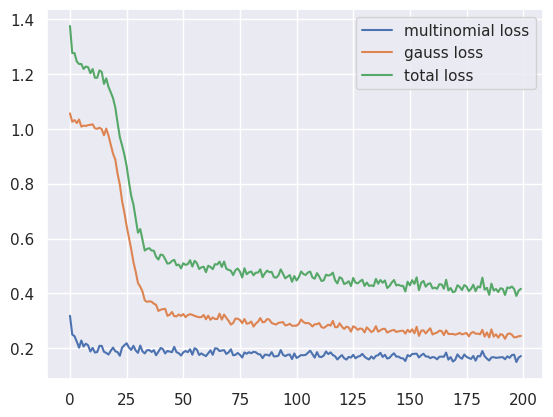

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0

Sample timestep    0
Sample timestep    0

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
plotting matrices for model 1 (underneath):
7.372521270458748


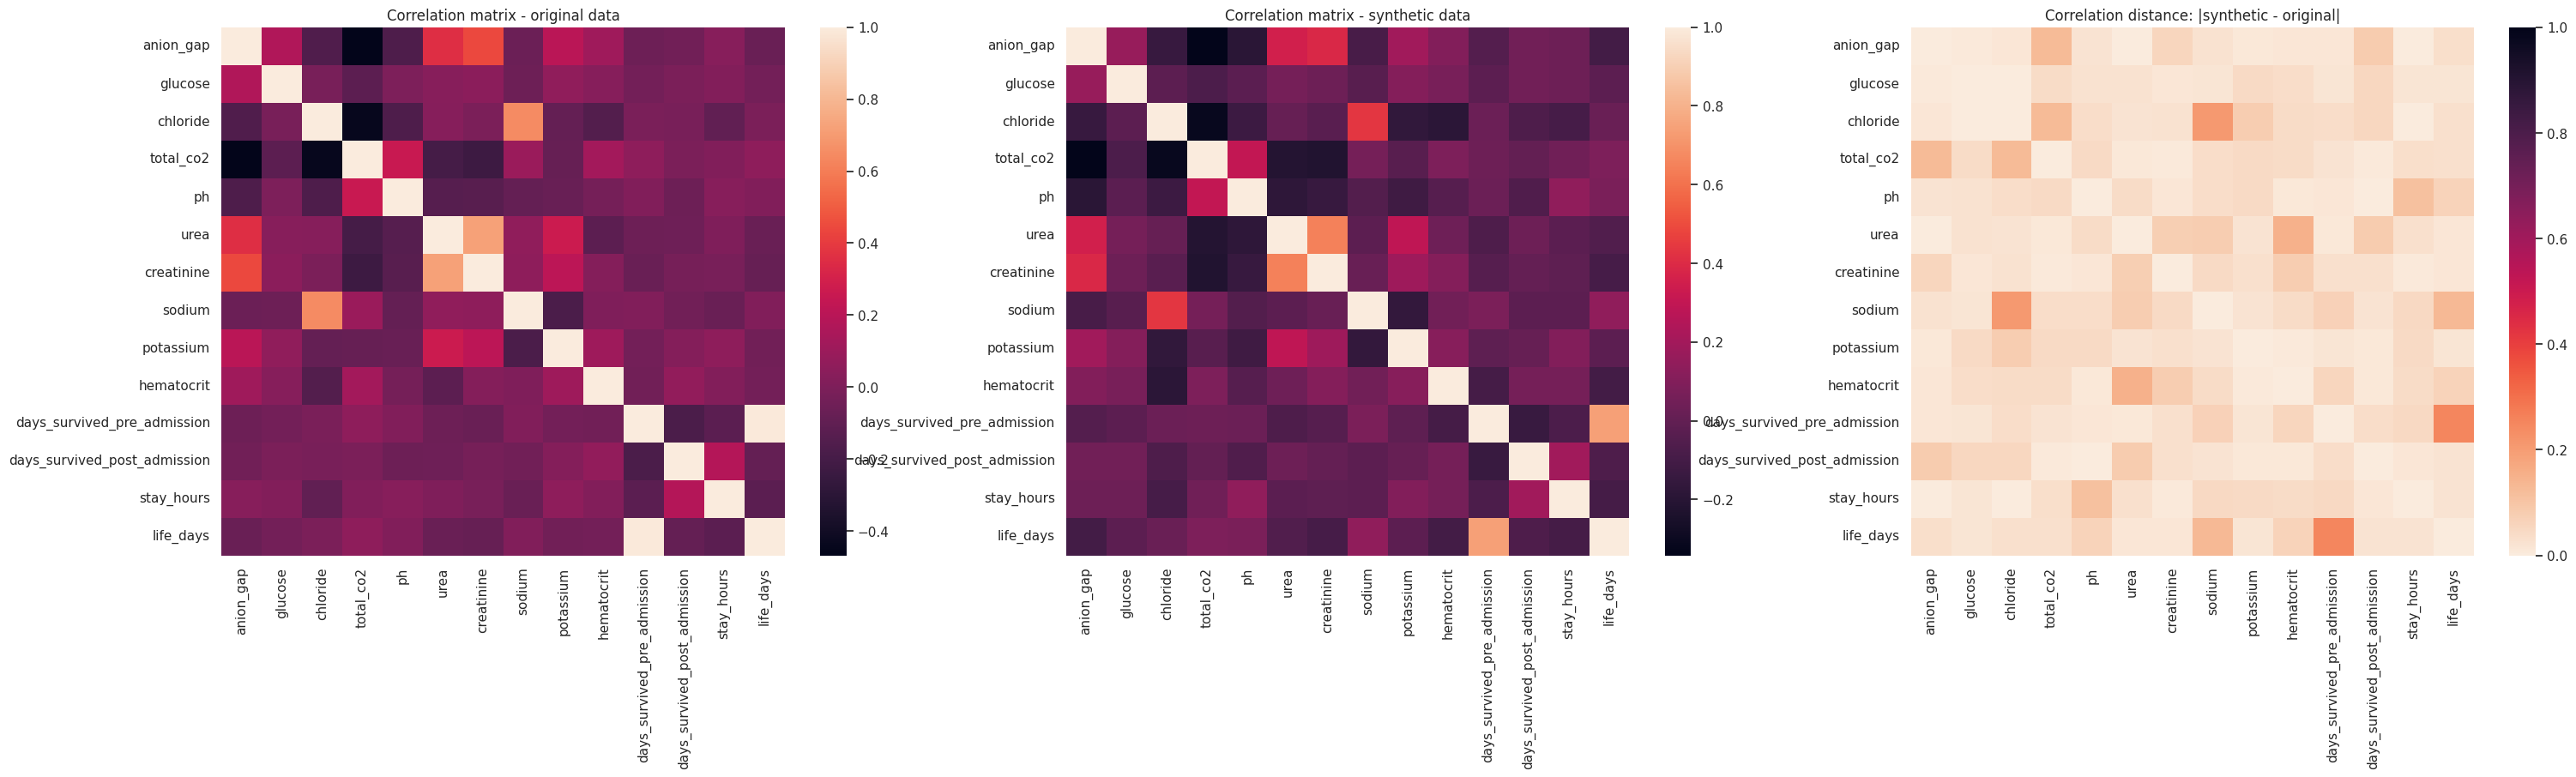

4.010785940624946


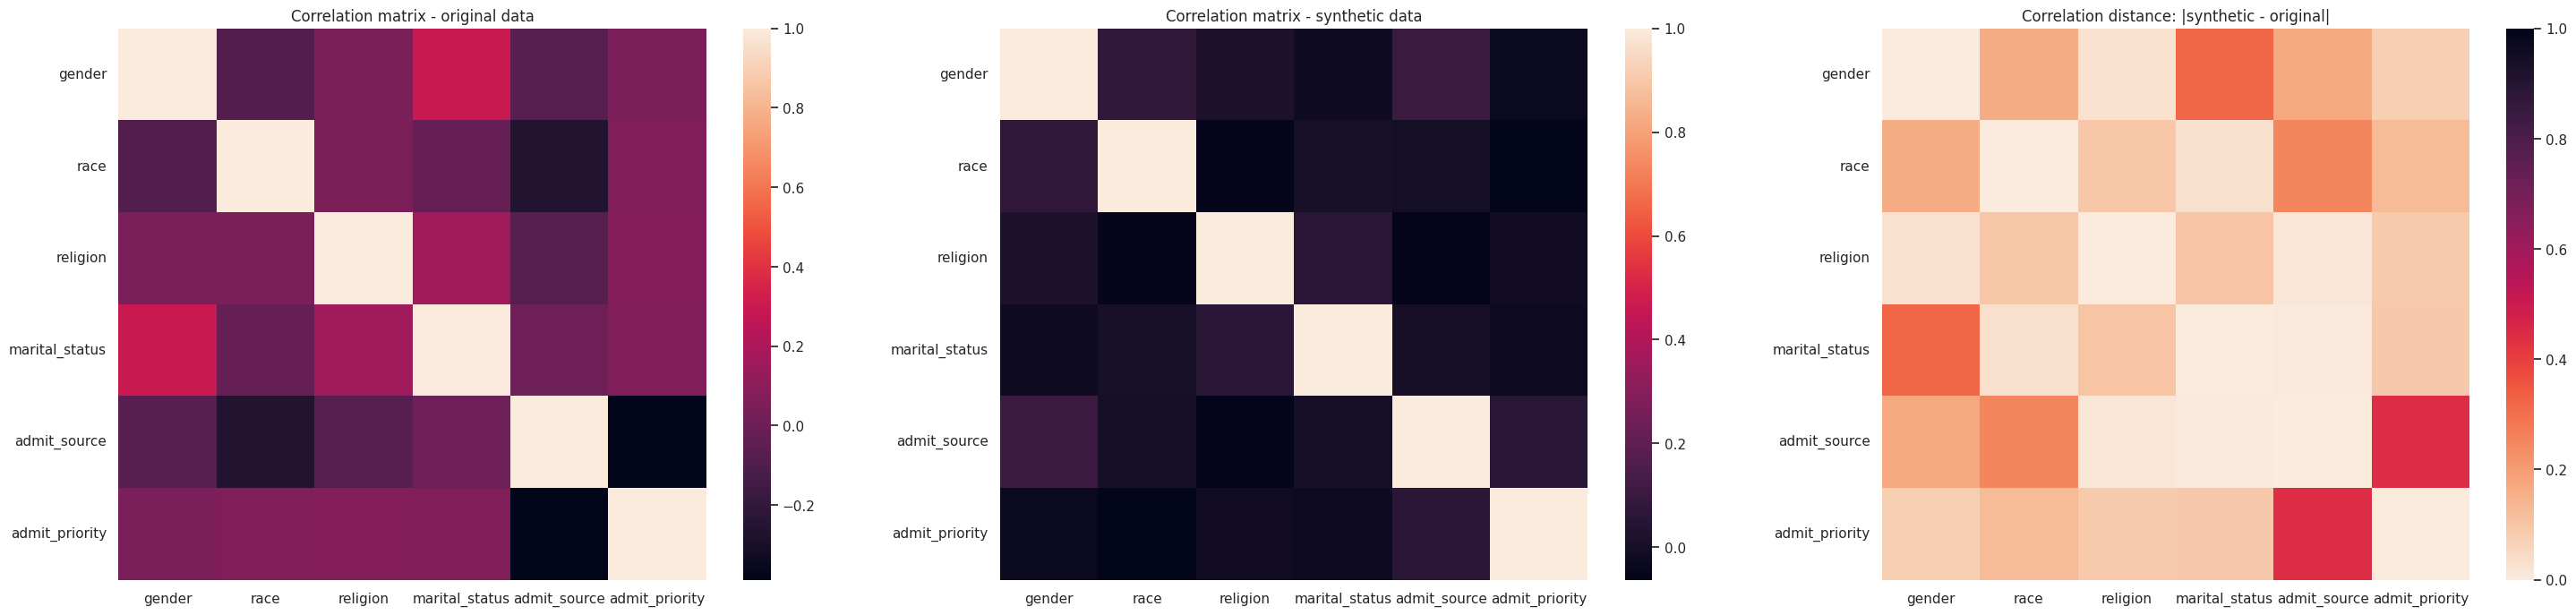

lab pdfs for model 1 (underneath):


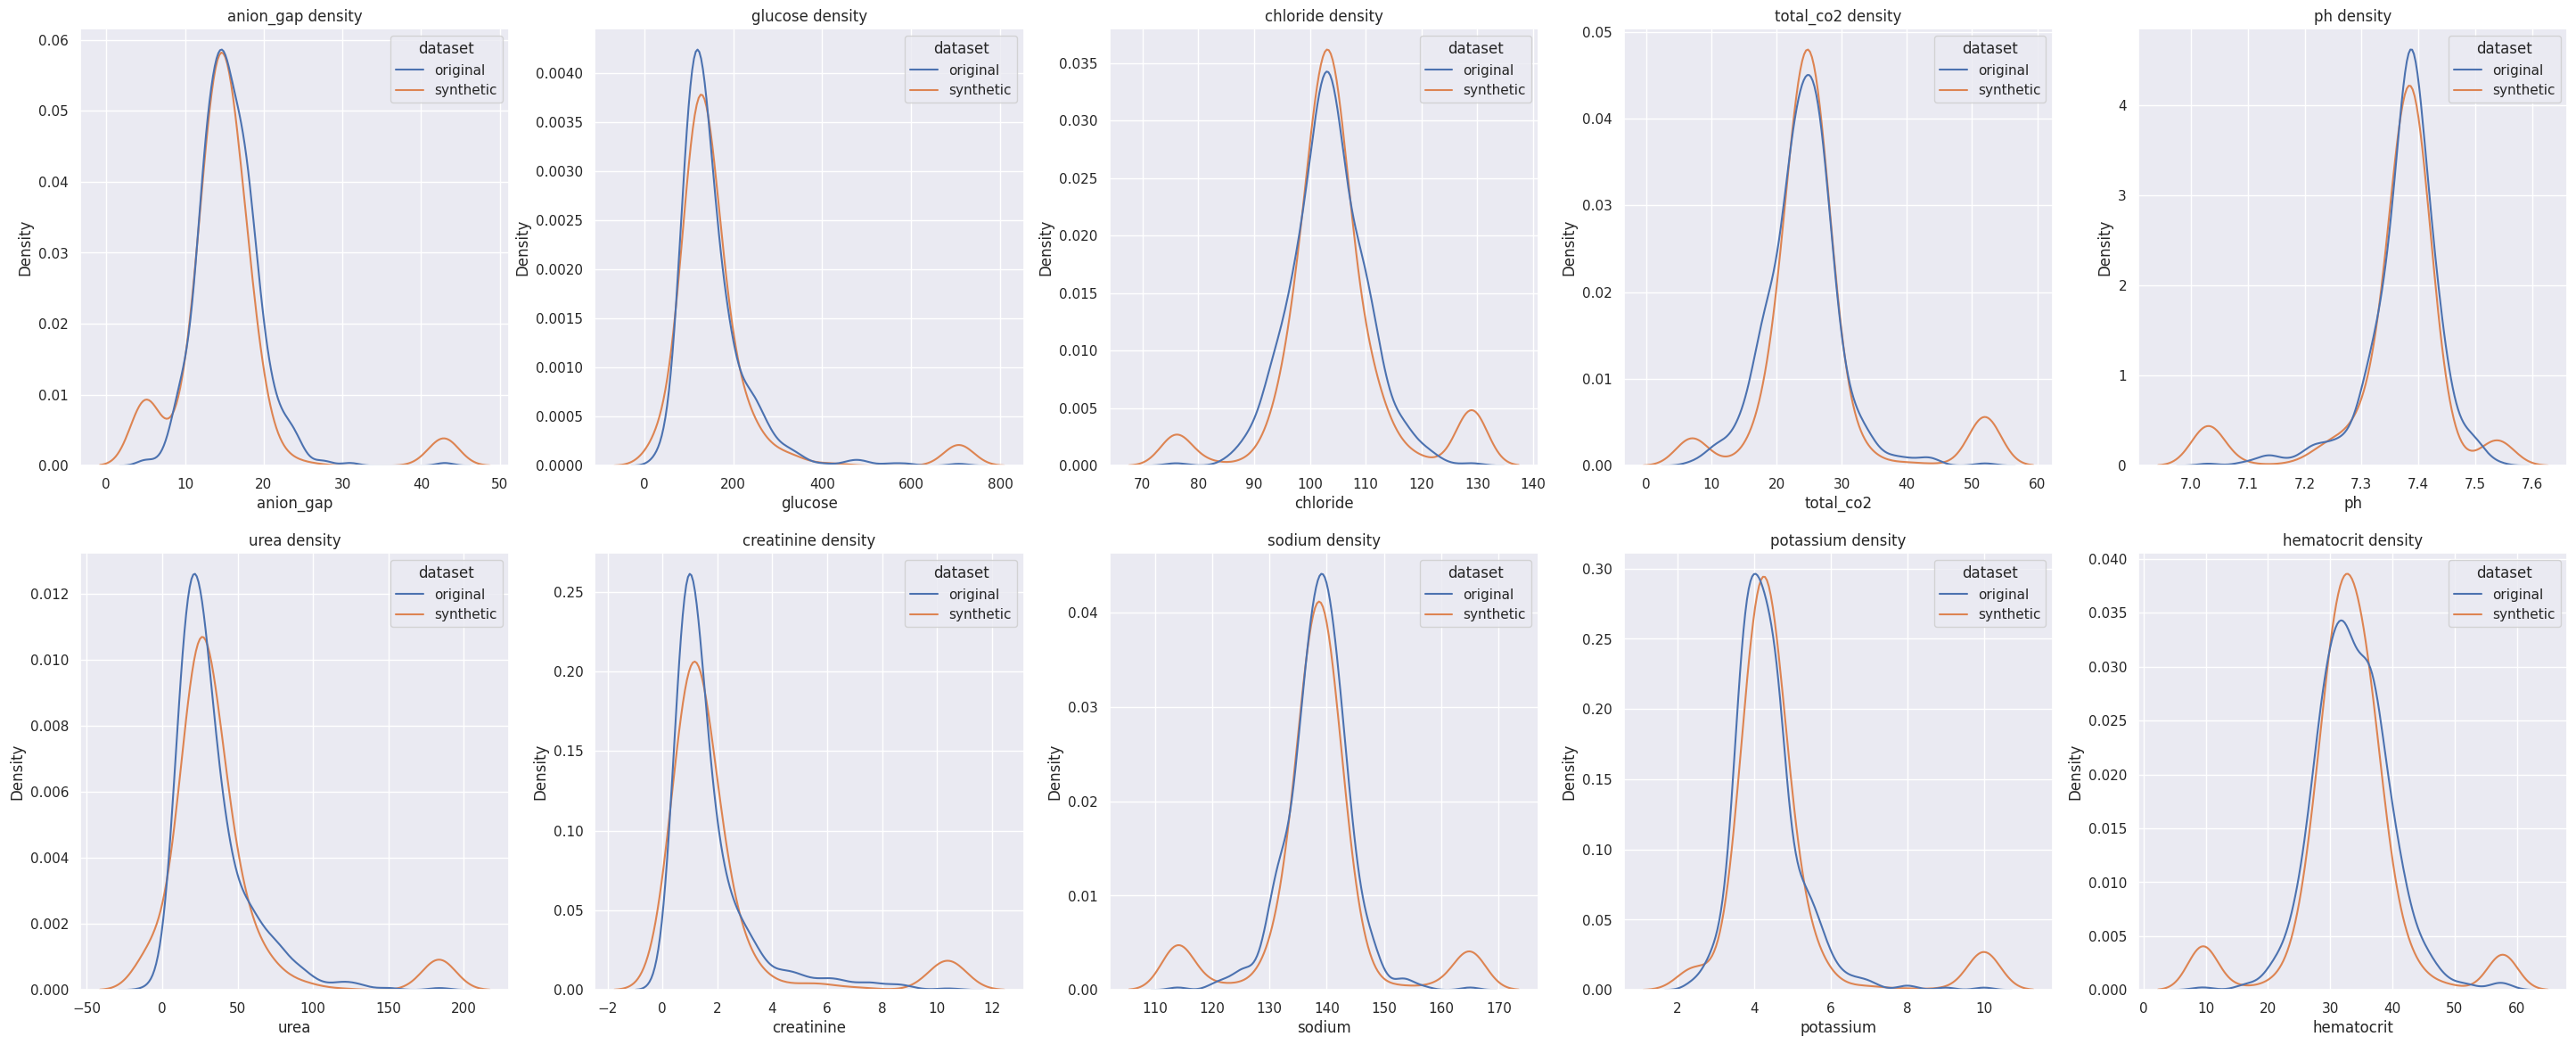

numerical patient stay pdfs for model 1 (underneath):


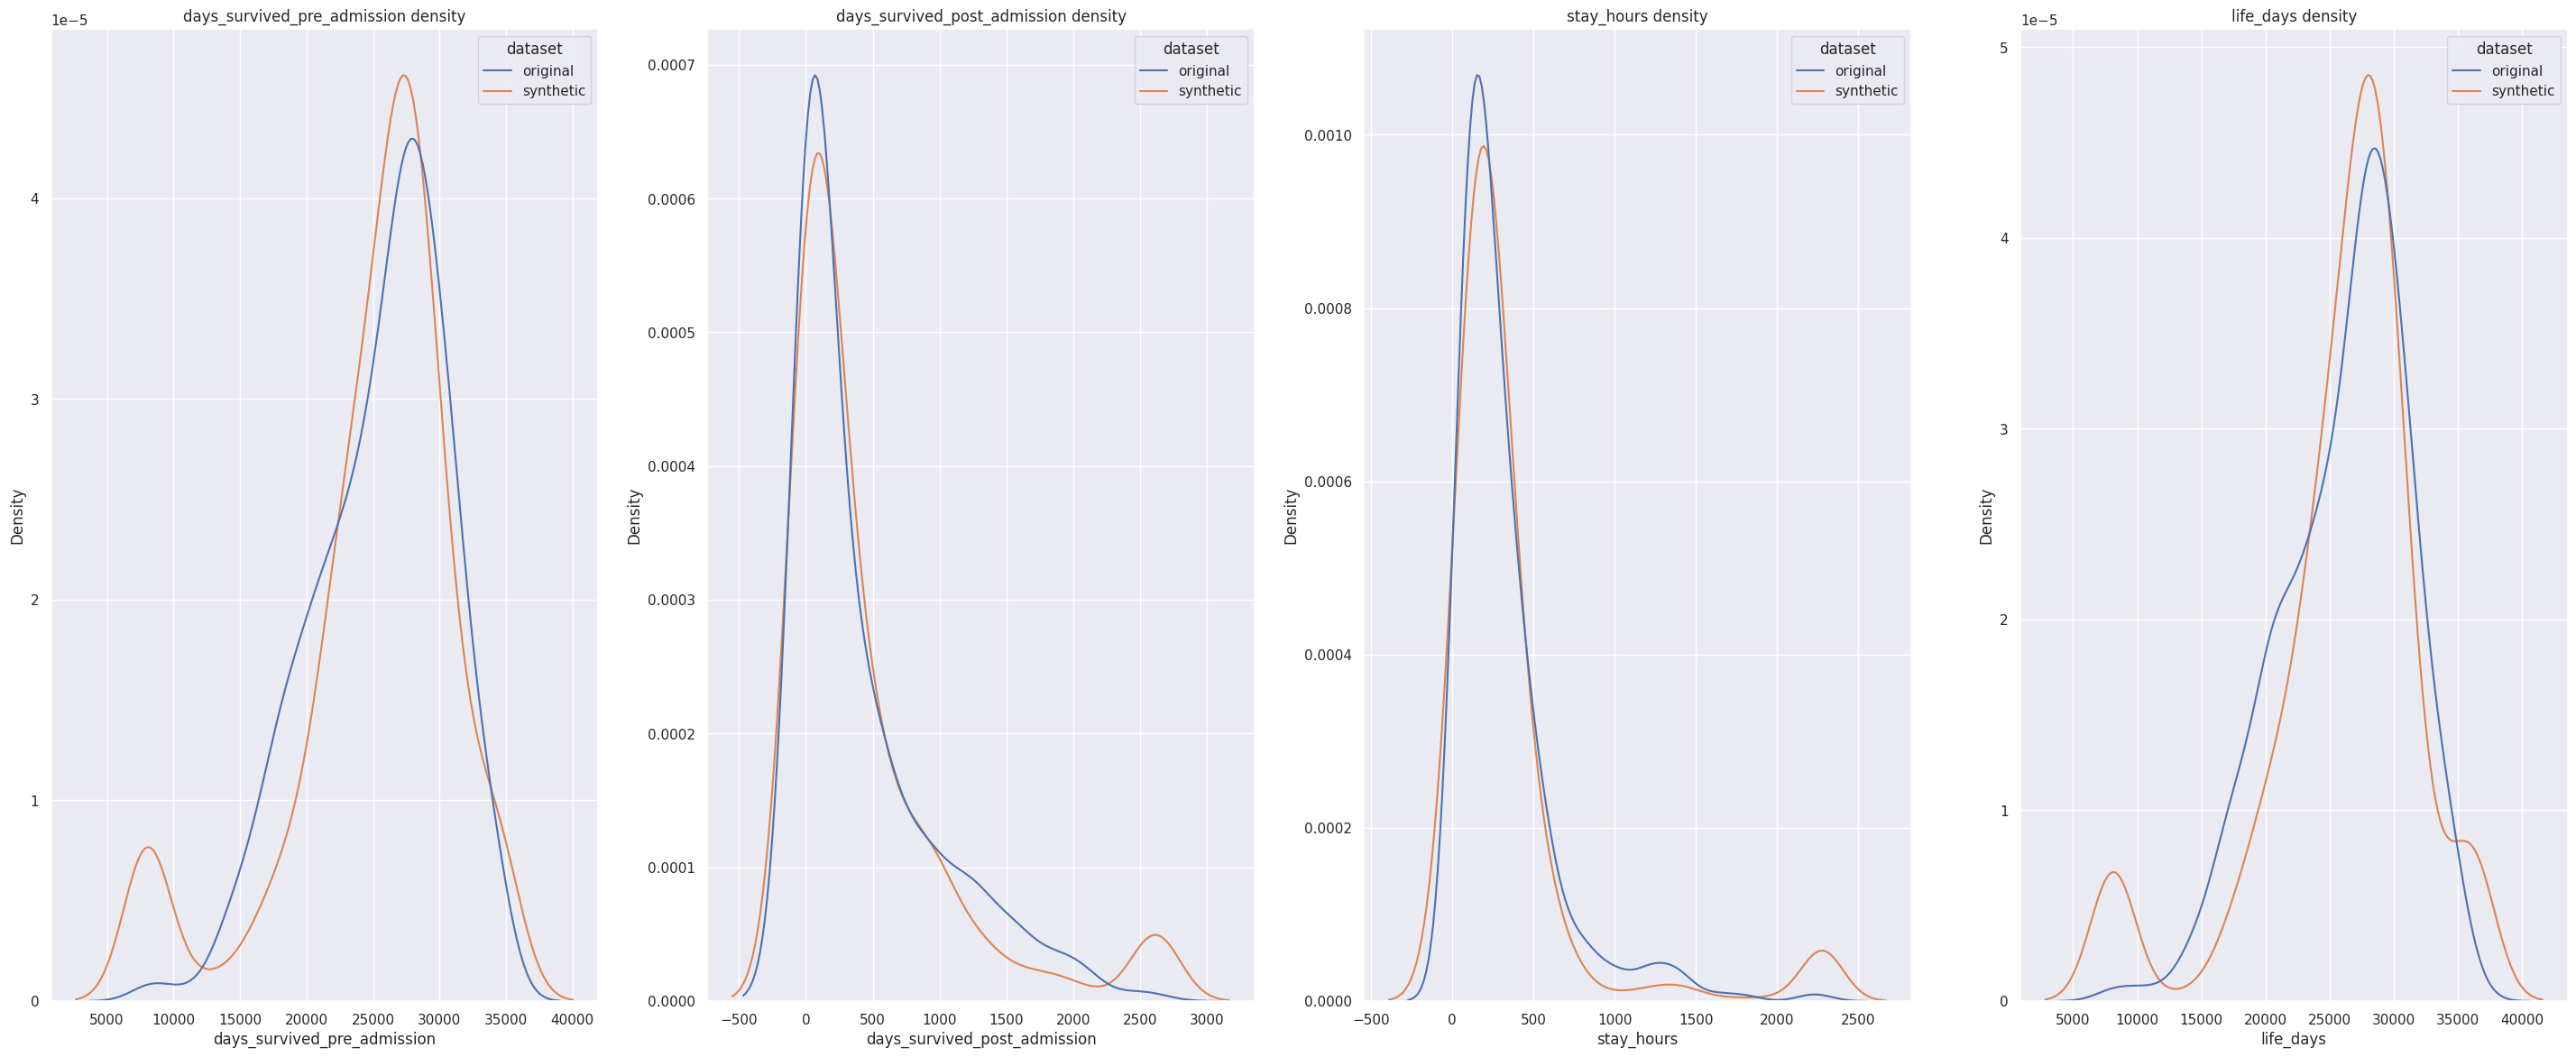

categorical pdfs for model 1 (underneath):


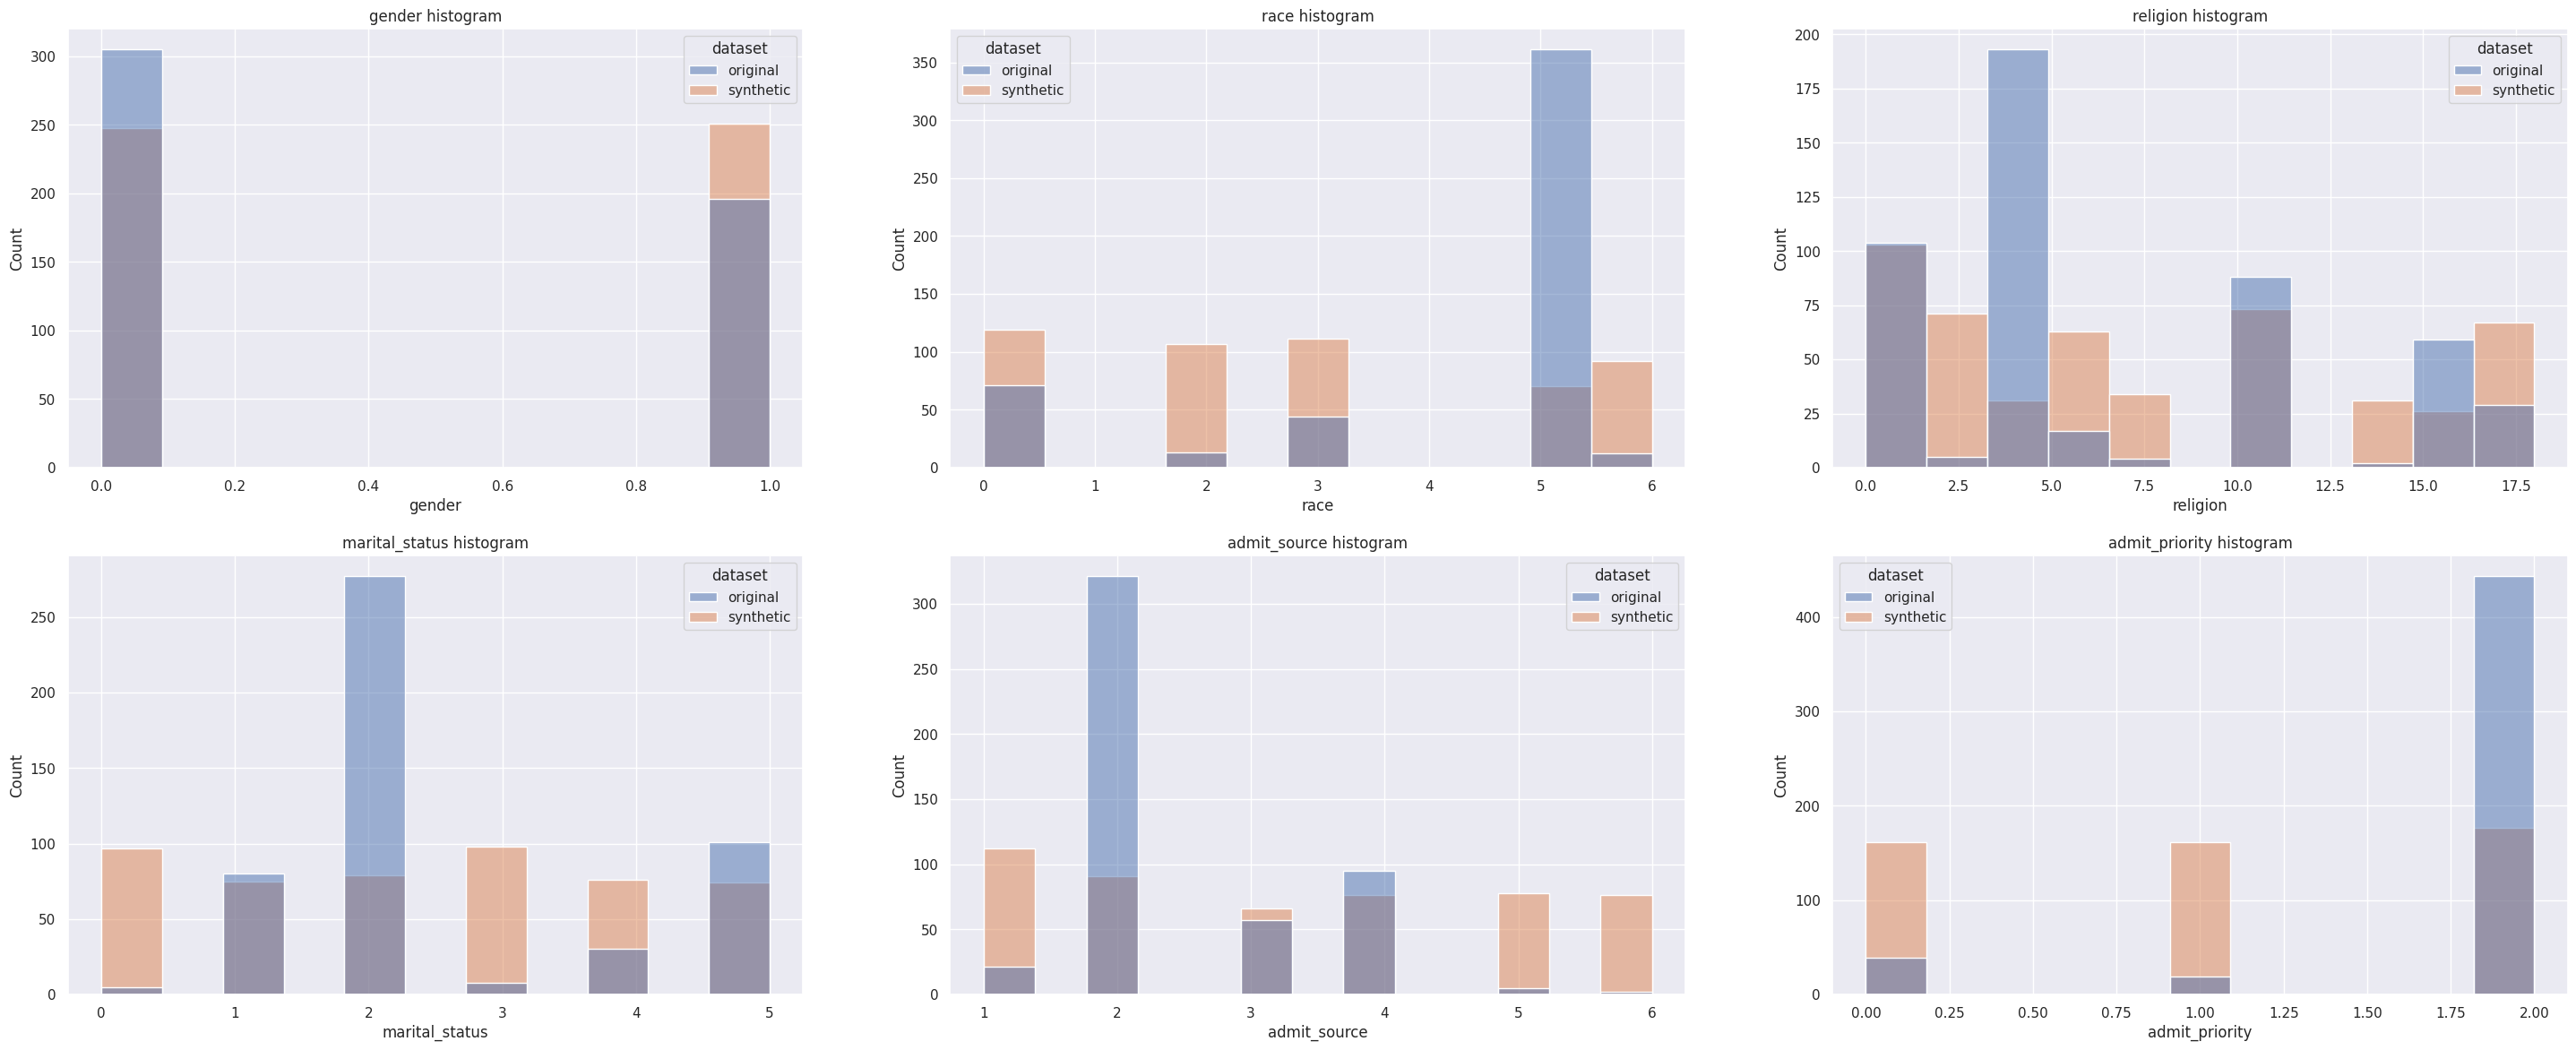

The program has been running for 549.0194680690765 seconds
we're doing resnet
Running model2....
Running model2....
Running model2....
Number of trainable parameters:  178052
Step 500/10000 MLoss: 0.2046 GLoss: 1.0108 Sum: 1.2153999999999998
Step 1000/10000 MLoss: 0.1765 GLoss: 0.8901 Sum: 1.0666
Step 1500/10000 MLoss: 0.1965 GLoss: 0.422 Sum: 0.6185
Step 2000/10000 MLoss: 0.2045 GLoss: 0.3361 Sum: 0.5406
Step 2500/10000 MLoss: 0.1998 GLoss: 0.3196 Sum: 0.5194
Step 3000/10000 MLoss: 0.1777 GLoss: 0.2934 Sum: 0.47109999999999996
Step 3500/10000 MLoss: 0.1783 GLoss: 0.2898 Sum: 0.46809999999999996
Step 4000/10000 MLoss: 0.1943 GLoss: 0.3115 Sum: 0.5058
Step 4500/10000 MLoss: 0.1854 GLoss: 0.2996 Sum: 0.485
Step 5000/10000 MLoss: 0.1763 GLoss: 0.2991 Sum: 0.4754
Step 5500/10000 MLoss: 0.1655 GLoss: 0.2845 Sum: 0.44999999999999996
Step 6000/10000 MLoss: 0.1777 GLoss: 0.2881 Sum: 0.4658
Step 6500/10000 MLoss: 0.1771 GLoss: 0.2728 Sum: 0.44989999999999997
Step 7000/10000 MLoss: 0.1832 GLoss:

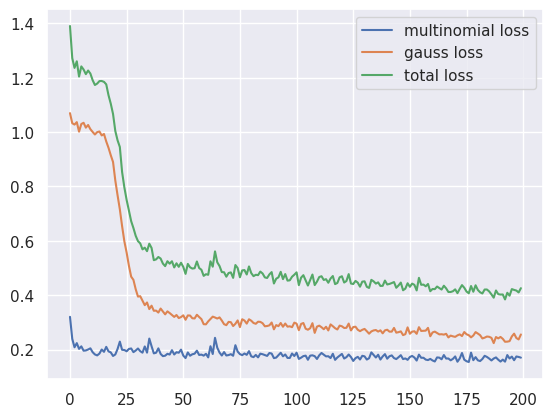

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
plotting matrices for model 2 (underneath):
9.140166548310727


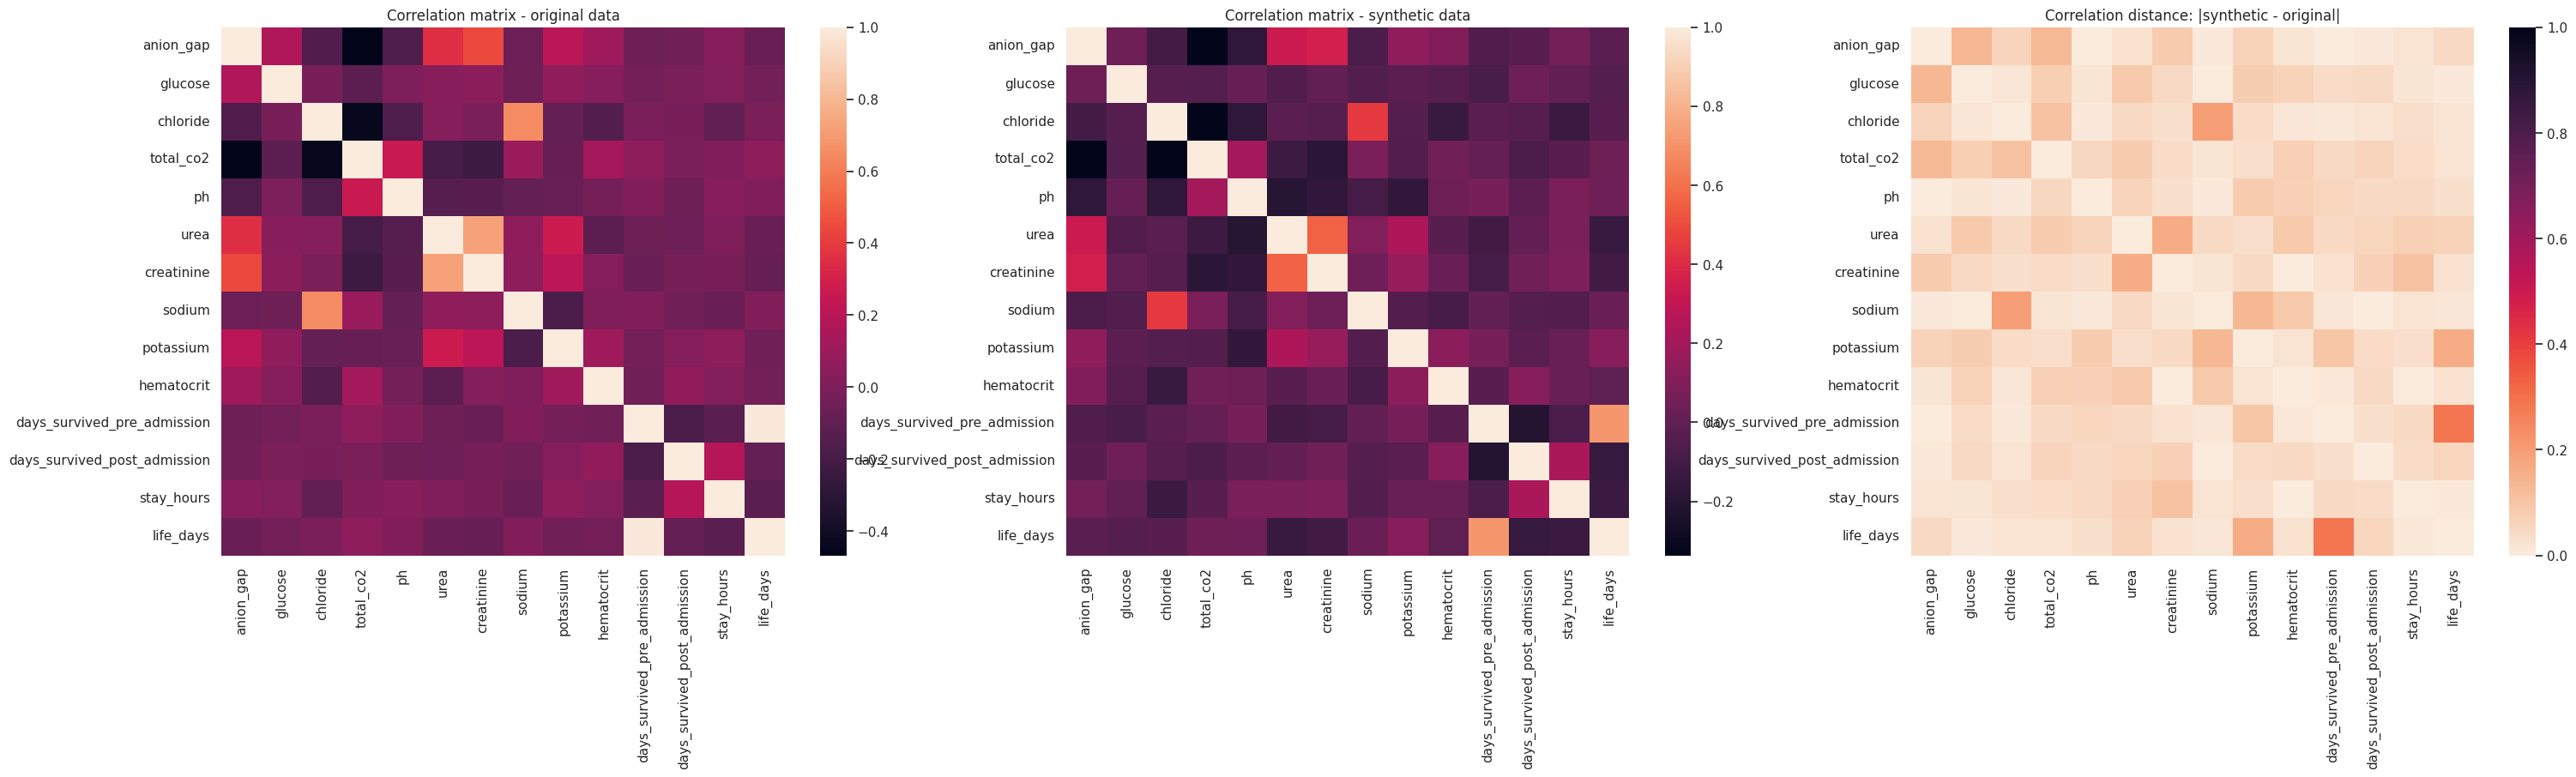

3.736302389657707


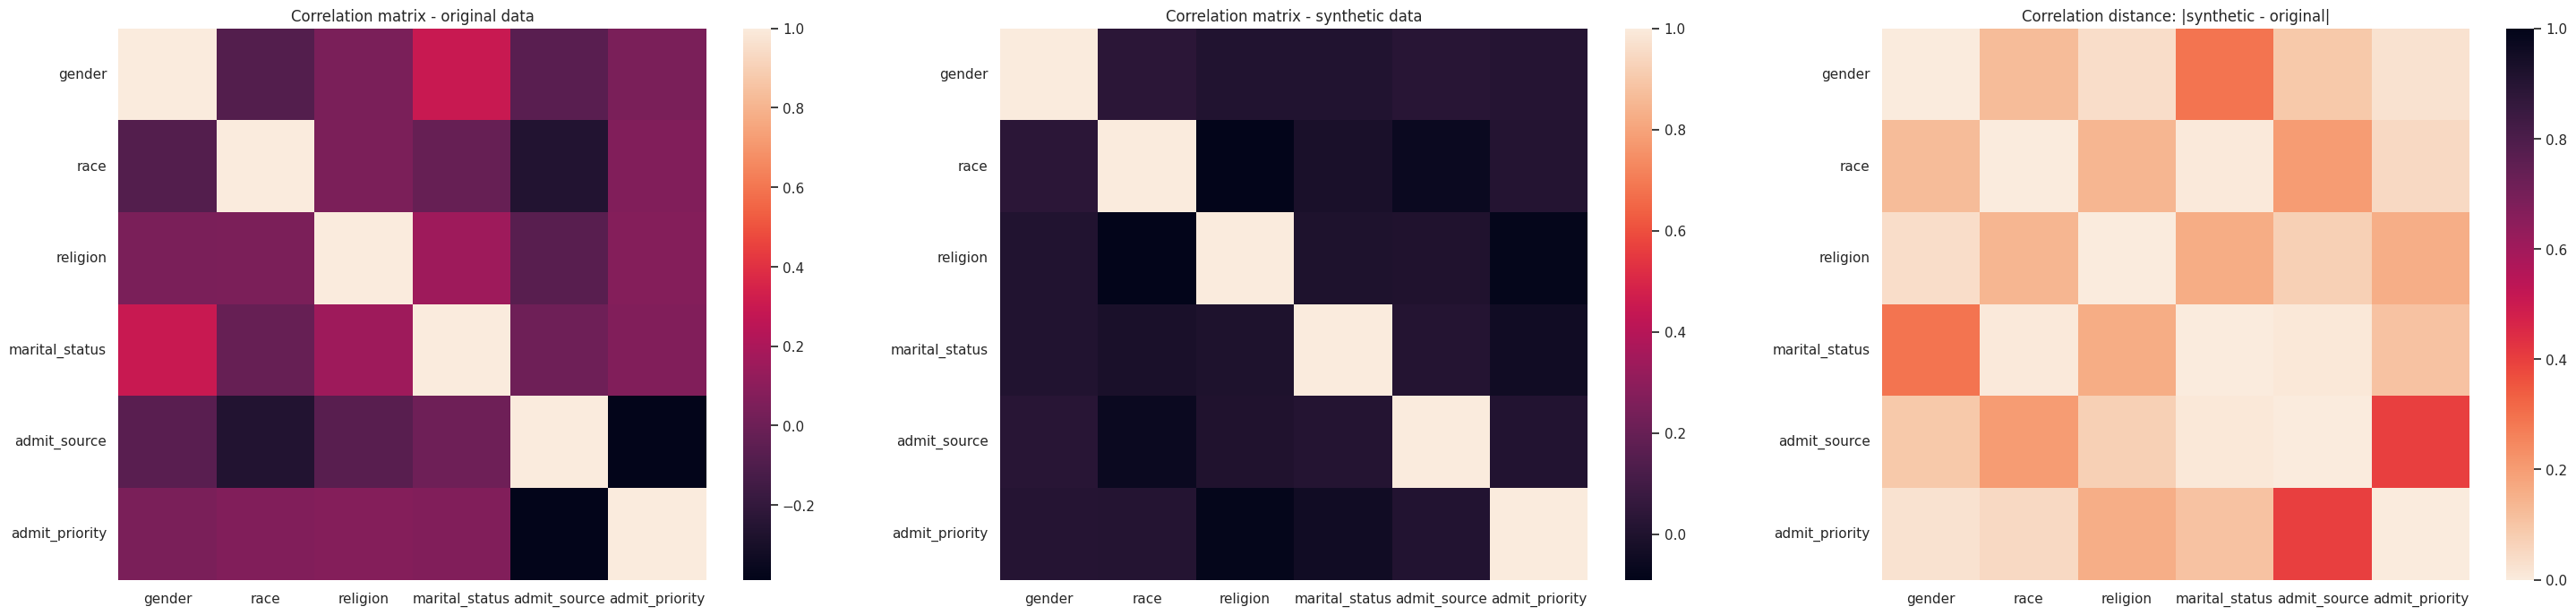

lab pdfs for model 2 (underneath):


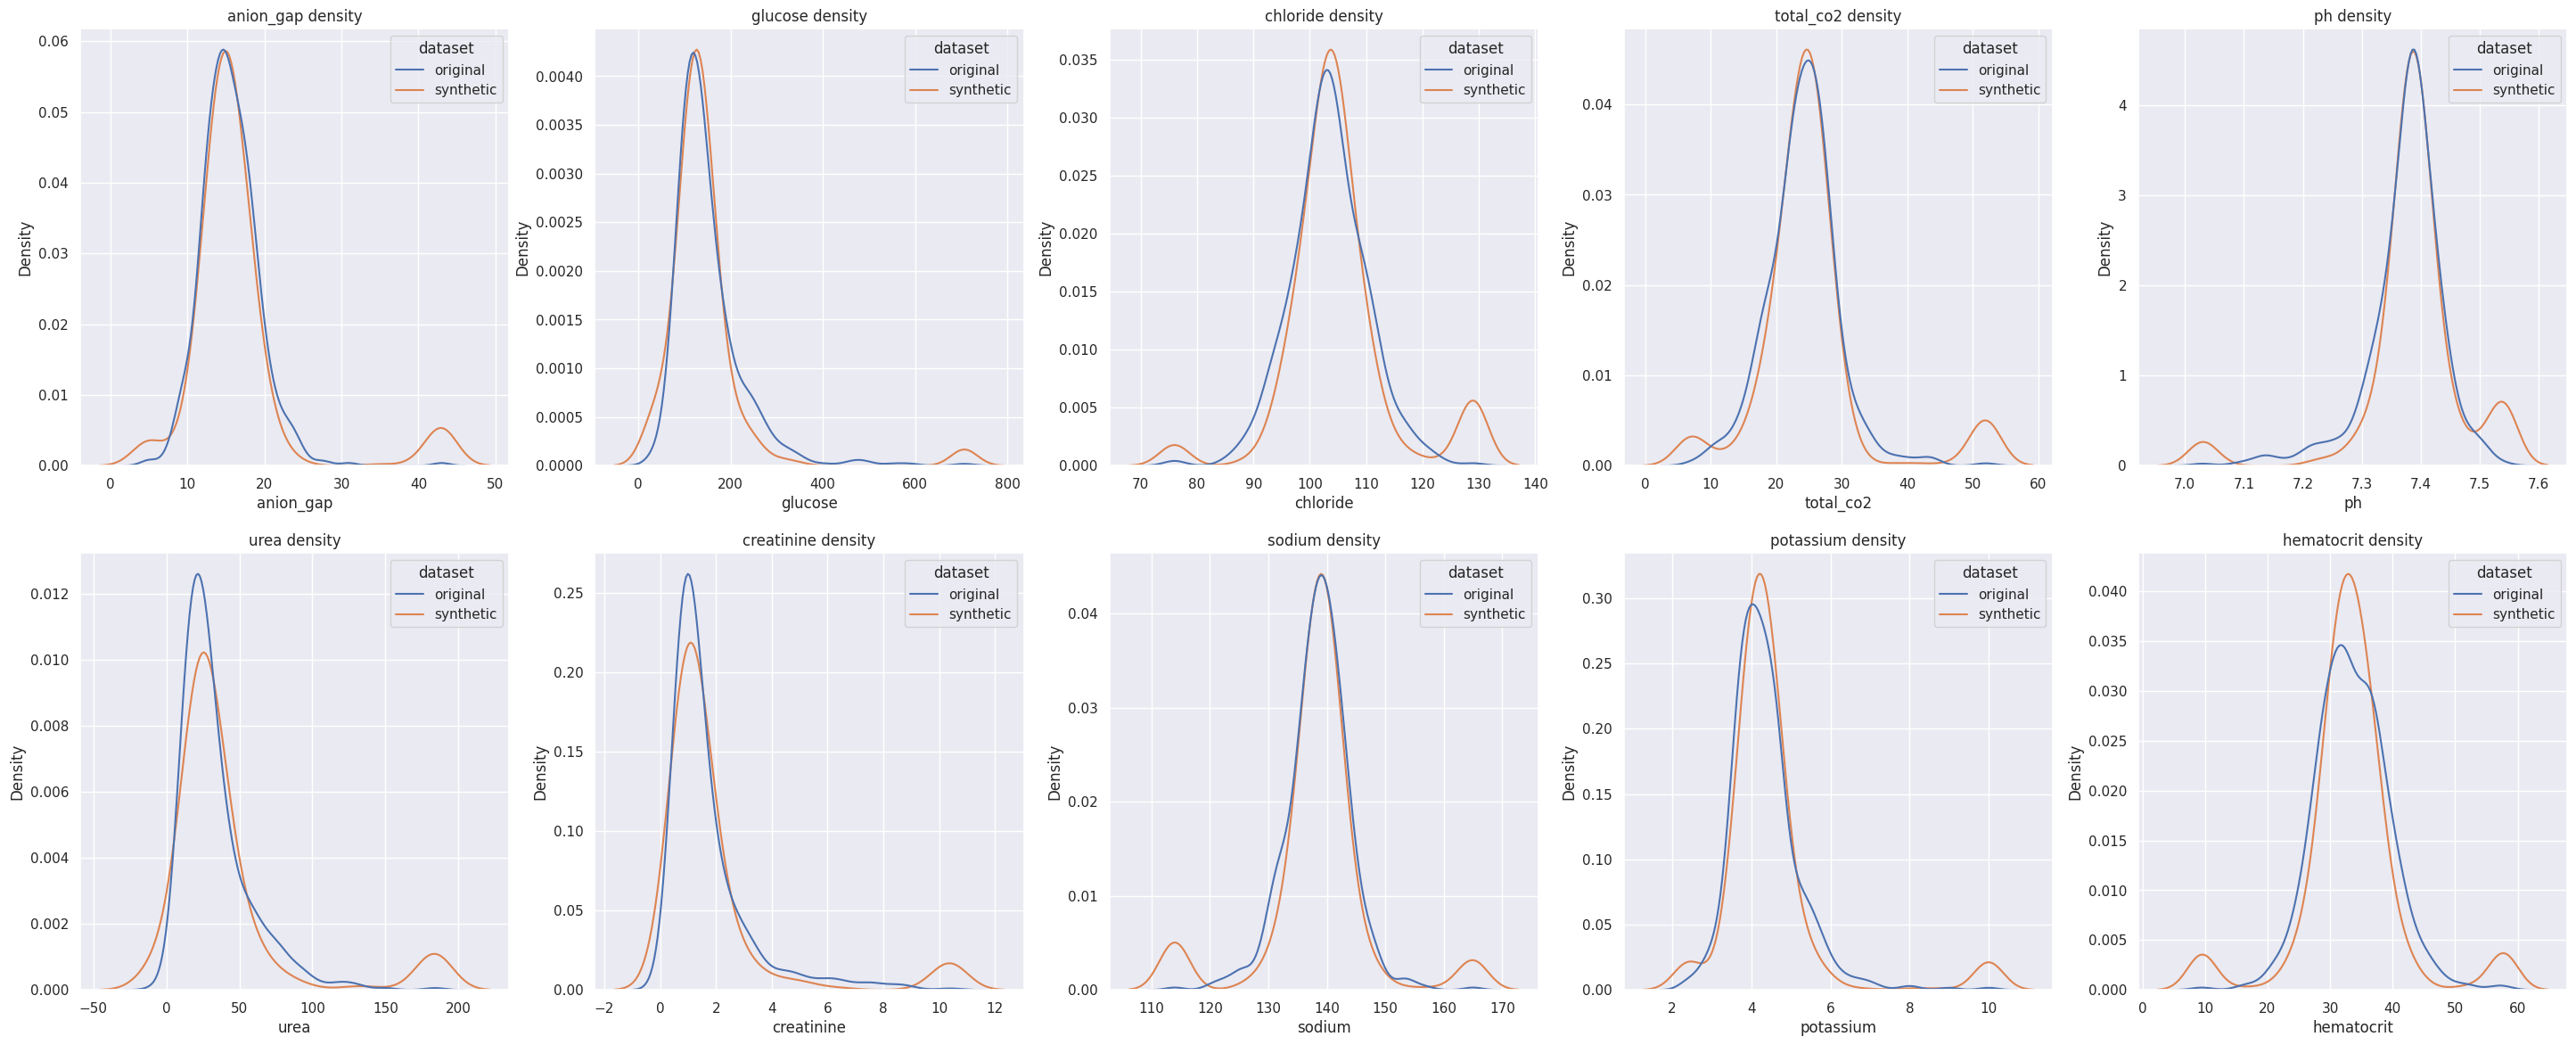

numerical patient stay pdfs for model 2 (underneath):


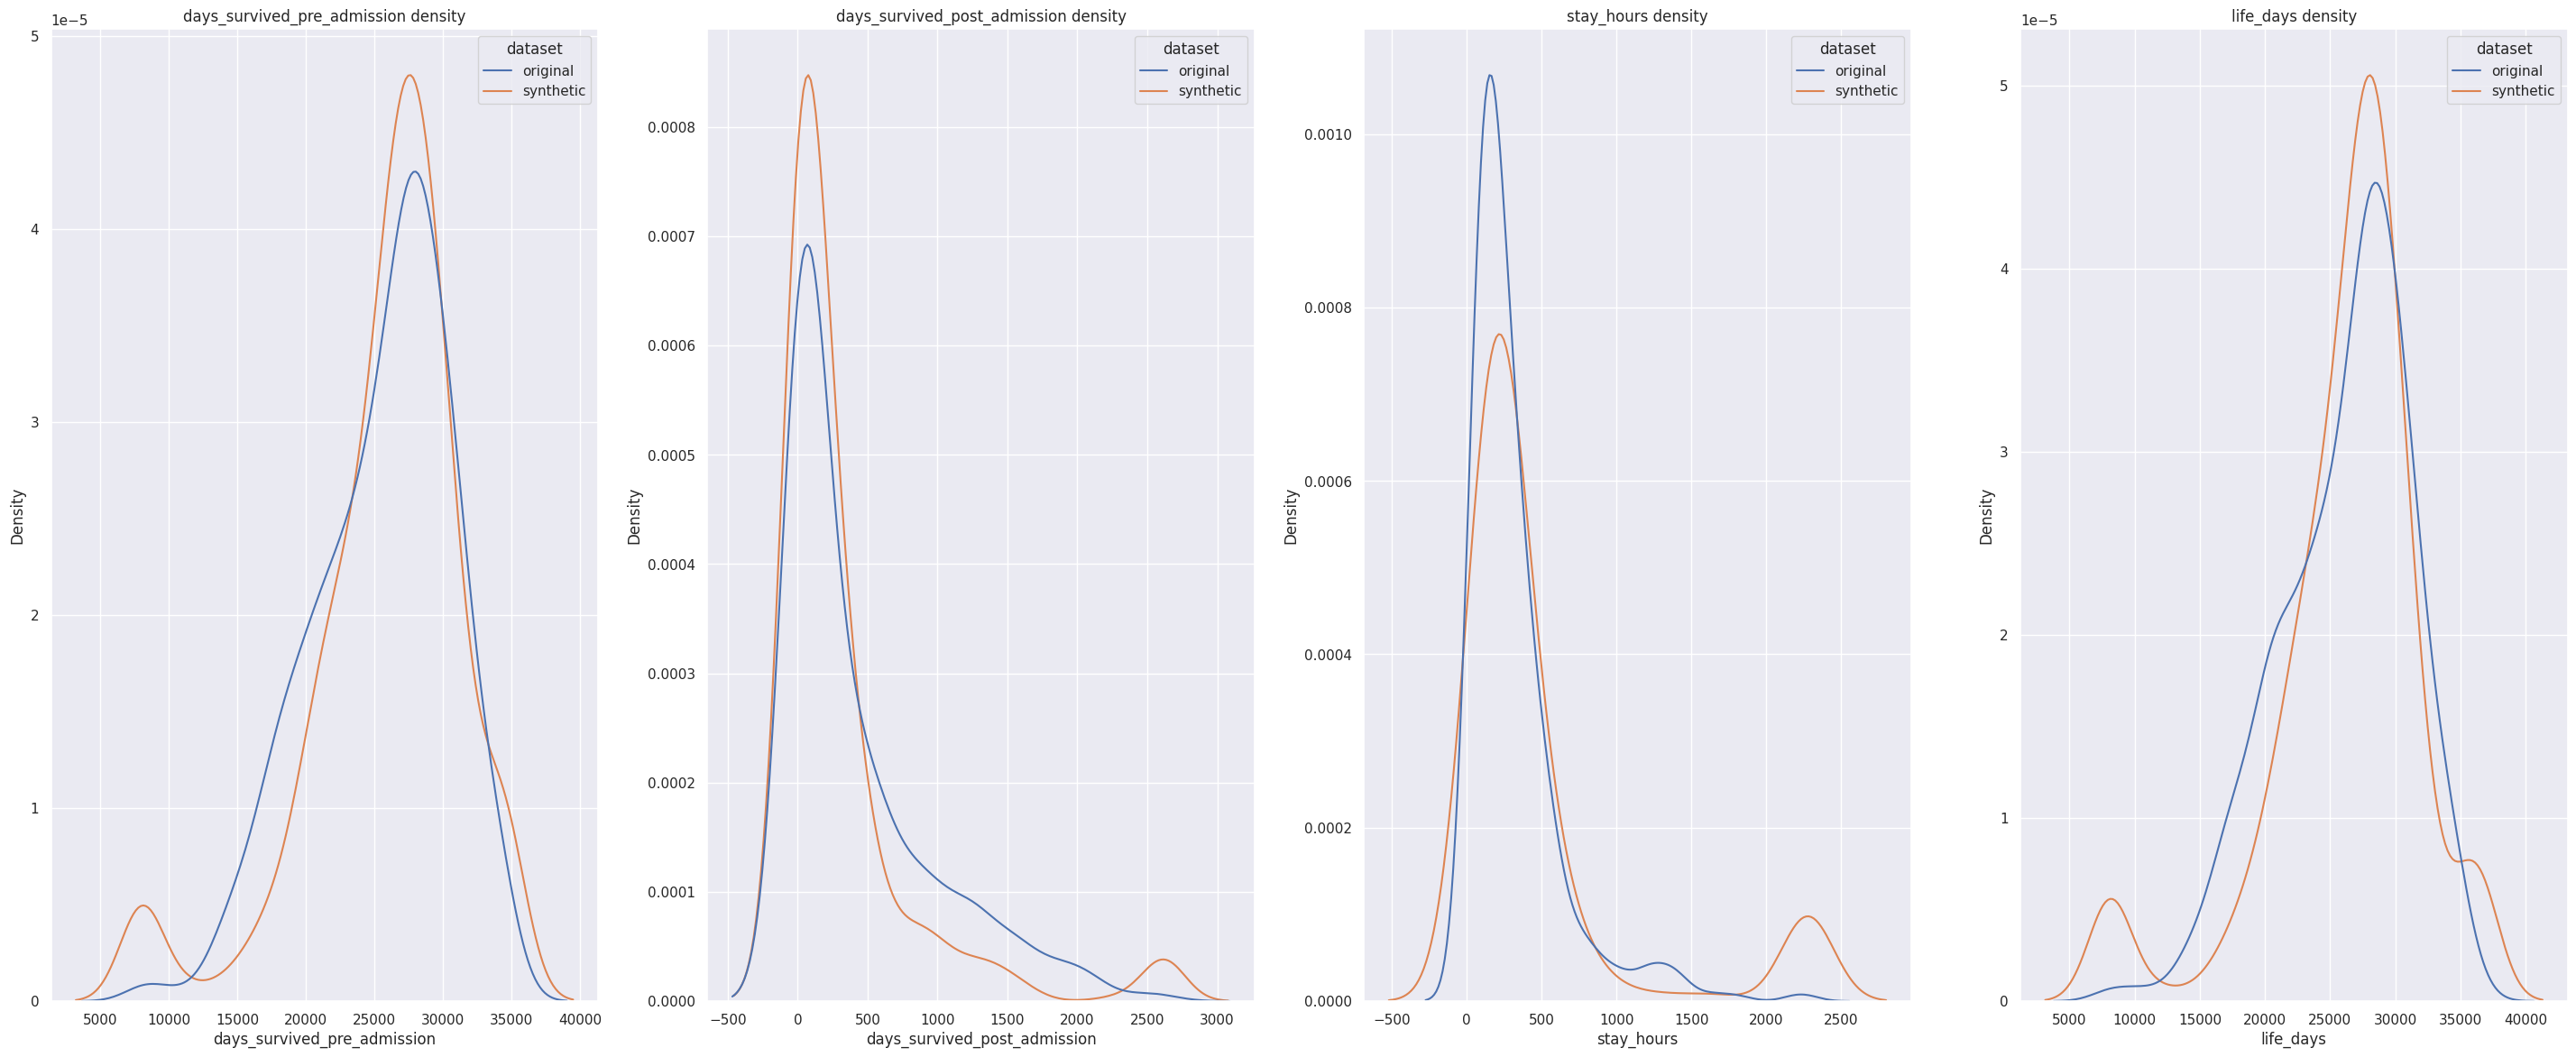

categorical pdfs for model 2 (underneath):


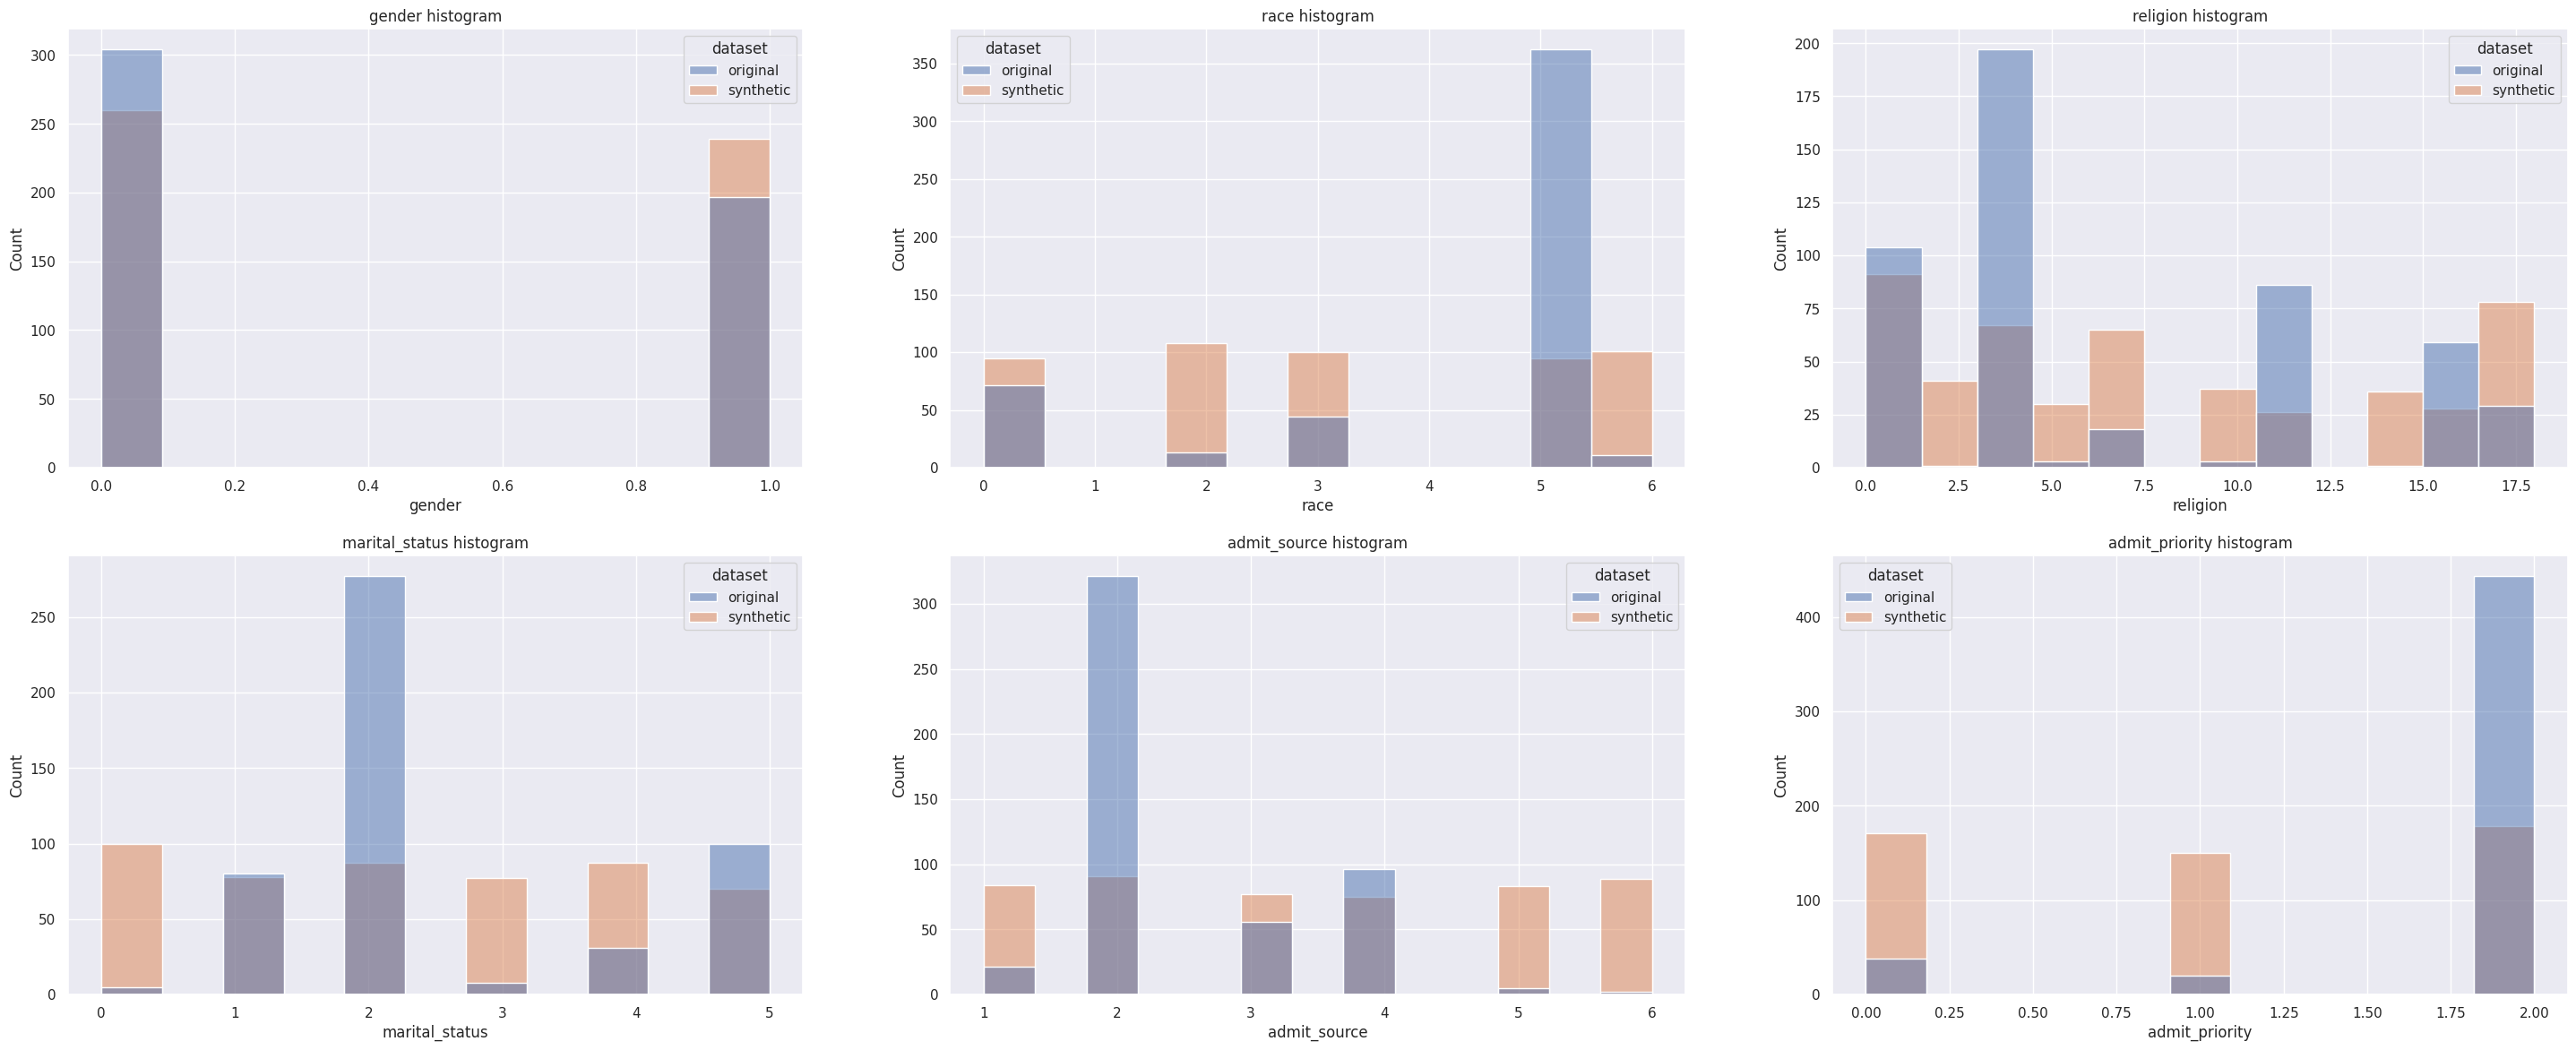

The program has been running for 1098.5739641189575 seconds
we're doing mlp
Running model3....
Running model3....
Running model3....
Number of trainable parameters:  132740
Step 500/10000 MLoss: 0.2739 GLoss: 1.0077 Sum: 1.2816
Step 1000/10000 MLoss: 0.2649 GLoss: 1.0009 Sum: 1.2658
Step 1500/10000 MLoss: 0.2632 GLoss: 1.0005 Sum: 1.2637
Step 2000/10000 MLoss: 0.3053 GLoss: 0.997 Sum: 1.3023
Step 2500/10000 MLoss: 0.2823 GLoss: 1.0112 Sum: 1.2935
Step 3000/10000 MLoss: 0.2619 GLoss: 1.0088 Sum: 1.2707
Step 3500/10000 MLoss: 0.2583 GLoss: 1.003 Sum: 1.2612999999999999
Step 4000/10000 MLoss: 0.2773 GLoss: 1.0145 Sum: 1.2917999999999998
Step 4500/10000 MLoss: 0.2636 GLoss: 1.0179 Sum: 1.2815
Step 5000/10000 MLoss: 0.25 GLoss: 0.9841 Sum: 1.2341
Step 5500/10000 MLoss: 0.2632 GLoss: 0.9979 Sum: 1.2610999999999999
Step 6000/10000 MLoss: 0.2385 GLoss: 1.0056 Sum: 1.2441
Step 6500/10000 MLoss: 0.251 GLoss: 0.9943 Sum: 1.2452999999999999
Step 7000/10000 MLoss: 0.239 GLoss: 1.0058 Sum: 1.2448000

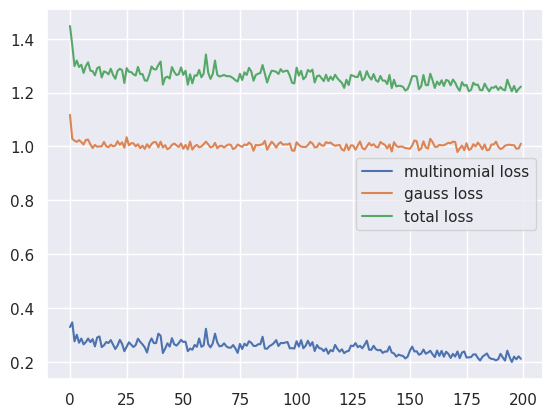

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
plotting matrices for model 3 (underneath):
22.606271145369732


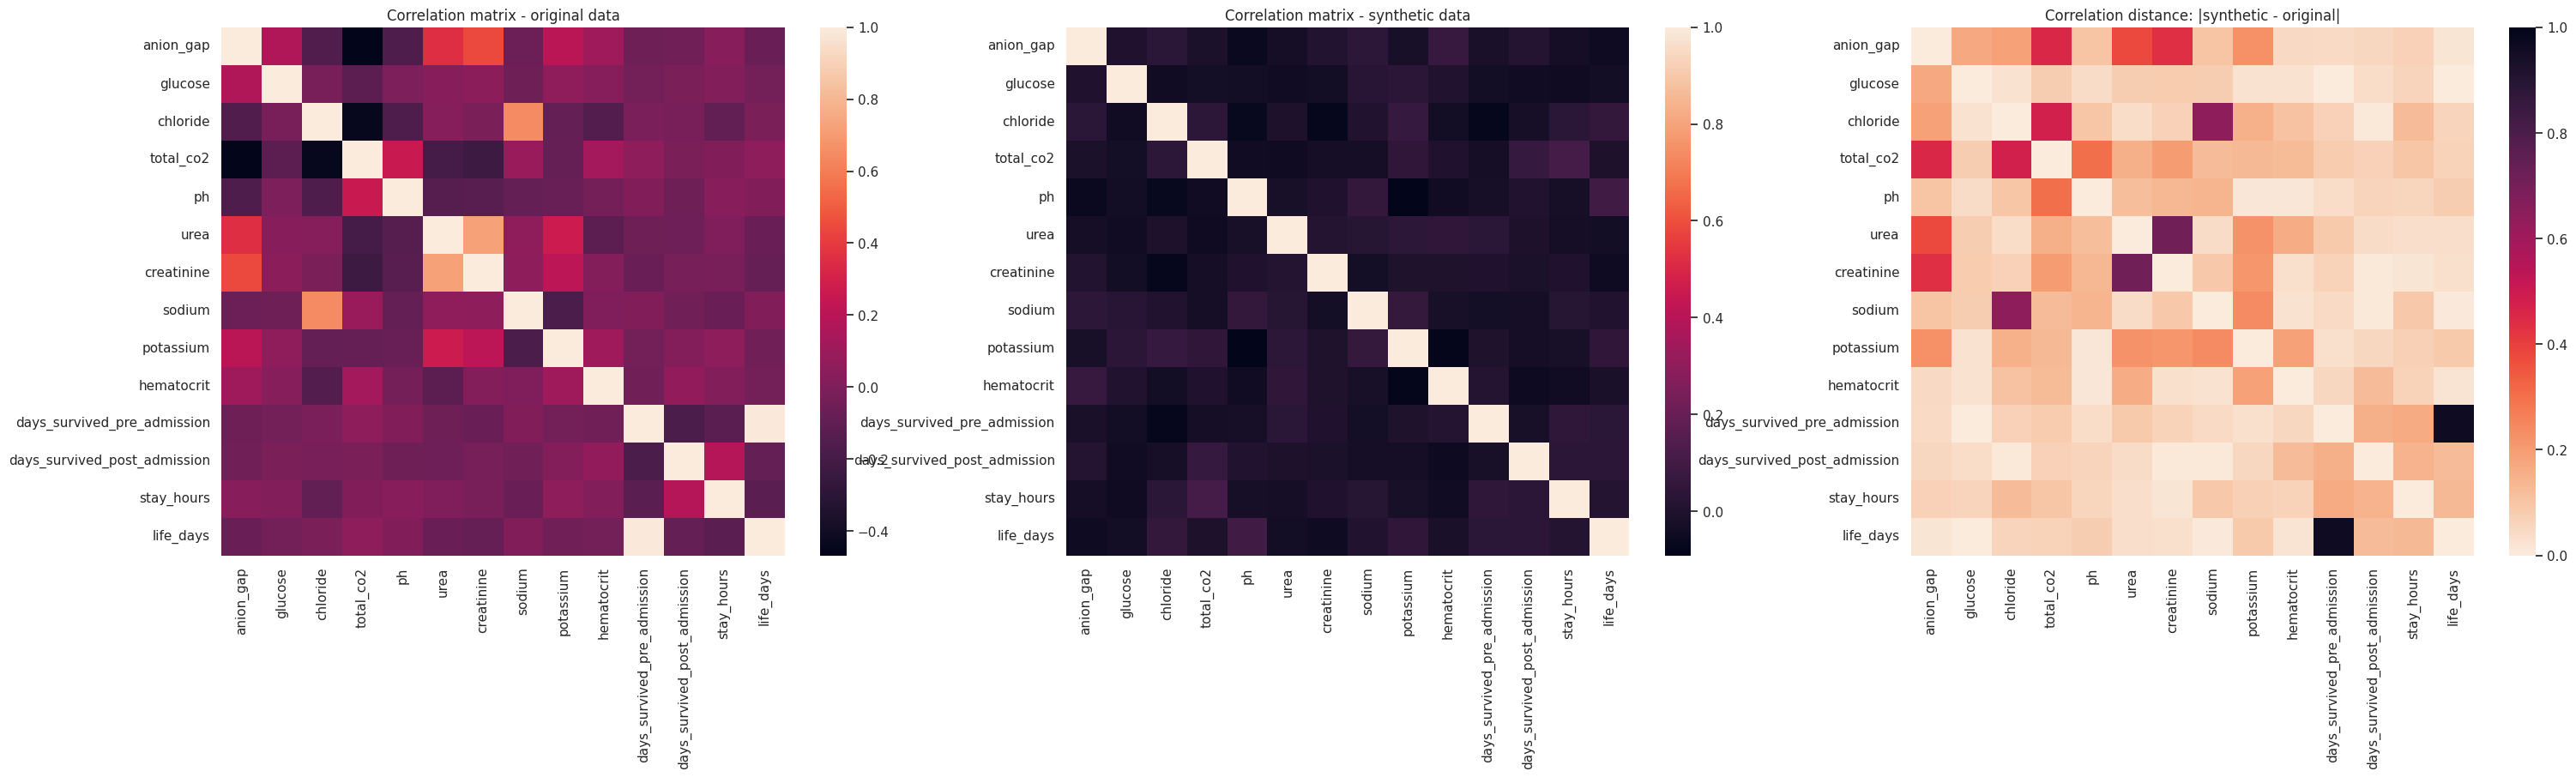

3.7936023668078485


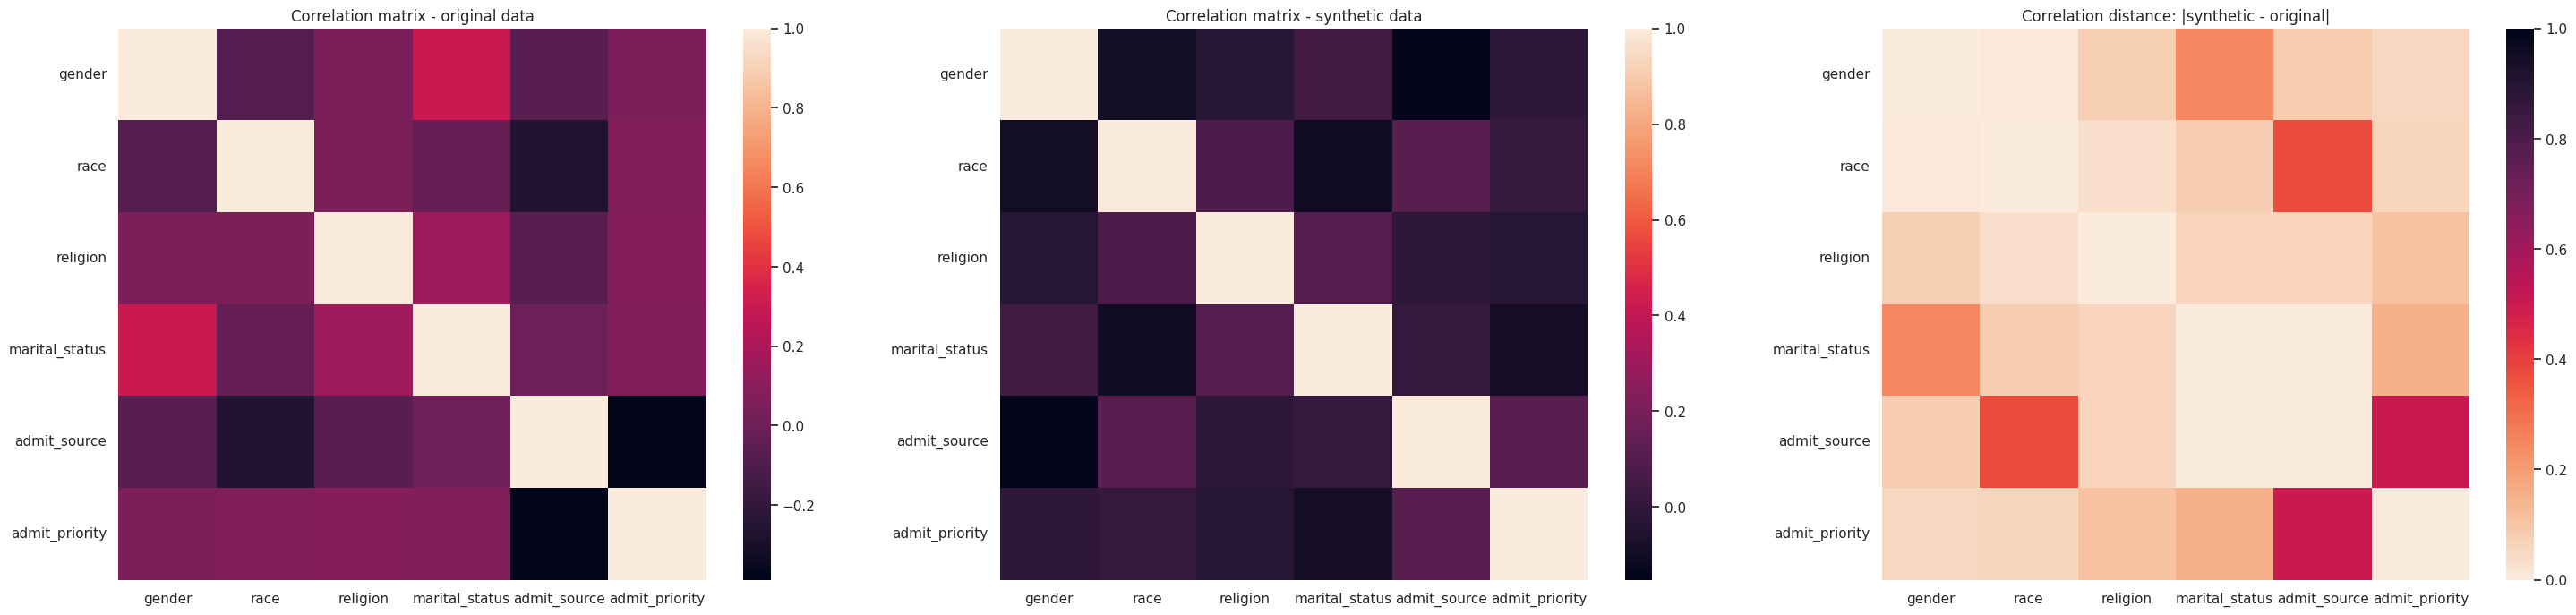

lab pdfs for model 3 (underneath):


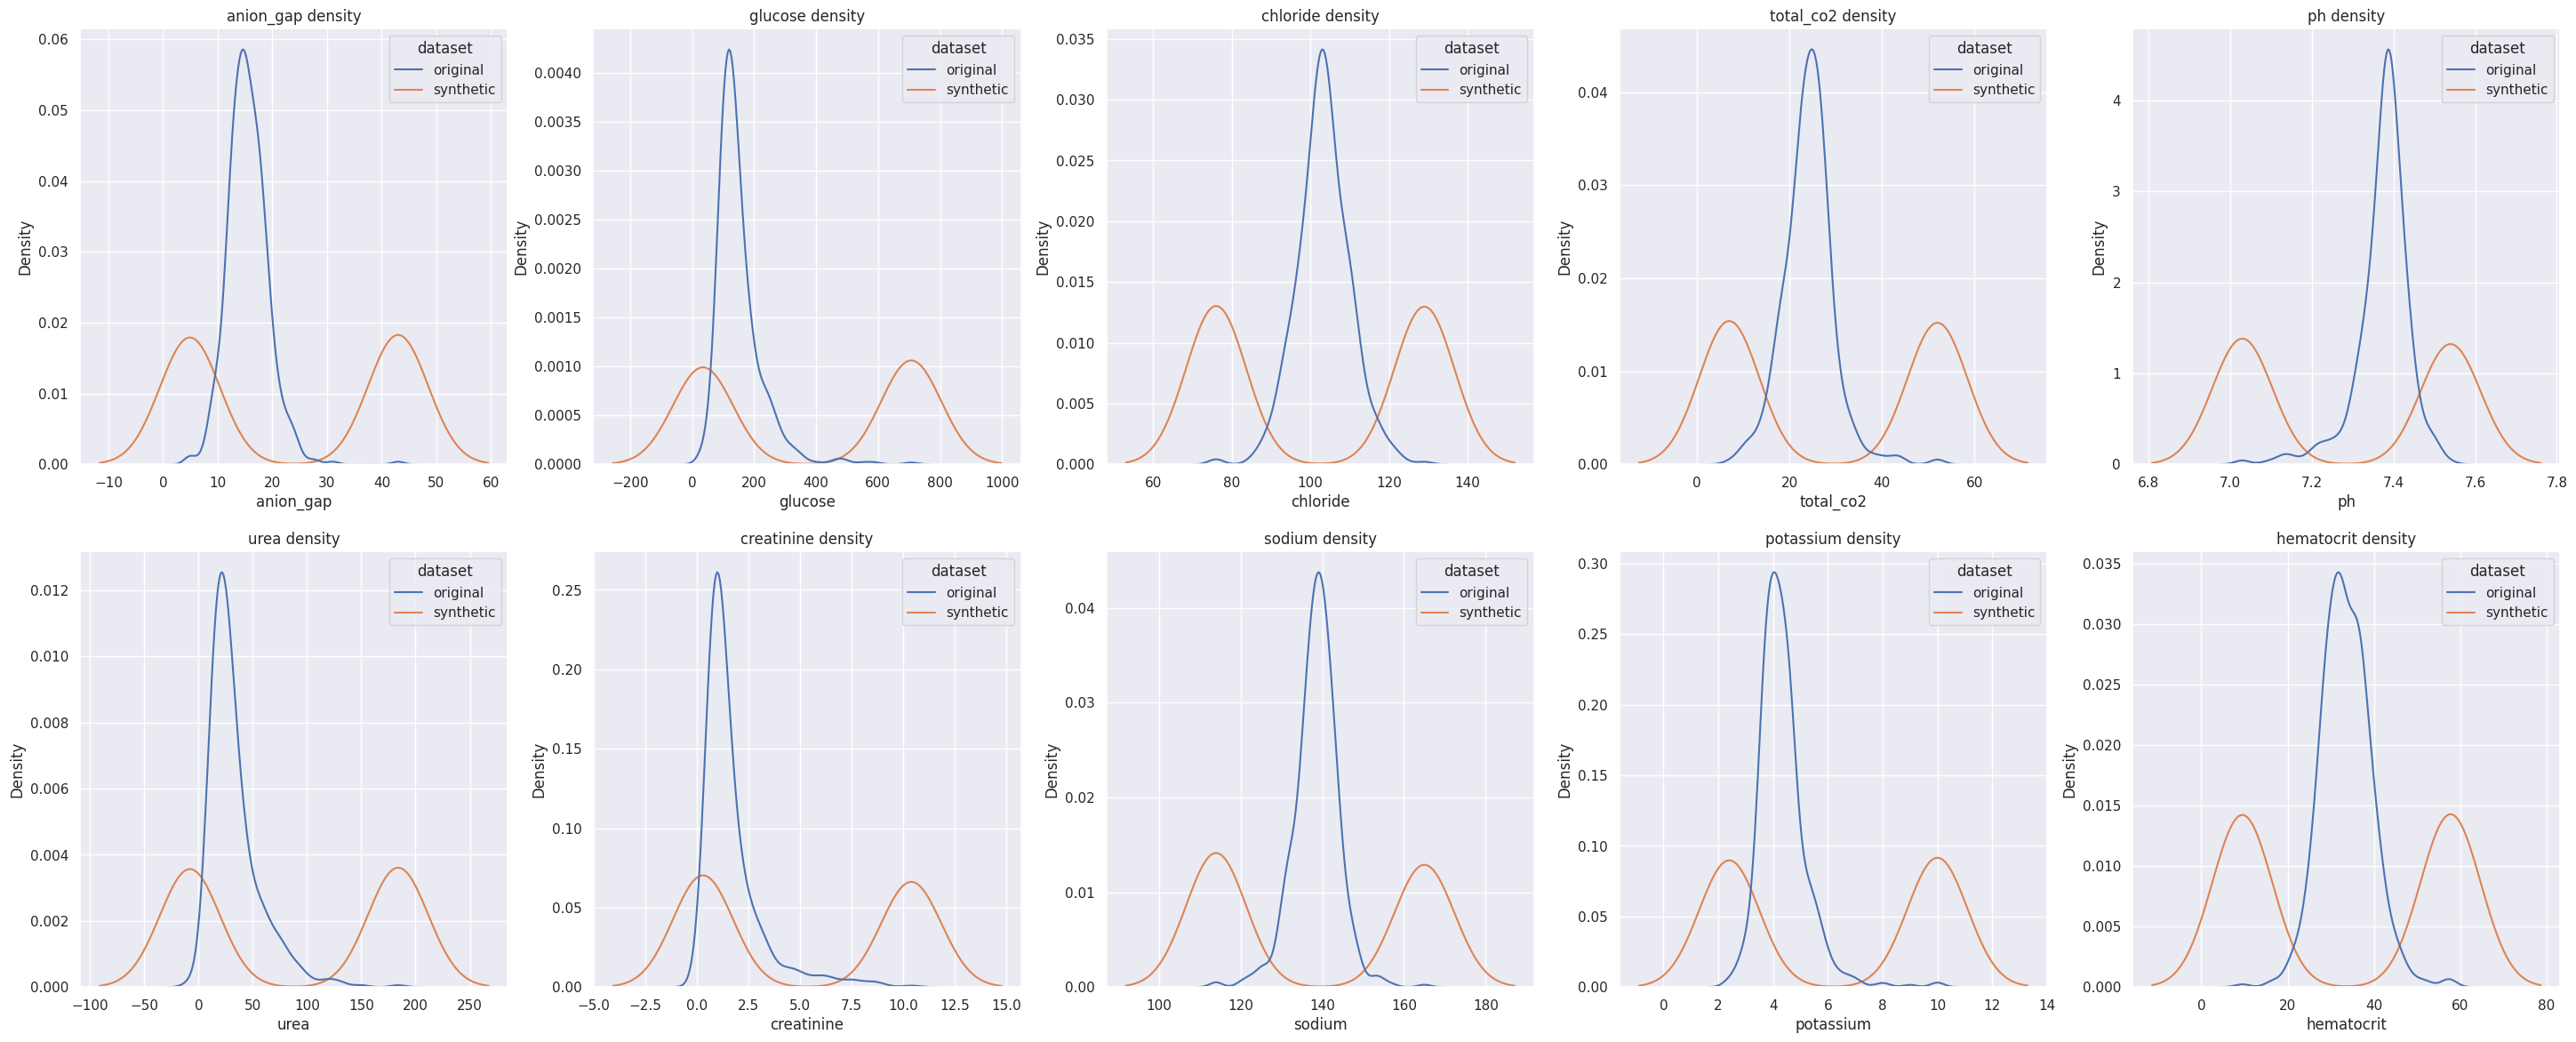

numerical patient stay pdfs for model 3 (underneath):


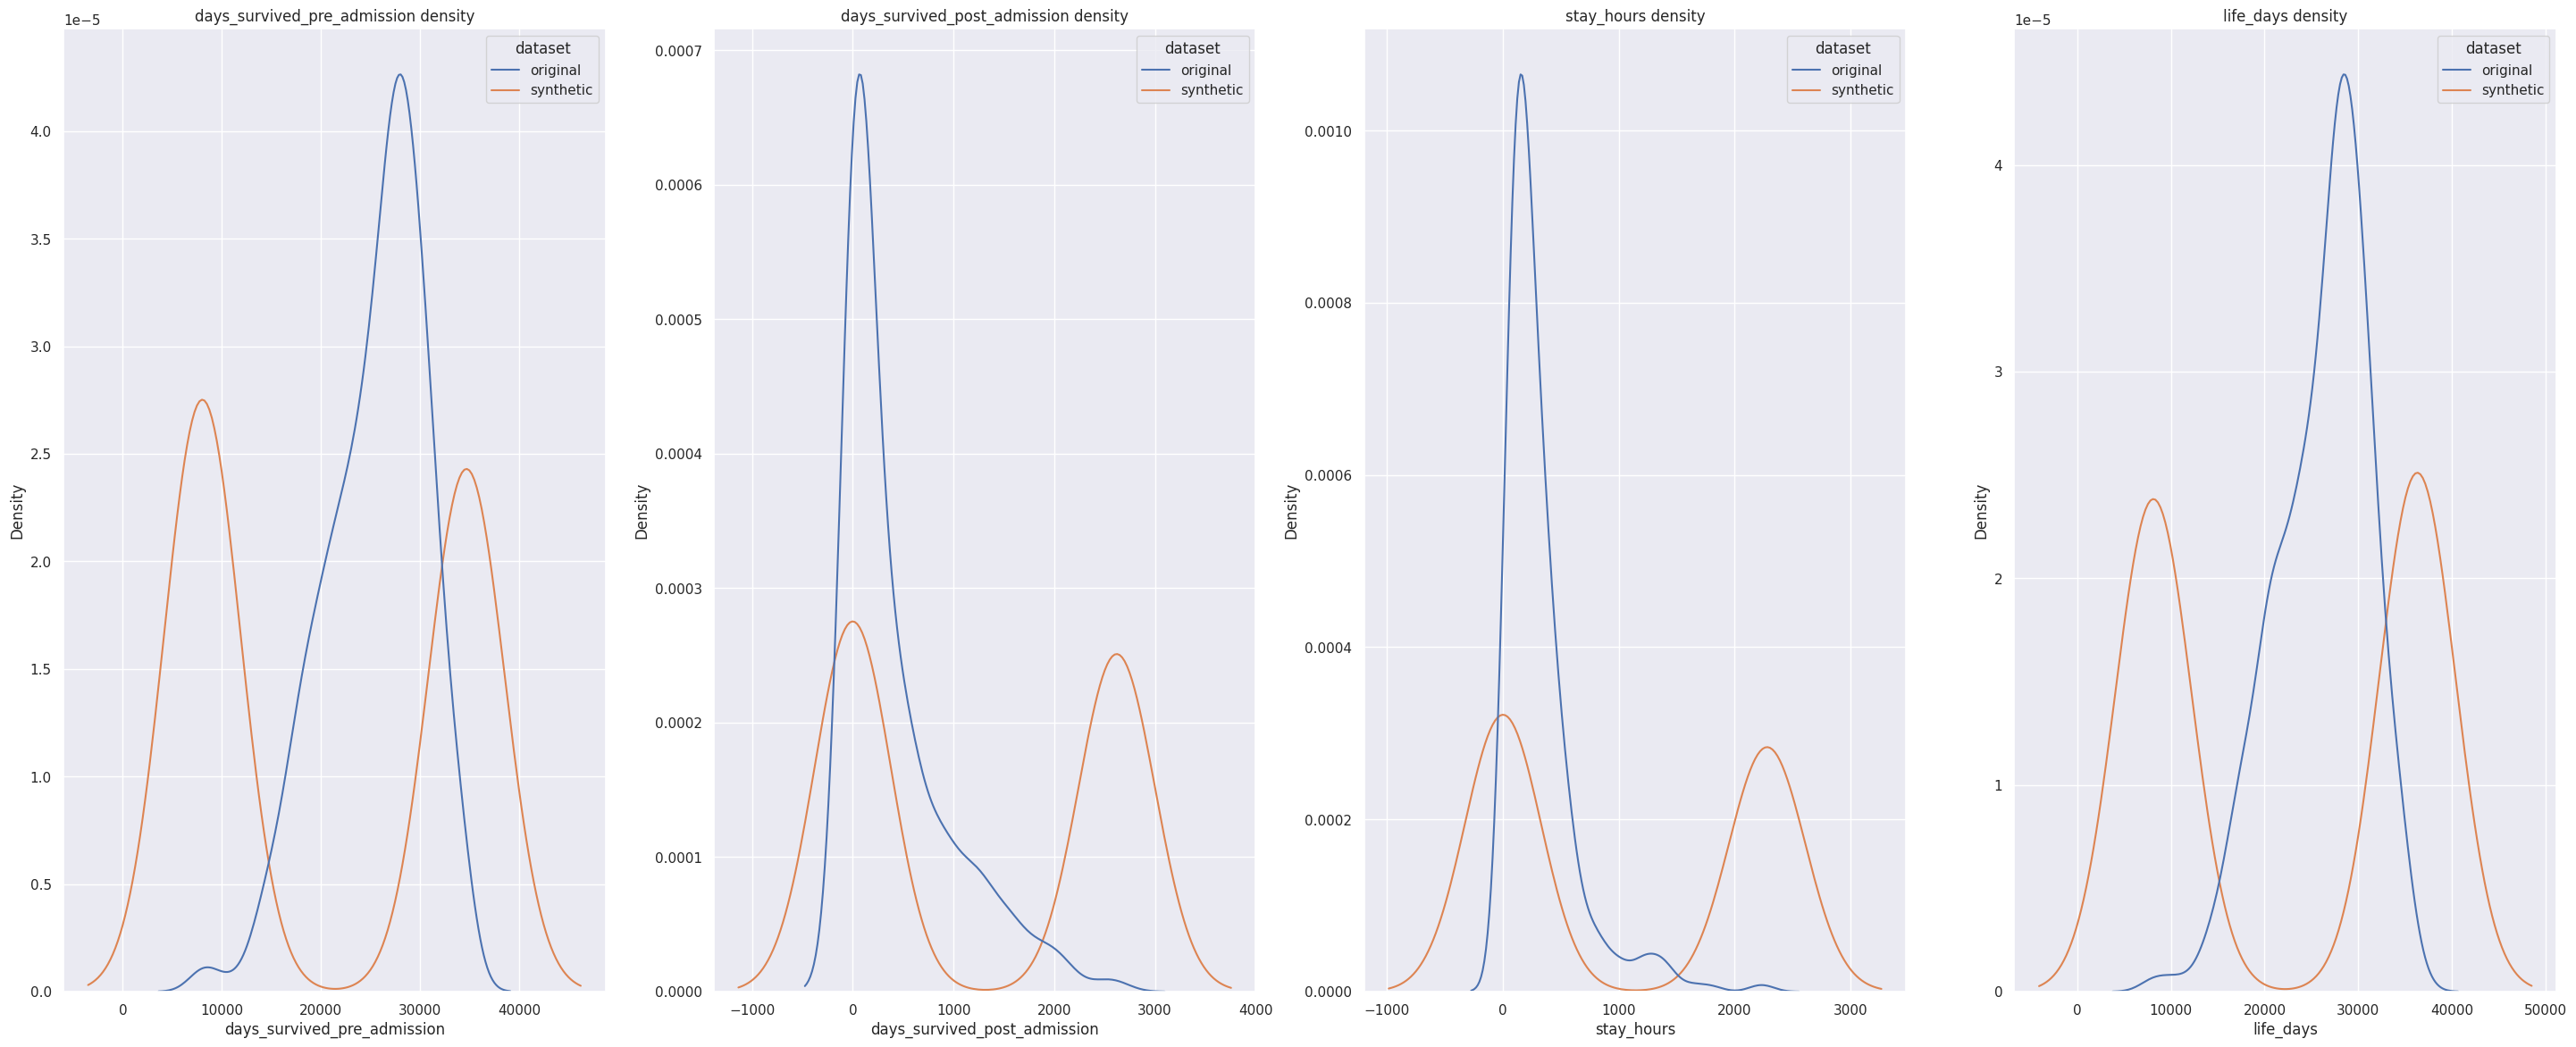

categorical pdfs for model 3 (underneath):


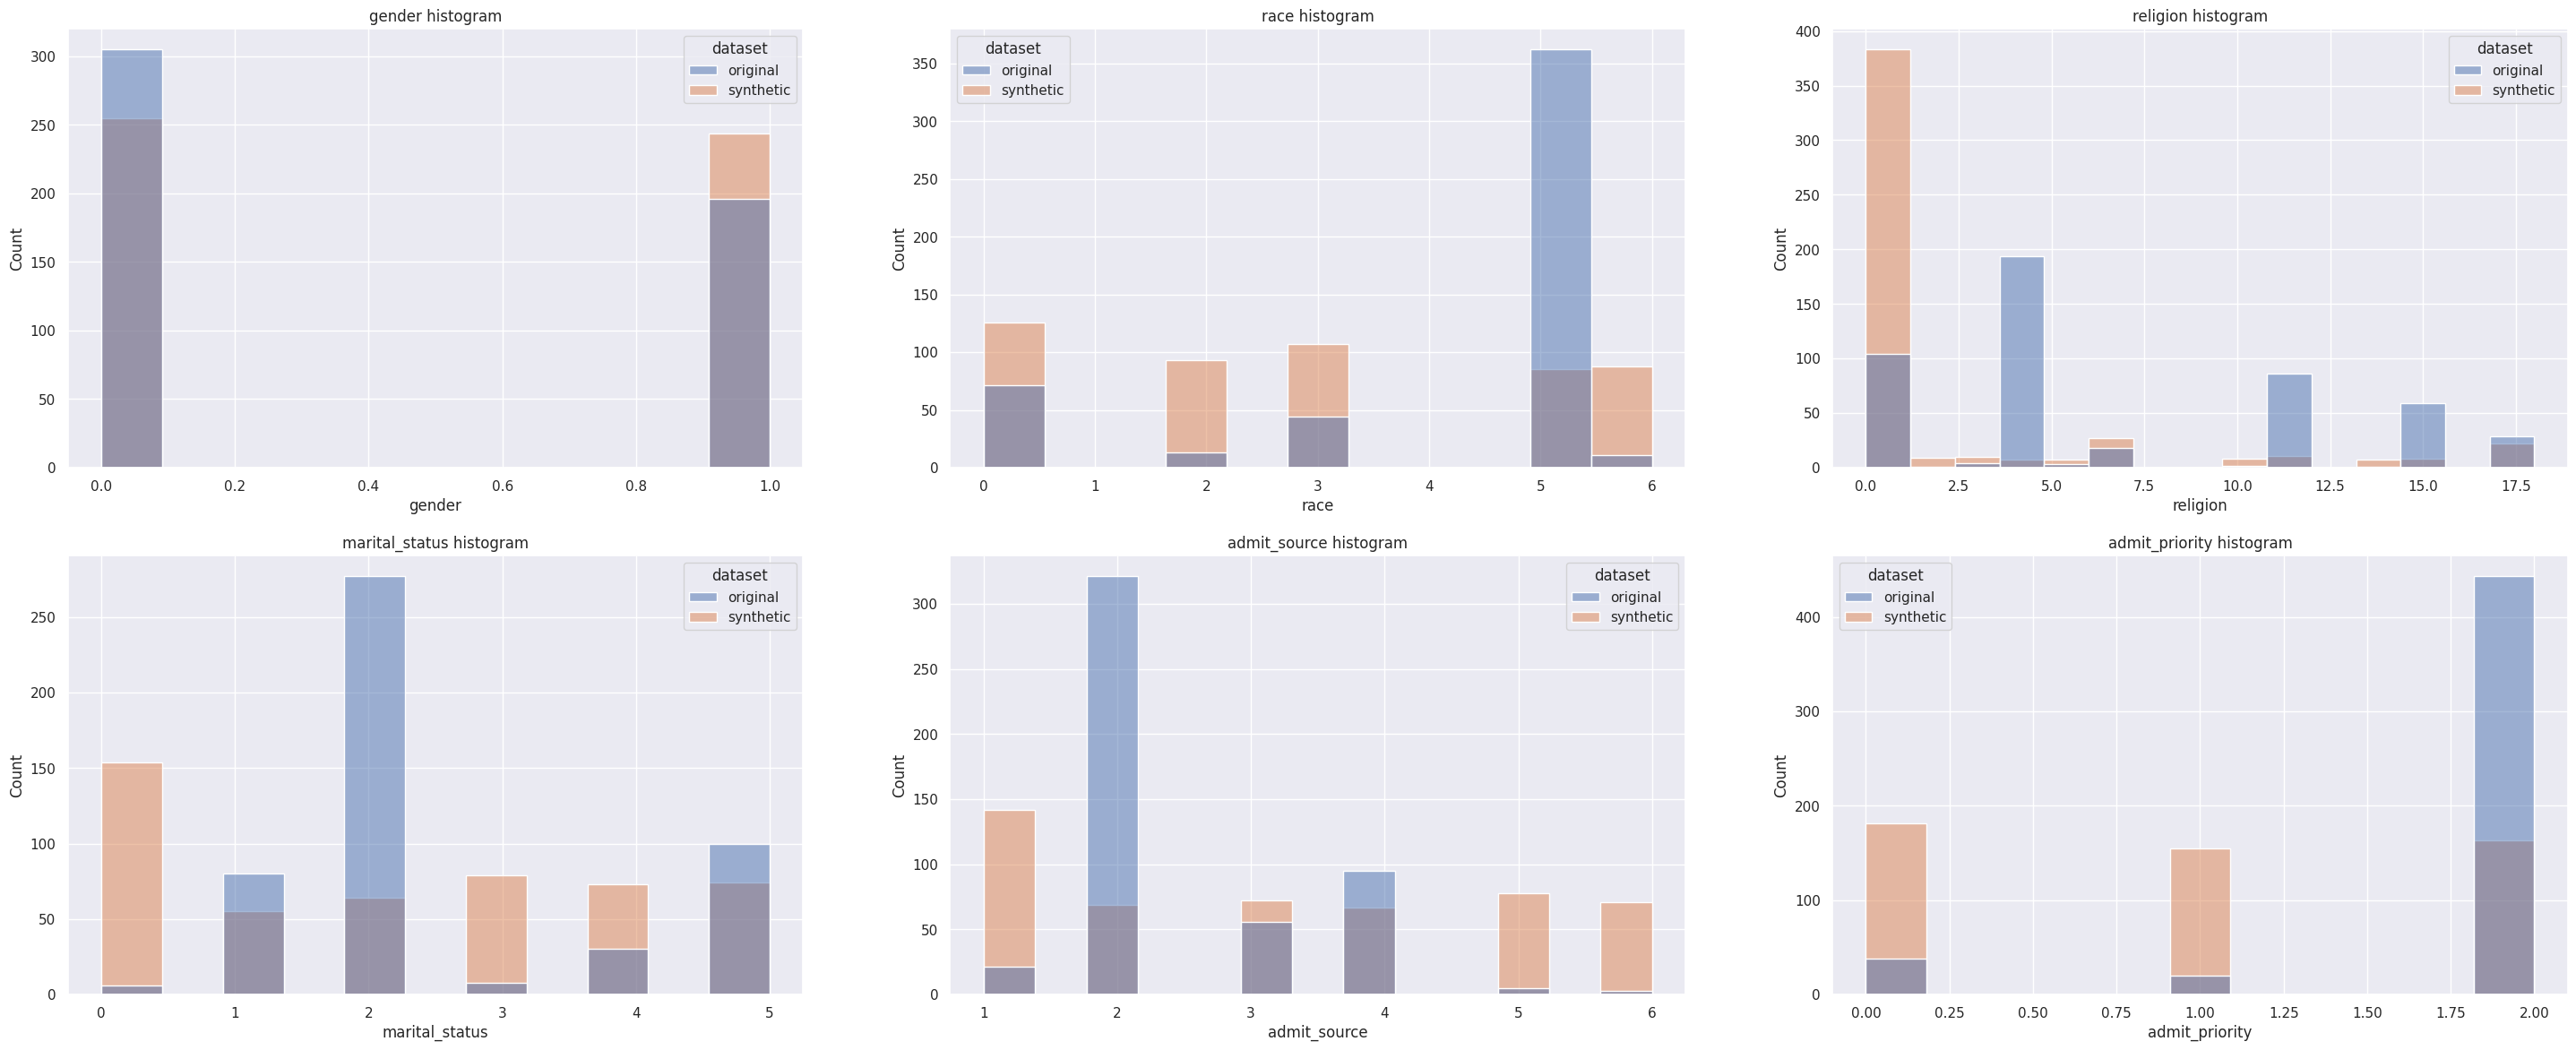

The program has been running for 1607.1833953857422 seconds
we're doing mlp
Running model4....
Running model4....
Running model4....
Number of trainable parameters:  77700
Step 500/10000 MLoss: 0.2615 GLoss: 1.0093 Sum: 1.2708000000000002
Step 1000/10000 MLoss: 0.2656 GLoss: 0.9894 Sum: 1.255
Step 1500/10000 MLoss: 0.2563 GLoss: 1.013 Sum: 1.2692999999999999
Step 2000/10000 MLoss: 0.2478 GLoss: 1.0033 Sum: 1.2511
Step 2500/10000 MLoss: 0.2607 GLoss: 1.0062 Sum: 1.2669
Step 3000/10000 MLoss: 0.2398 GLoss: 1.0109 Sum: 1.2507
Step 3500/10000 MLoss: 0.2425 GLoss: 1.0065 Sum: 1.2489999999999999
Step 4000/10000 MLoss: 0.2325 GLoss: 0.9949 Sum: 1.2274
Step 4500/10000 MLoss: 0.2532 GLoss: 0.9967 Sum: 1.2499
Step 5000/10000 MLoss: 0.2078 GLoss: 1.0159 Sum: 1.2237
Step 5500/10000 MLoss: 0.2084 GLoss: 1.0199 Sum: 1.2283
Step 6000/10000 MLoss: 0.2302 GLoss: 1.0021 Sum: 1.2323
Step 6500/10000 MLoss: 0.213 GLoss: 1.0116 Sum: 1.2246000000000001
Step 7000/10000 MLoss: 0.2217 GLoss: 0.9909 Sum: 1.21260

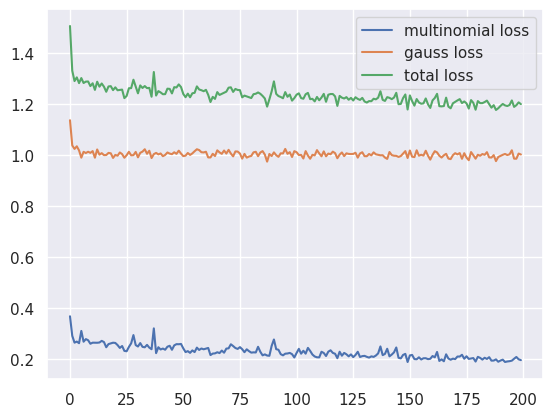

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
plotting matrices for model 4 (underneath):
22.495335239294576


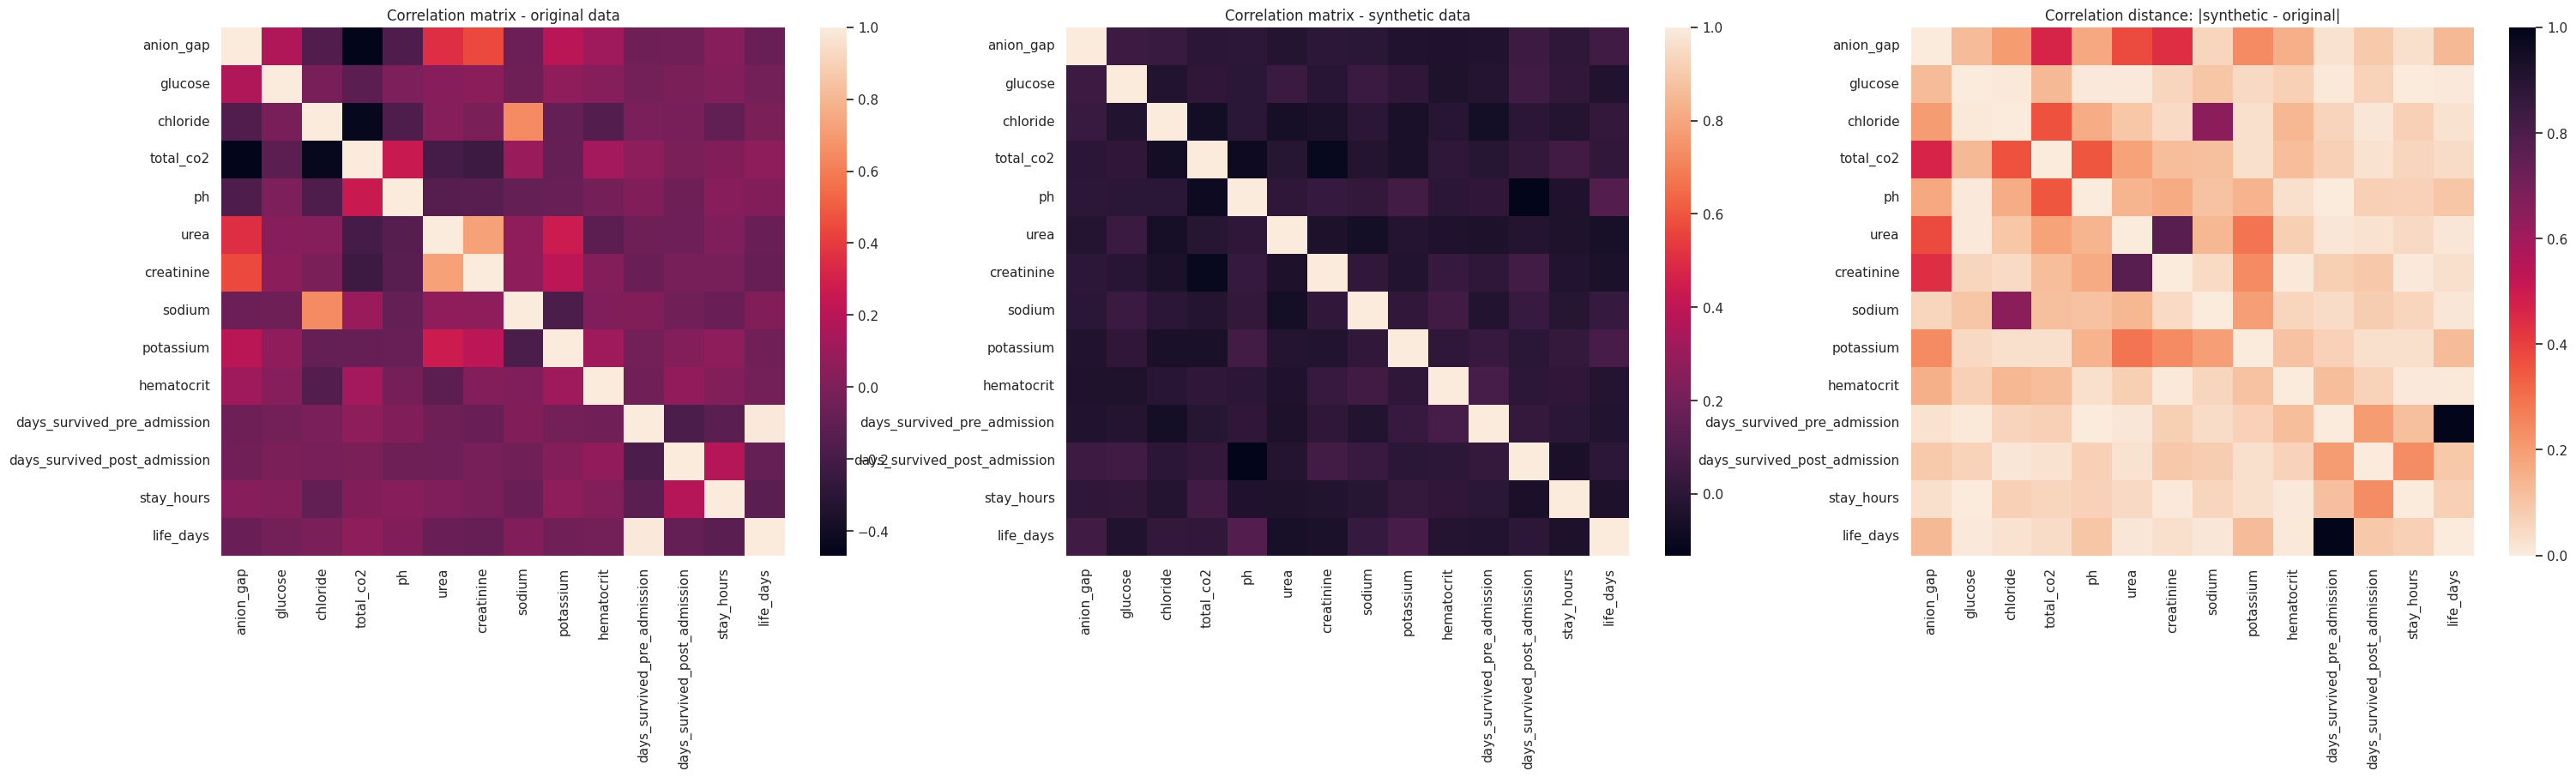

3.8226812188505424


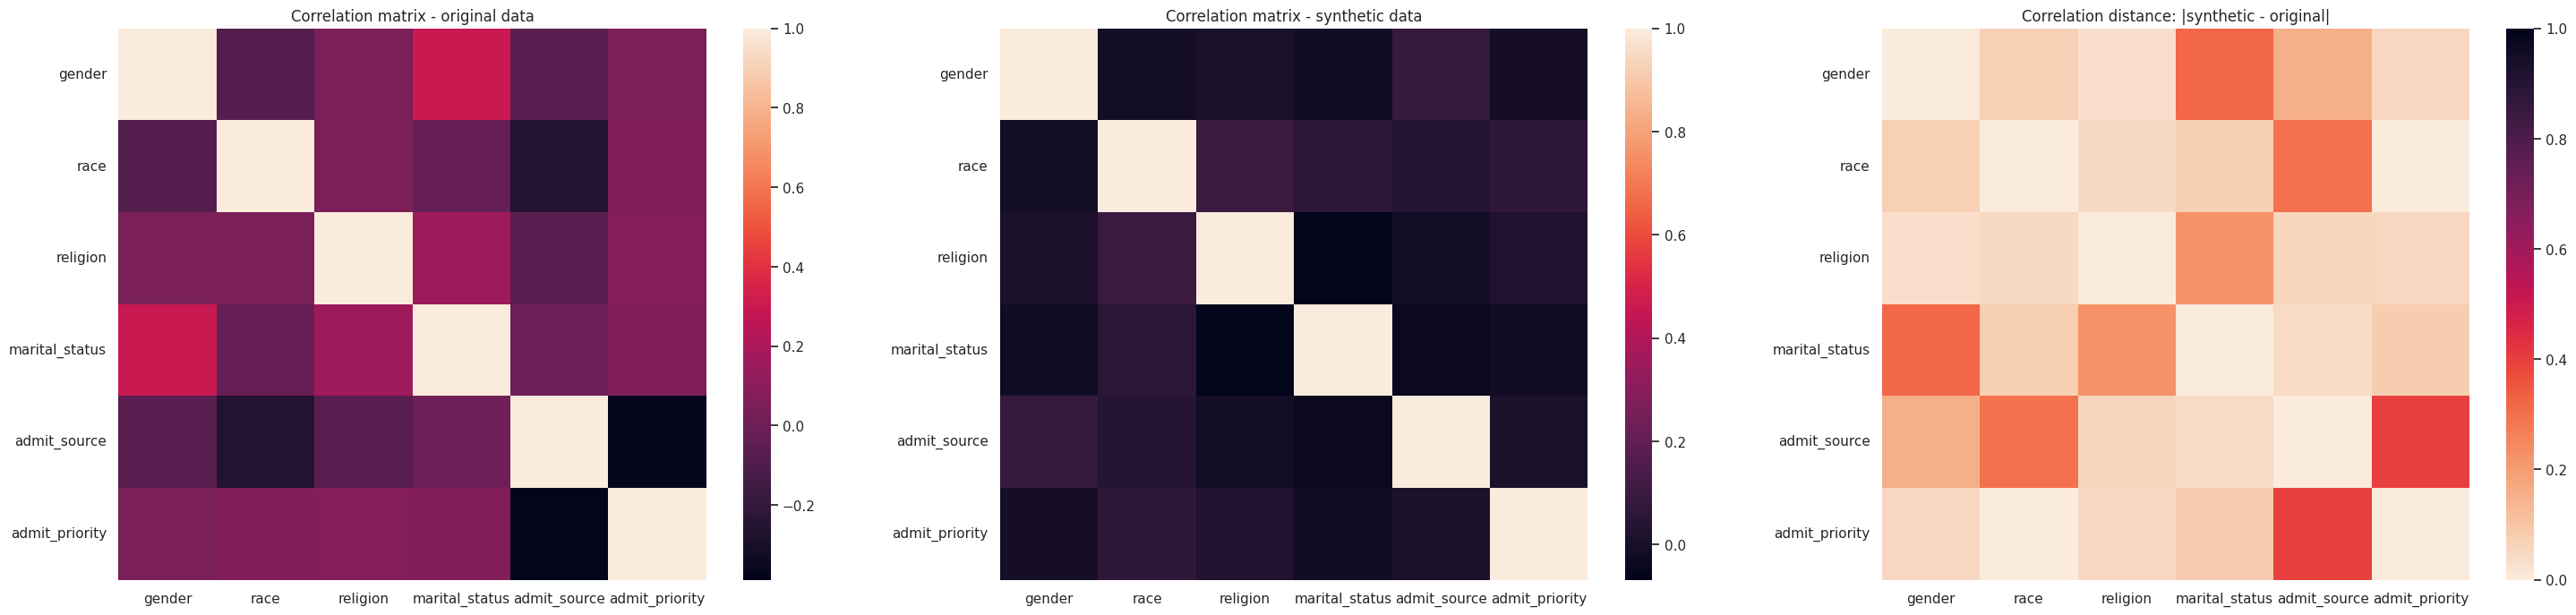

lab pdfs for model 4 (underneath):


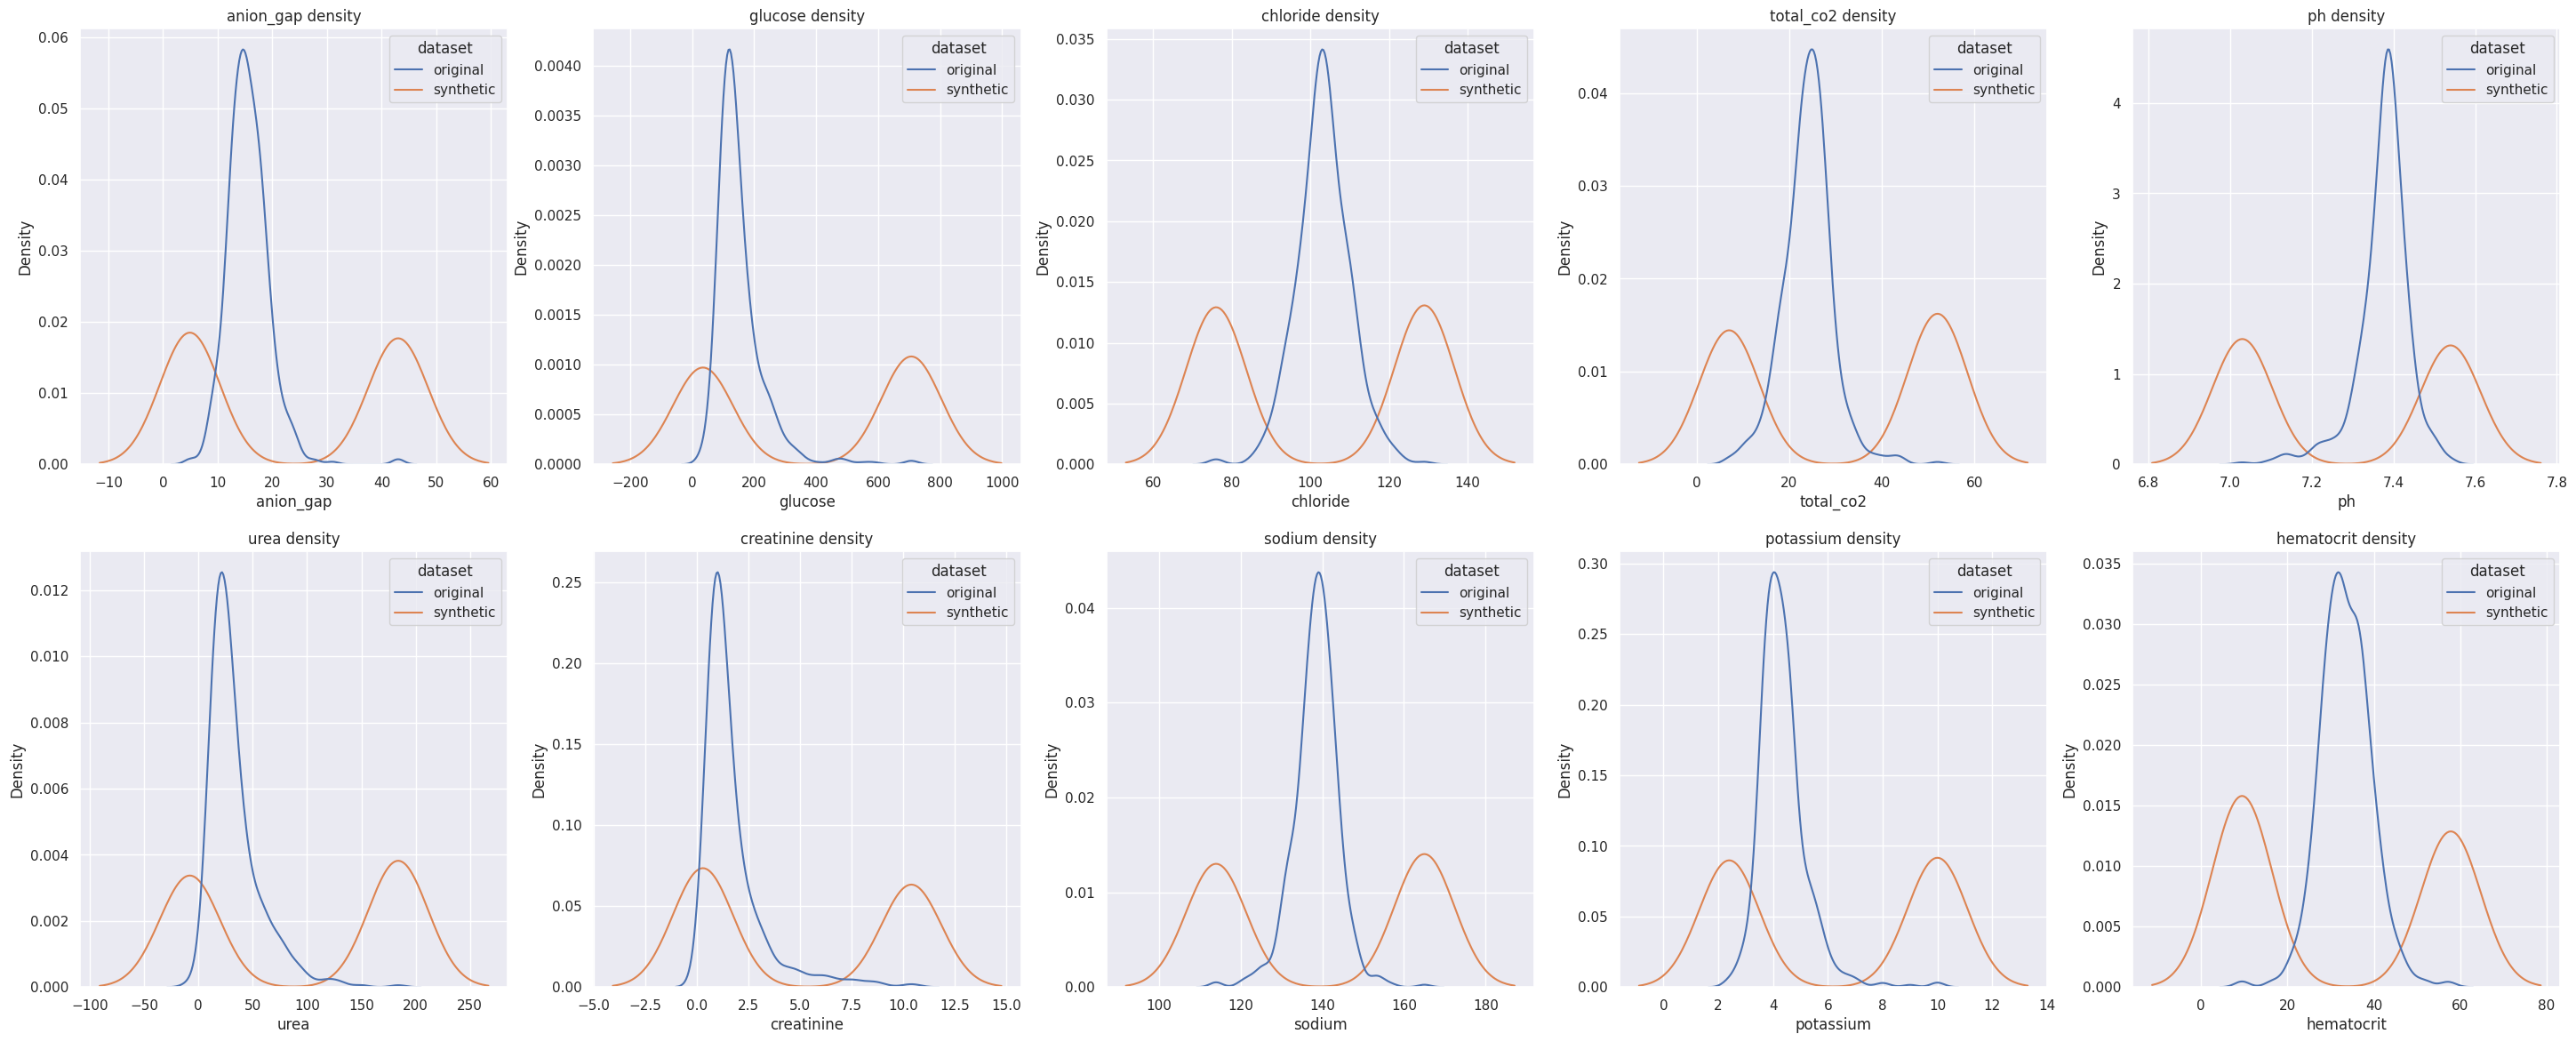

numerical patient stay pdfs for model 4 (underneath):


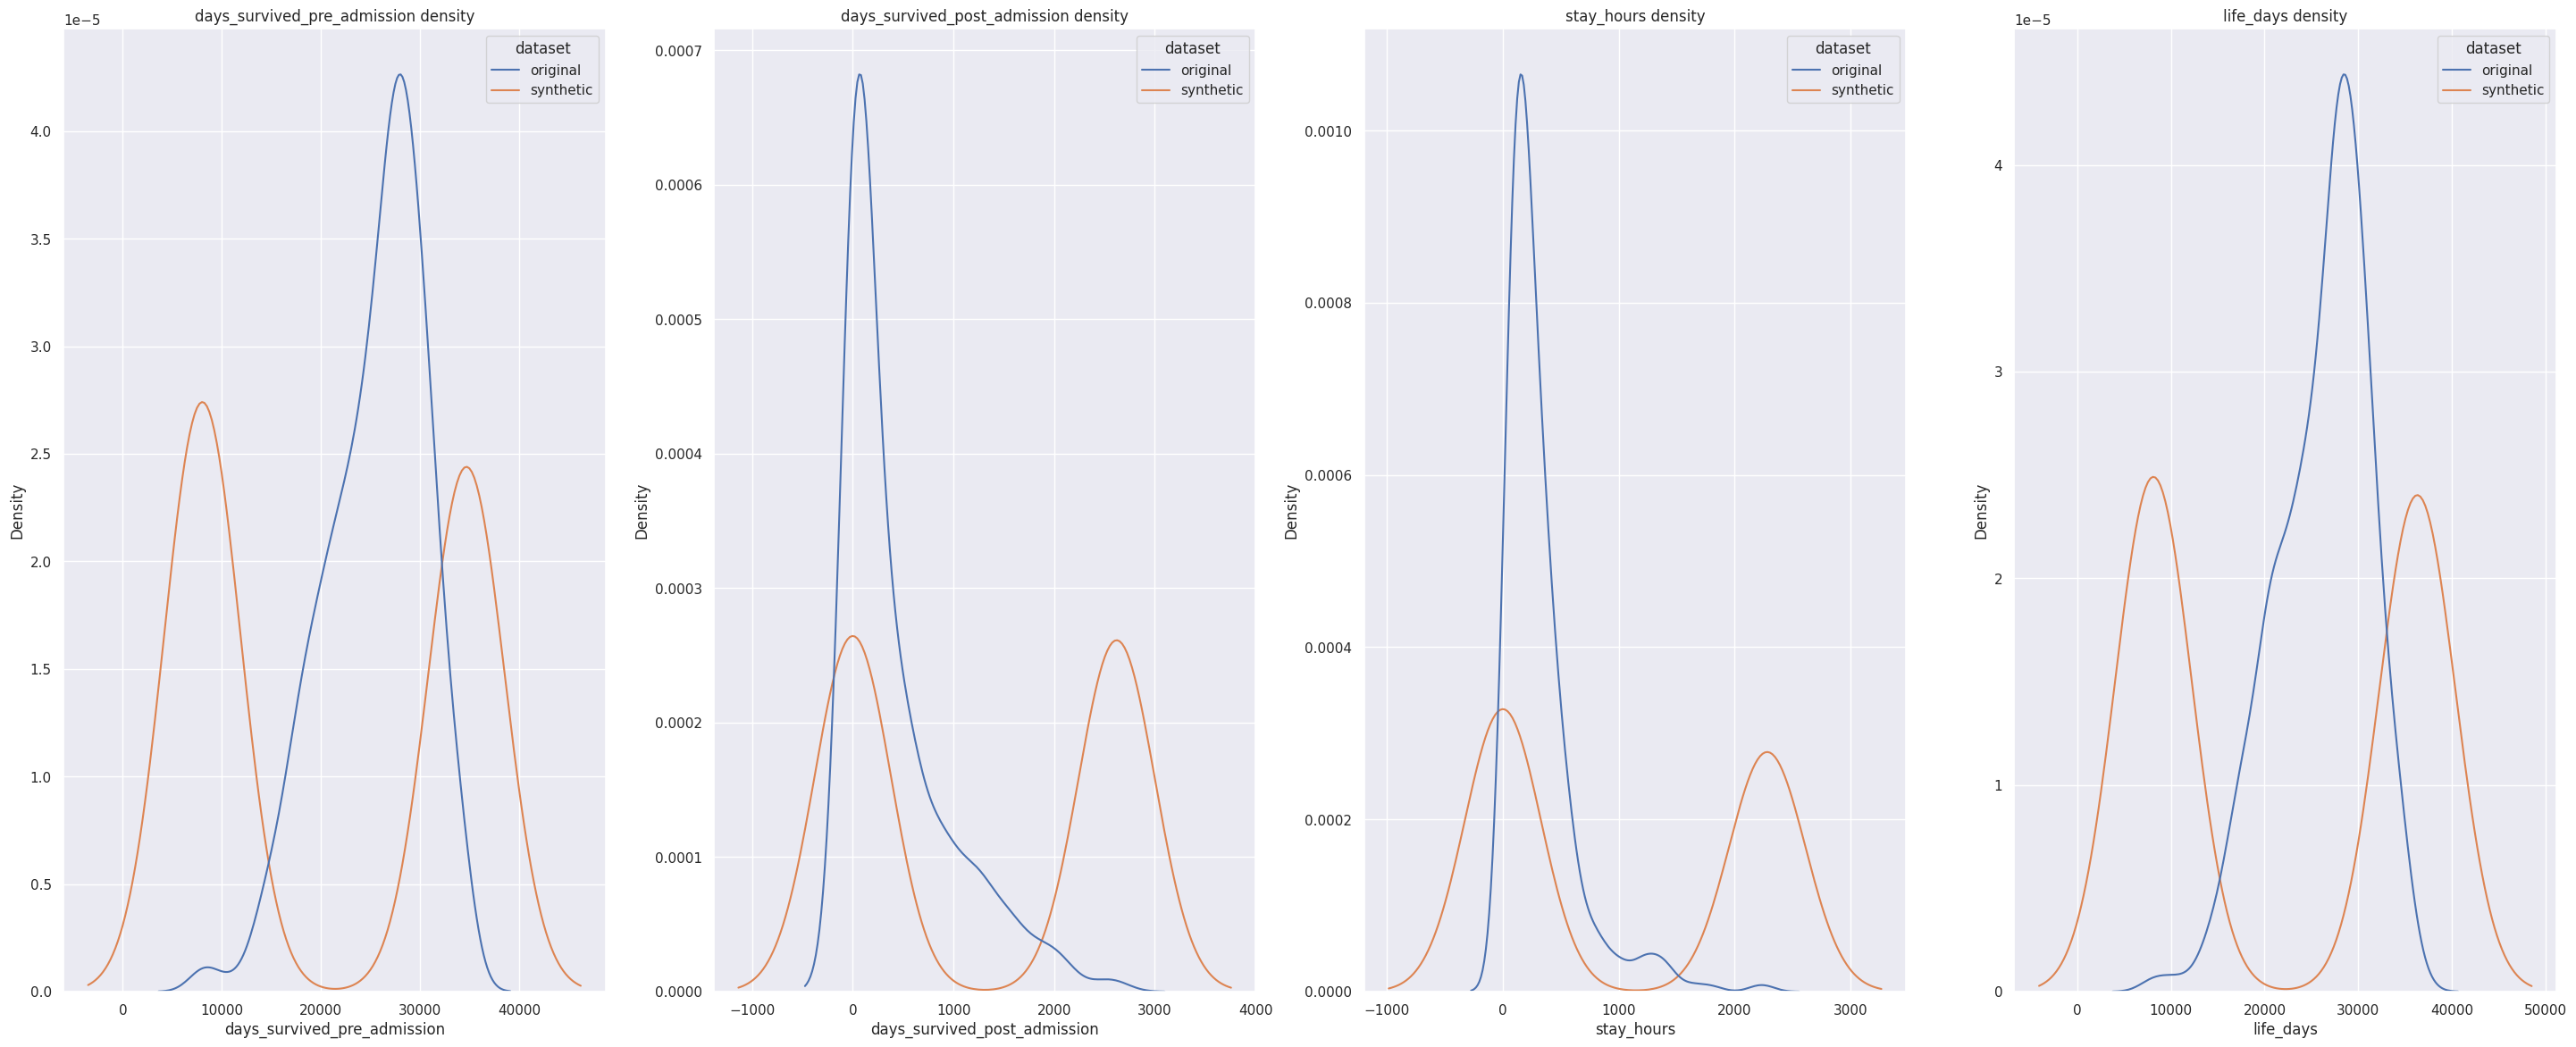

categorical pdfs for model 4 (underneath):


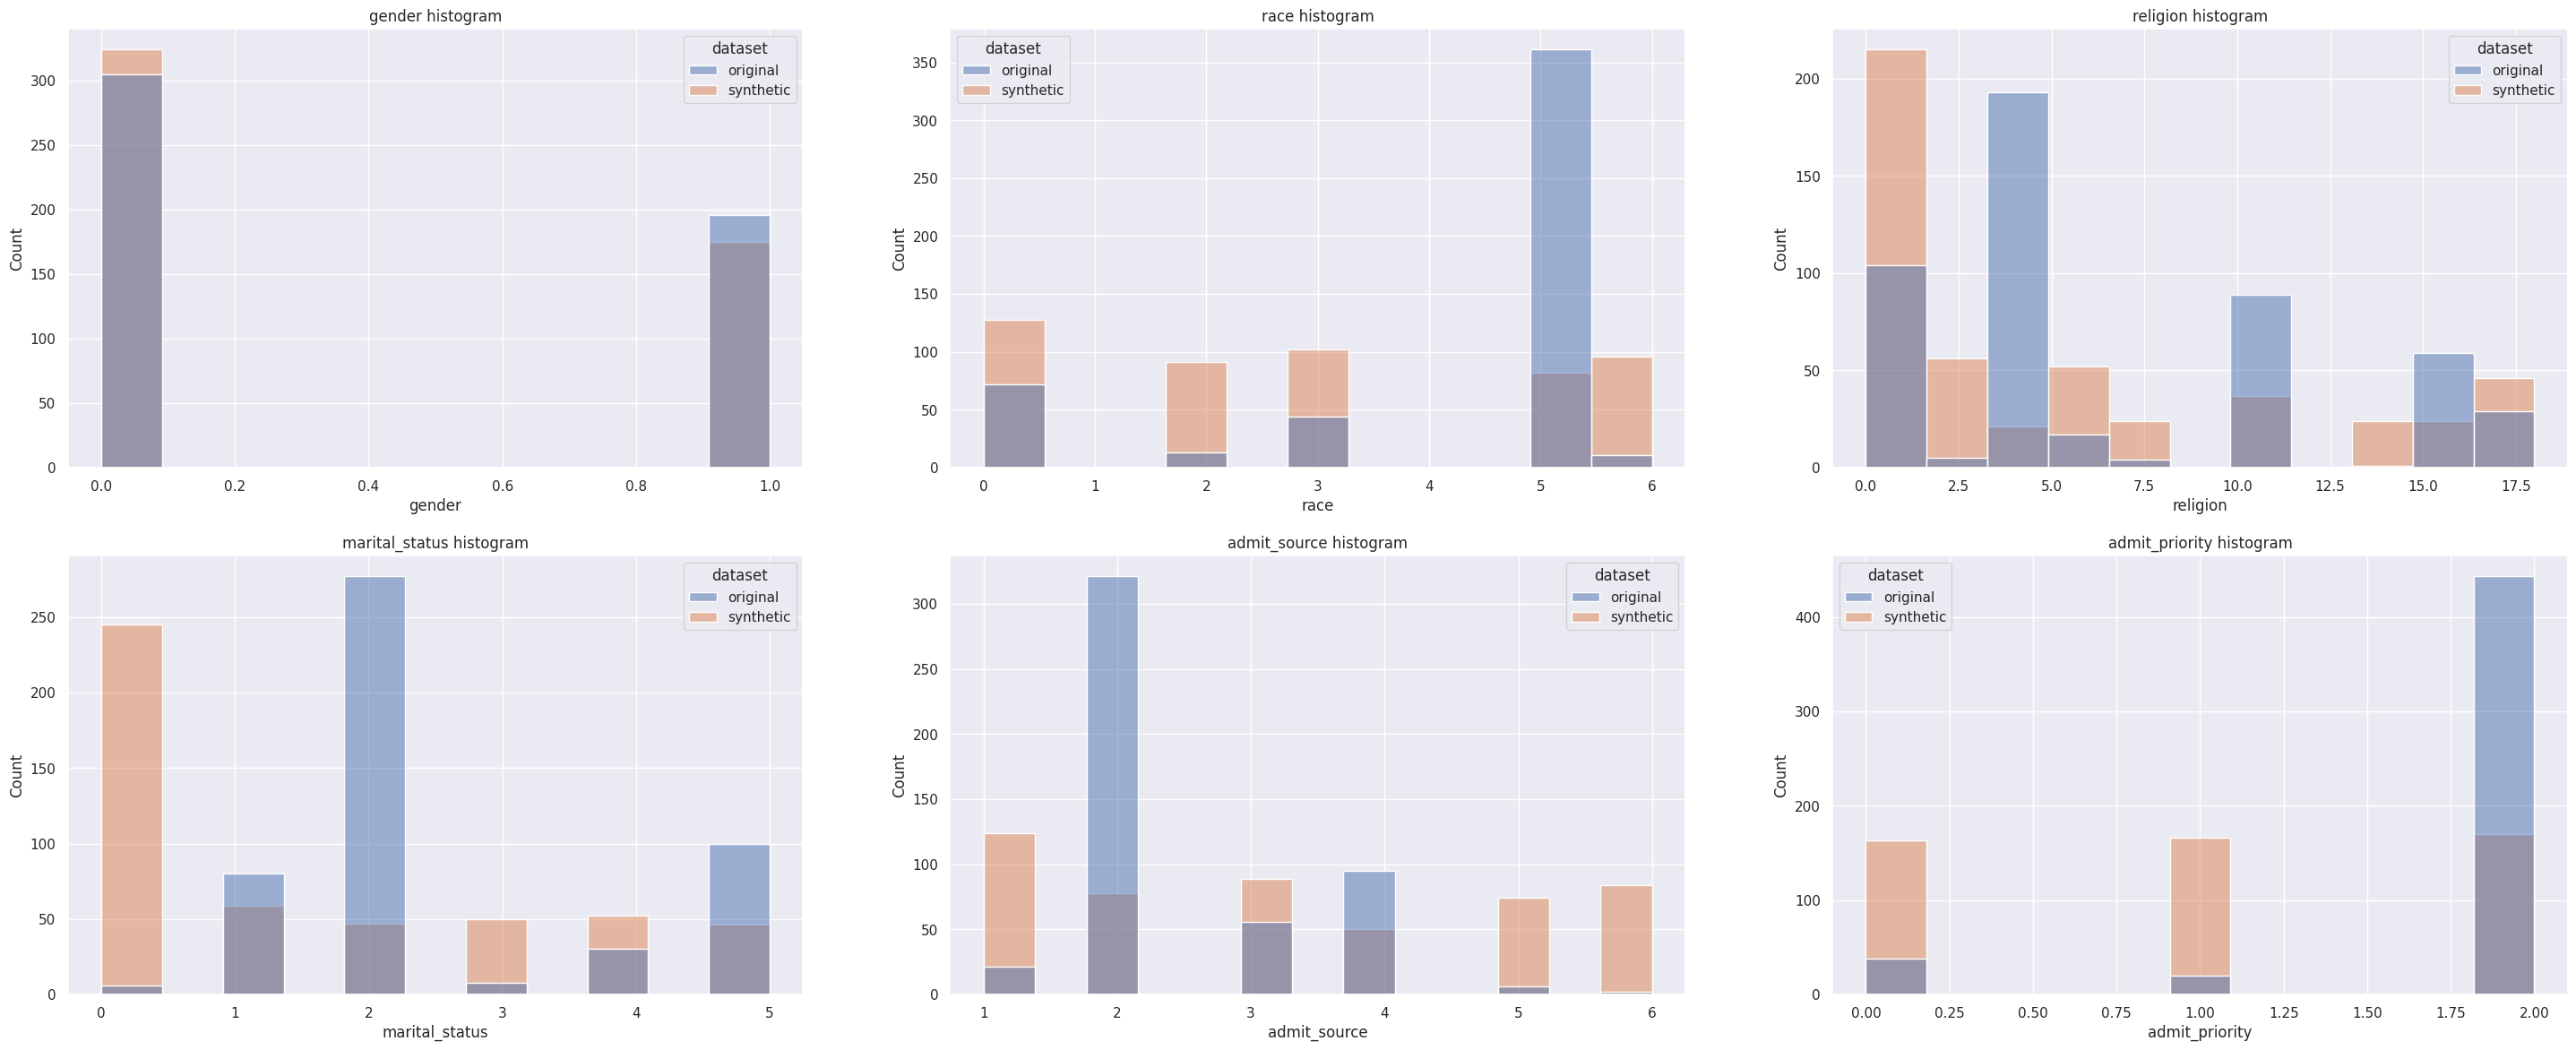

The program has been running for 2121.8226447105408 seconds
we're doing mlp
Running model5....
Running model5....
Running model5....
Number of trainable parameters:  29124
Step 500/10000 MLoss: 0.274 GLoss: 1.0078 Sum: 1.2818
Step 1000/10000 MLoss: 0.2658 GLoss: 1.0033 Sum: 1.2691000000000001
Step 1500/10000 MLoss: 0.2848 GLoss: 0.9963 Sum: 1.2811
Step 2000/10000 MLoss: 0.2785 GLoss: 1.0013 Sum: 1.2798
Step 2500/10000 MLoss: 0.2619 GLoss: 1.0096 Sum: 1.2715
Step 3000/10000 MLoss: 0.2841 GLoss: 1.0048 Sum: 1.2889
Step 3500/10000 MLoss: 0.2585 GLoss: 0.9711 Sum: 1.2296
Step 4000/10000 MLoss: 0.2796 GLoss: 1.0004 Sum: 1.28
Step 4500/10000 MLoss: 0.2589 GLoss: 1.0117 Sum: 1.2706
Step 5000/10000 MLoss: 0.2713 GLoss: 0.9965 Sum: 1.2678
Step 5500/10000 MLoss: 0.2732 GLoss: 1.0075 Sum: 1.2807
Step 6000/10000 MLoss: 0.2496 GLoss: 0.982 Sum: 1.2316
Step 6500/10000 MLoss: 0.2619 GLoss: 0.9888 Sum: 1.2507000000000001
Step 7000/10000 MLoss: 0.2864 GLoss: 1.0117 Sum: 1.2981
Step 7500/10000 MLoss: 0.

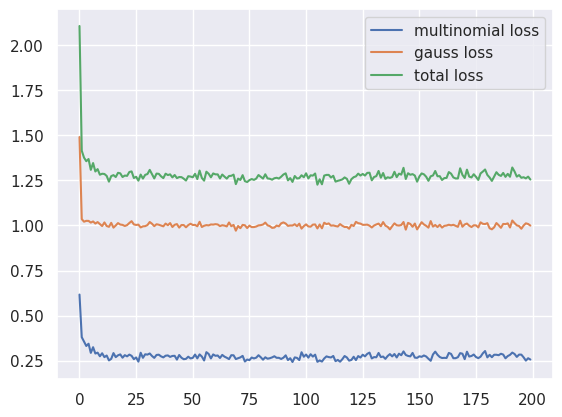

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0

Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0
plotting matrices for model 5 (underneath):
22.991217380274755


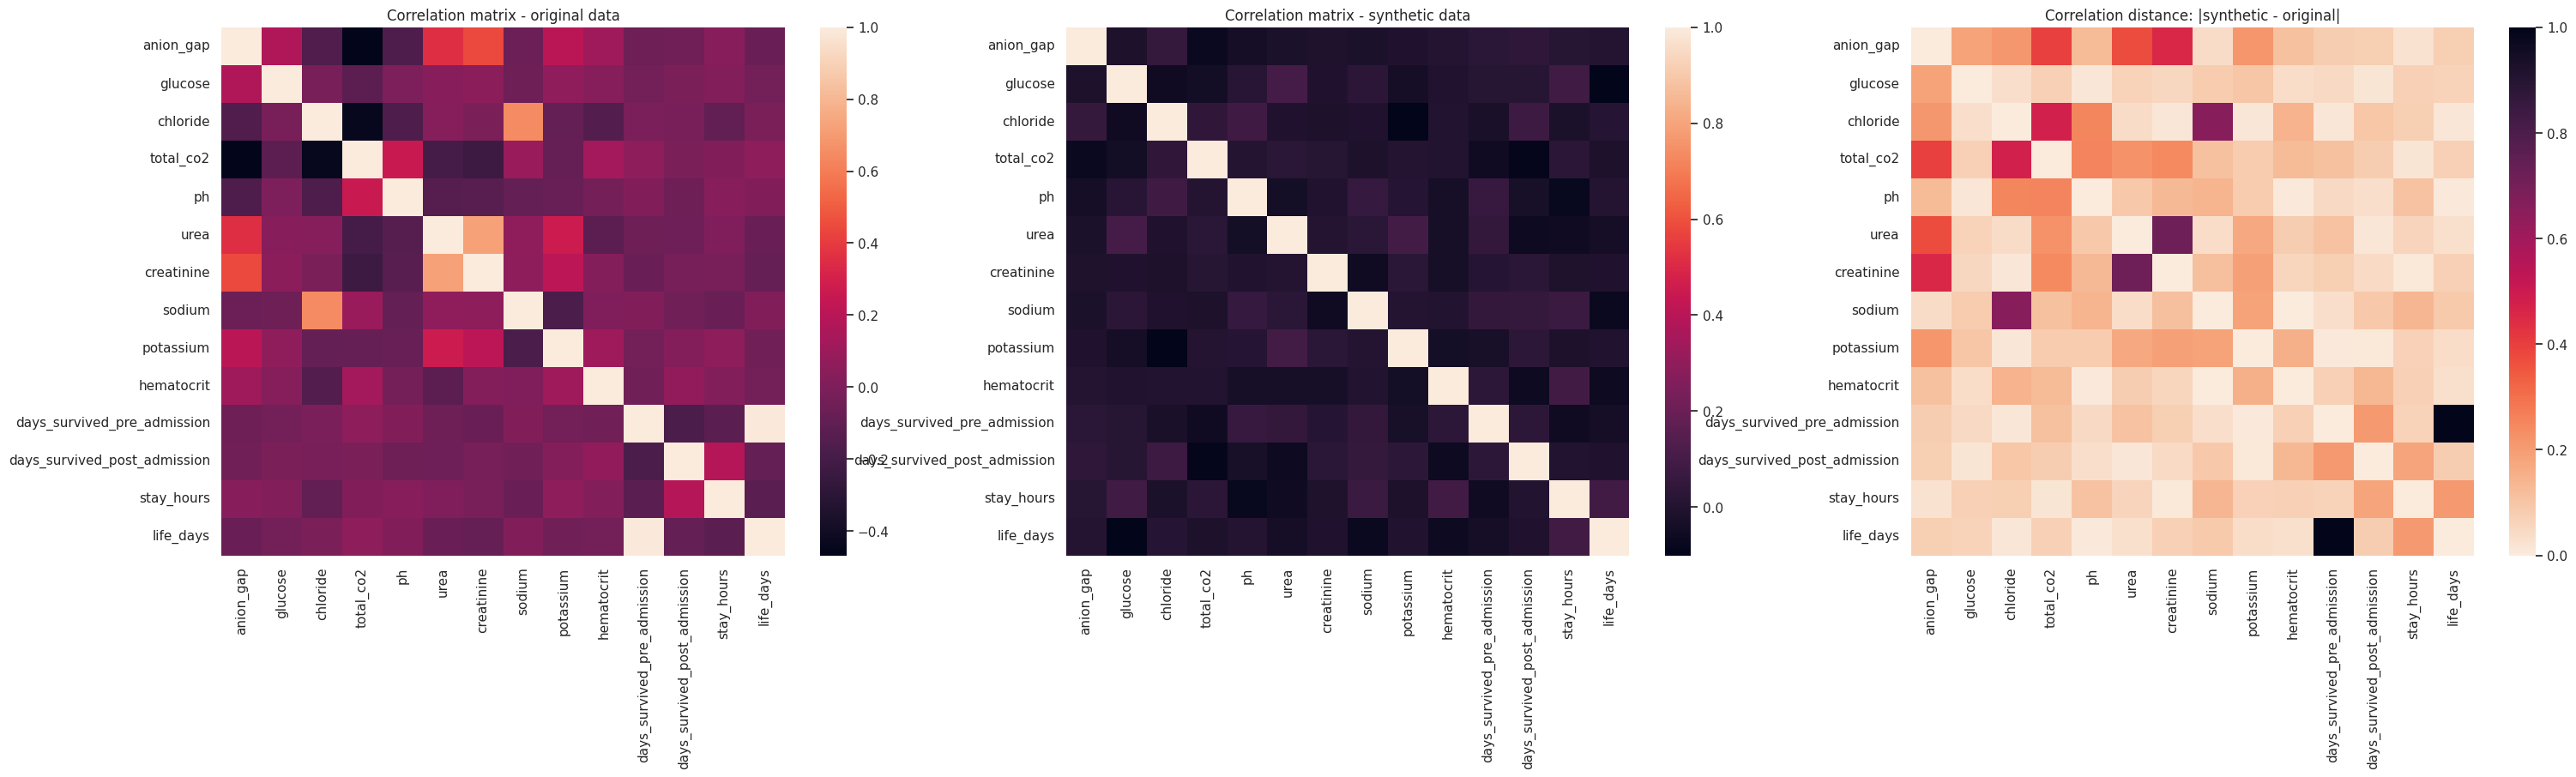

3.2340798114013447


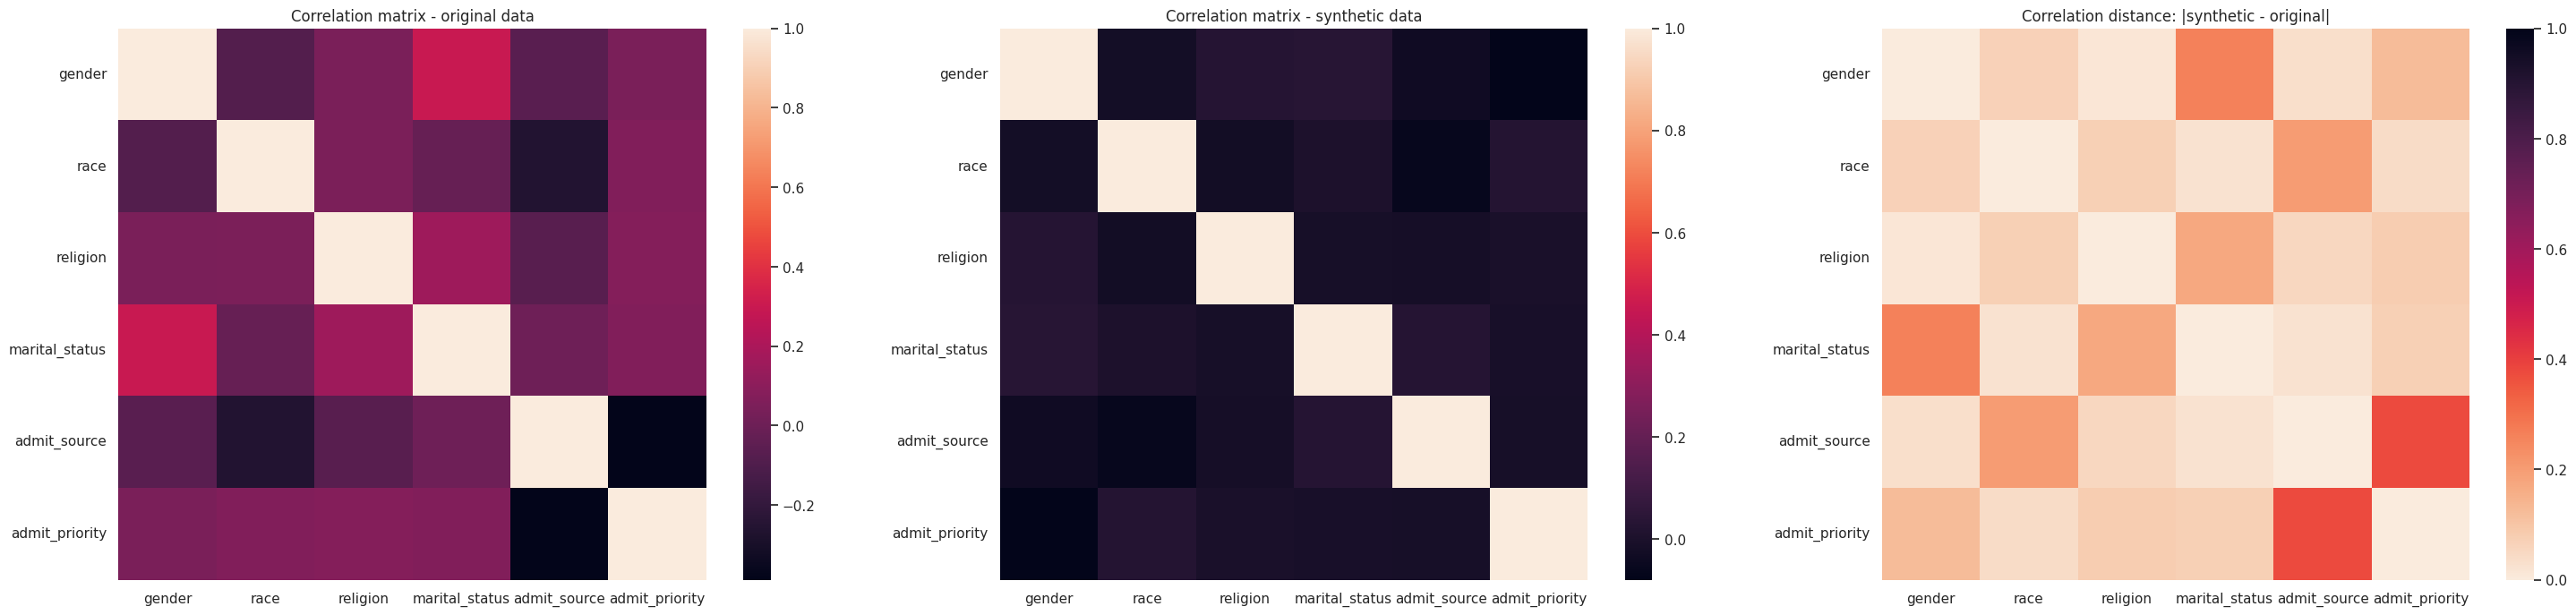

lab pdfs for model 5 (underneath):


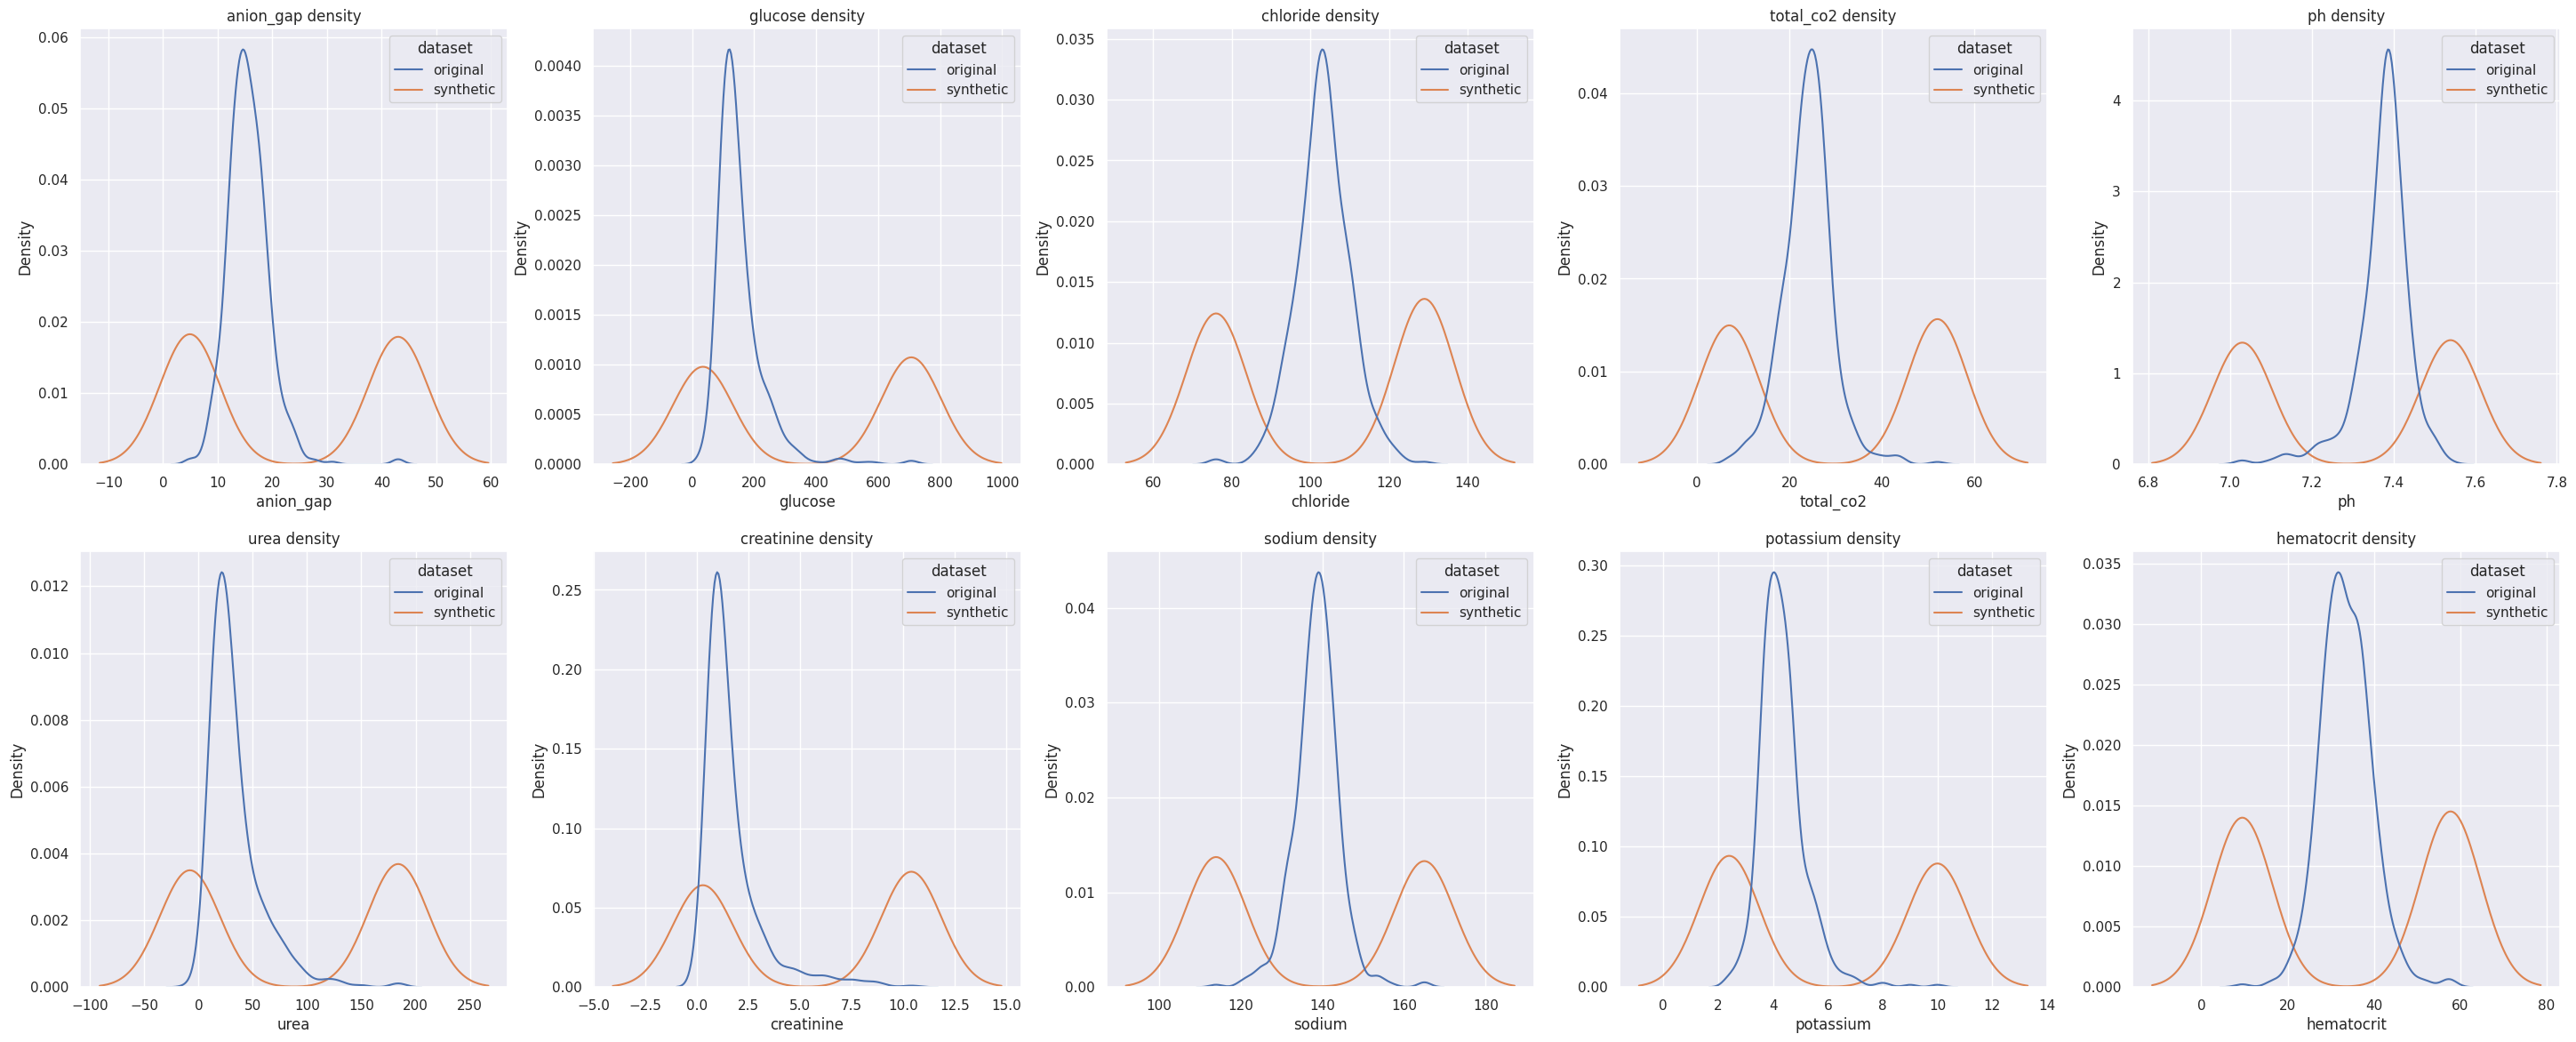

numerical patient stay pdfs for model 5 (underneath):


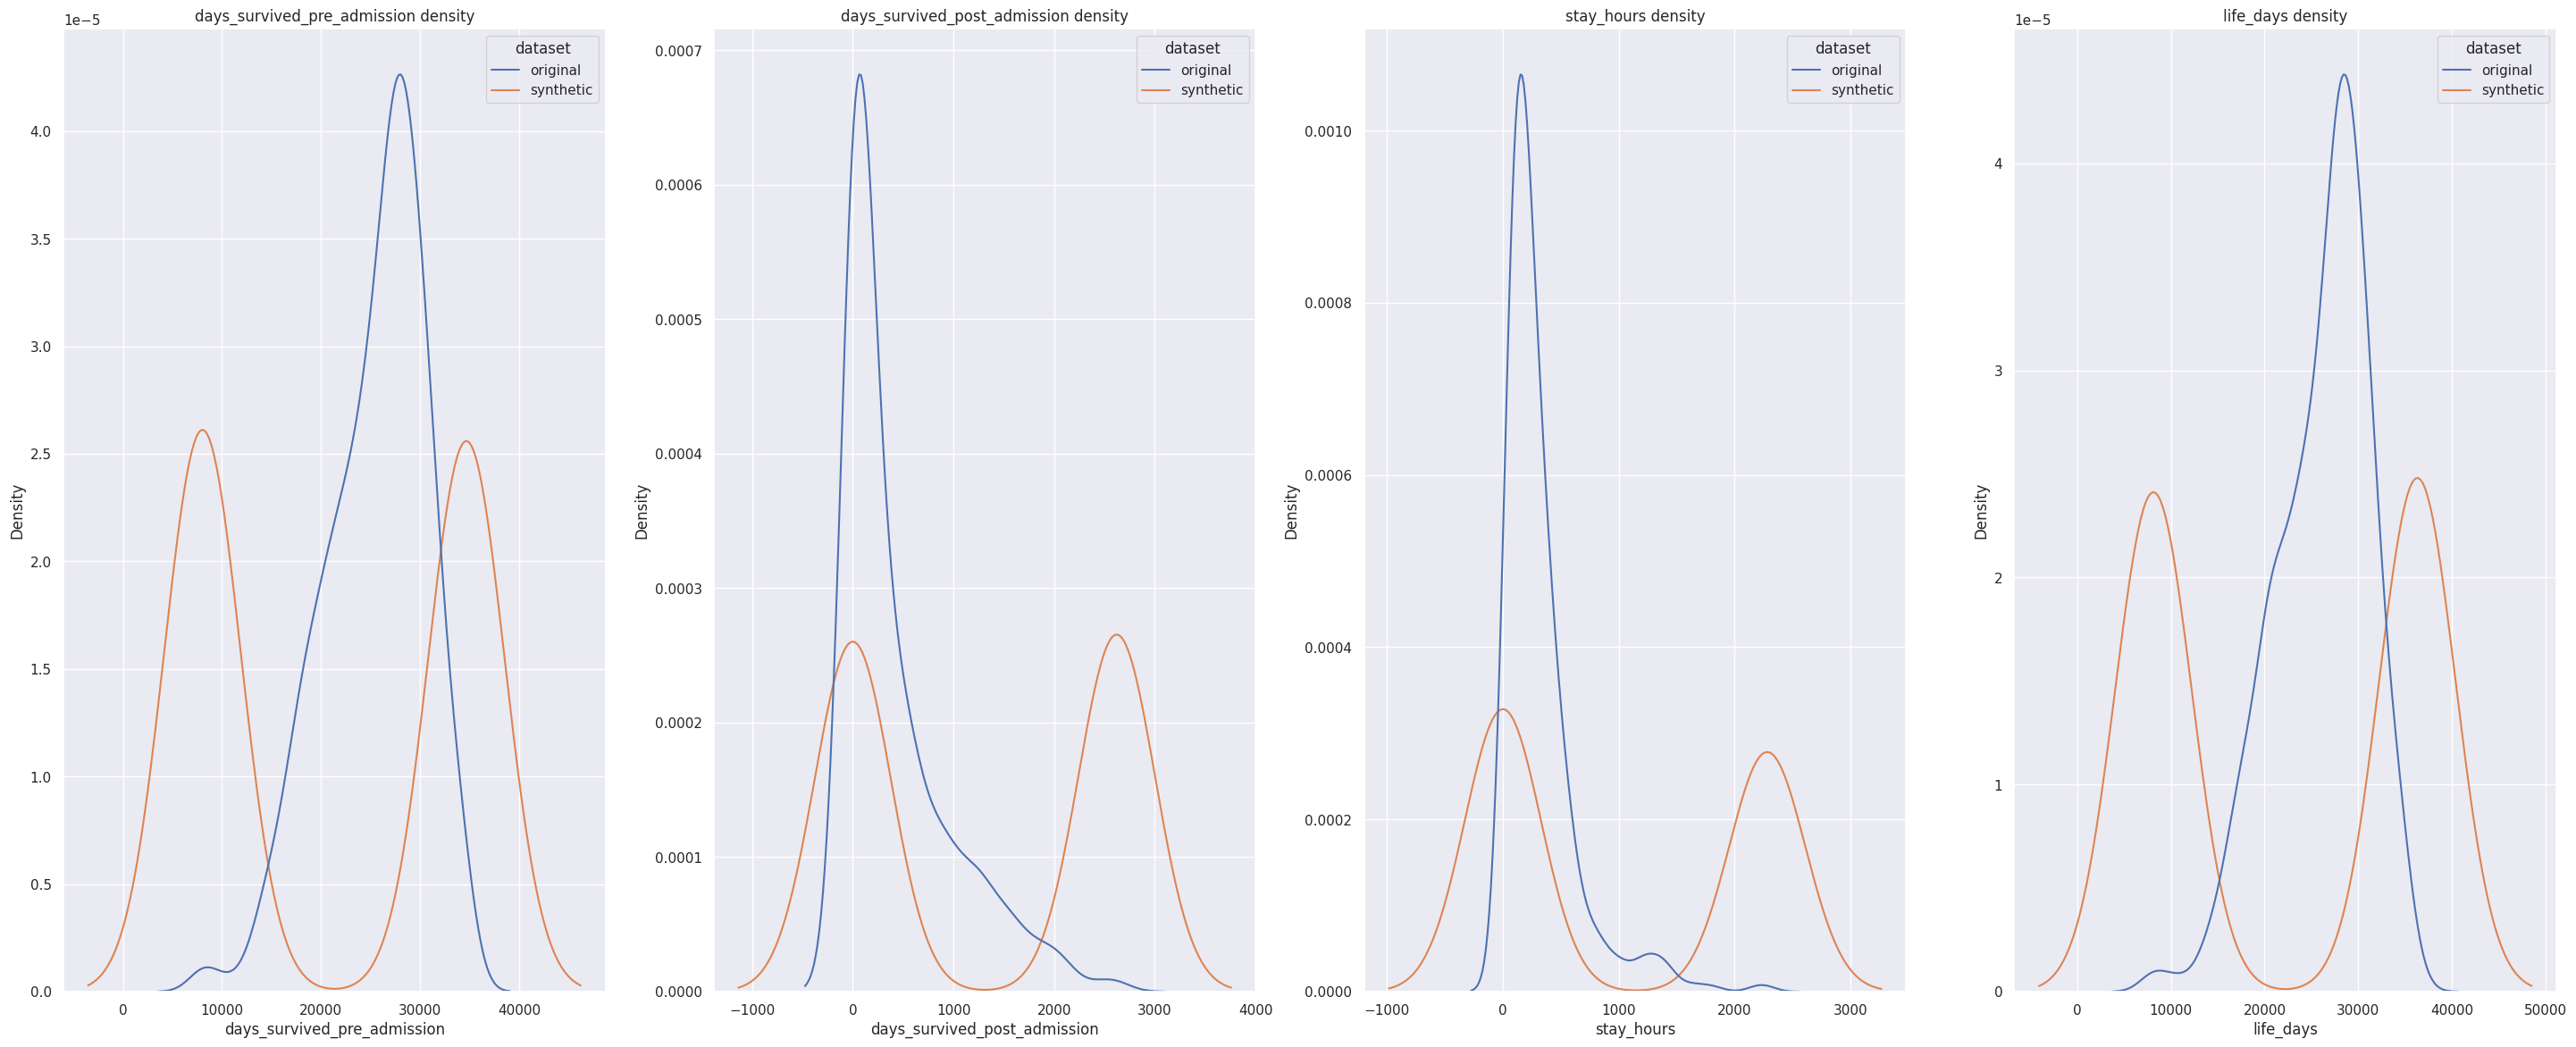

categorical pdfs for model 5 (underneath):


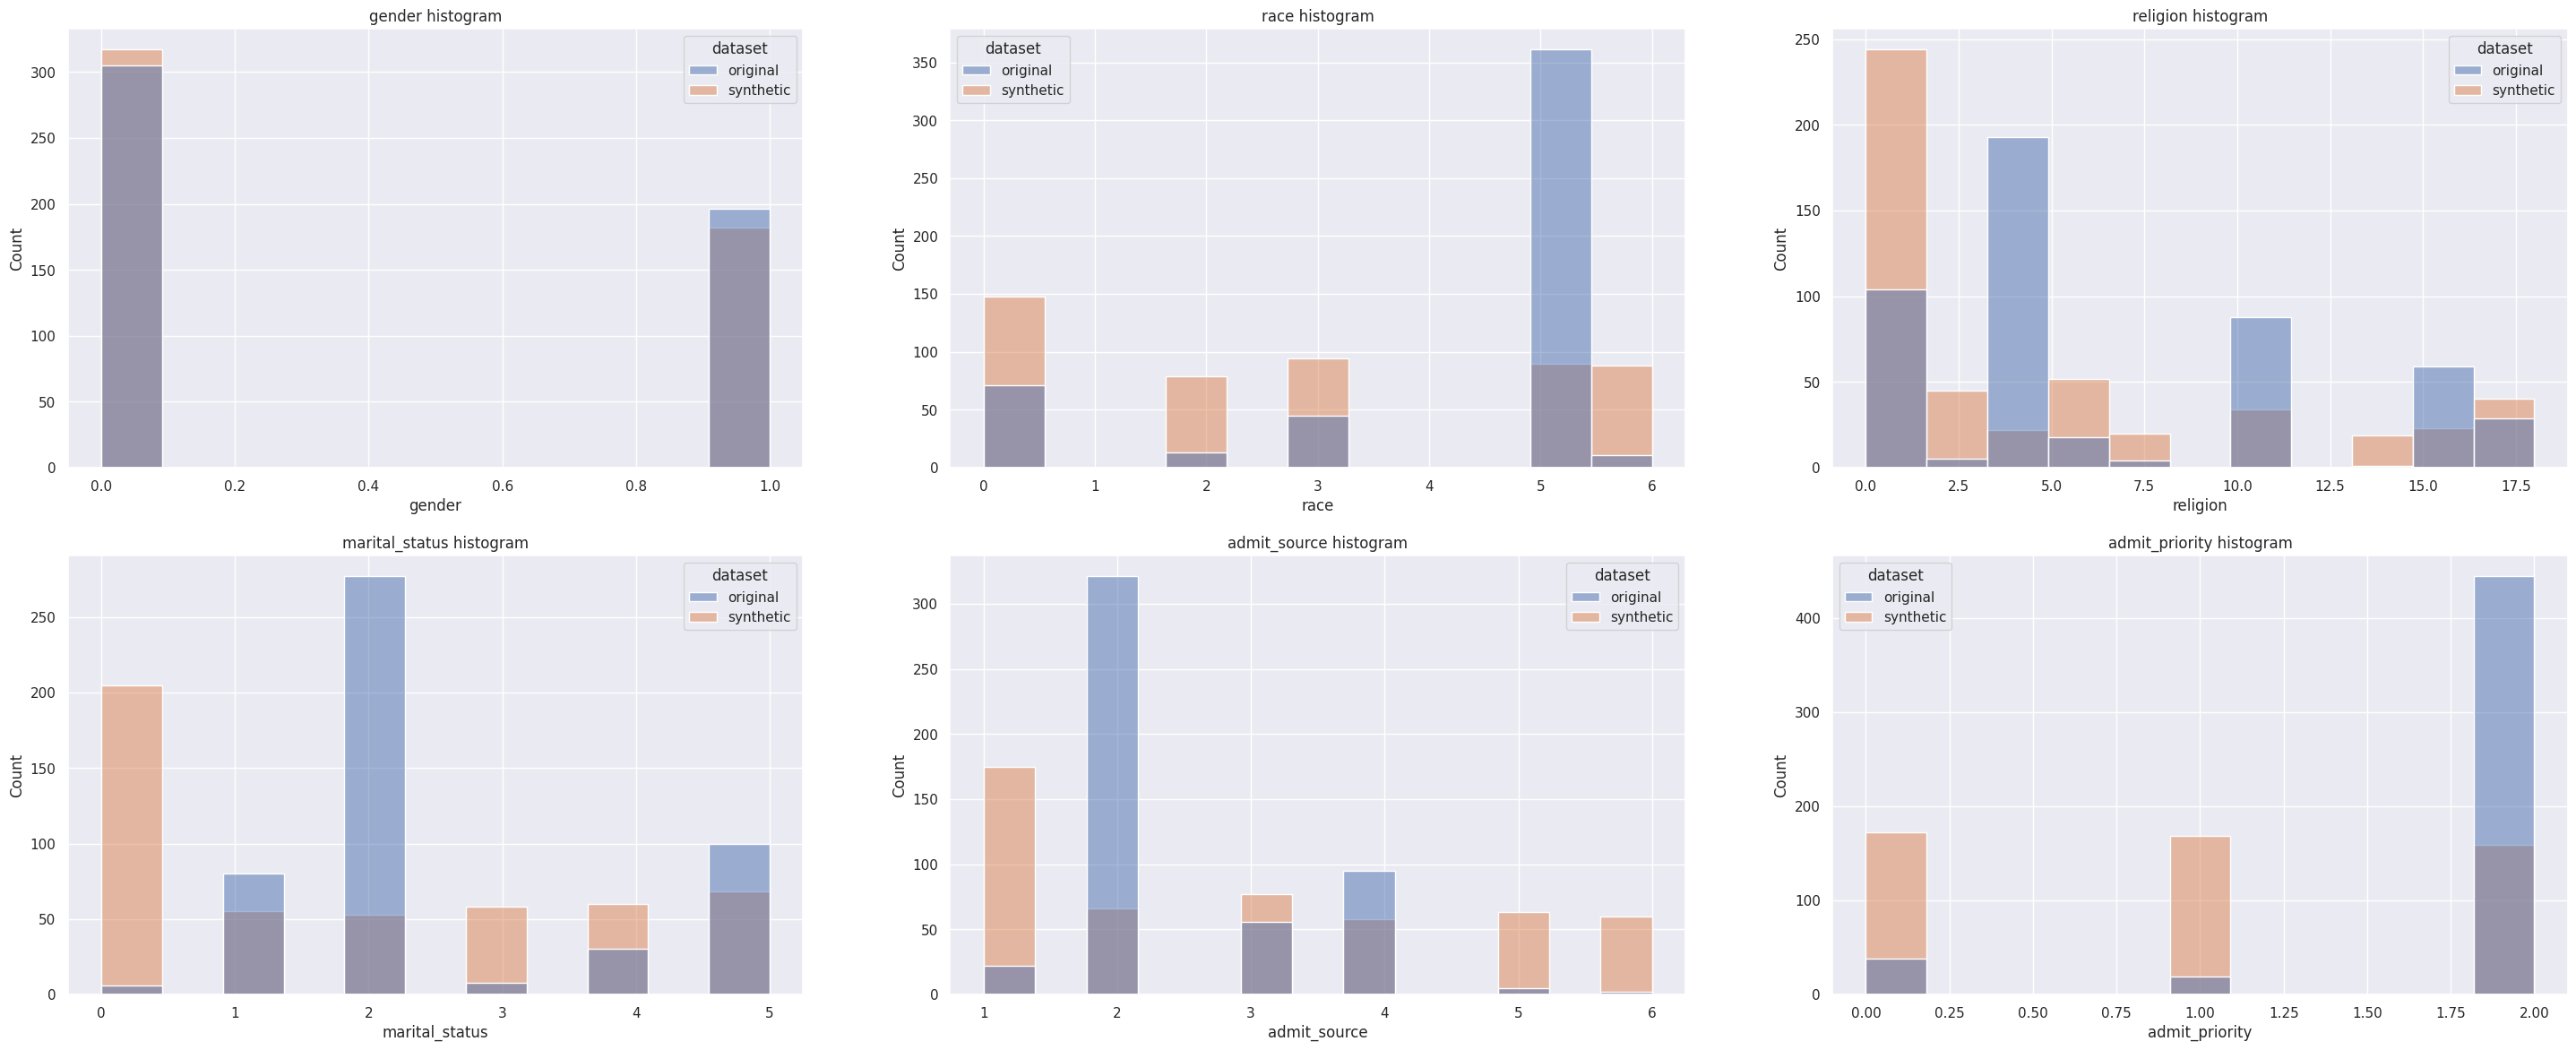

The program has been running for 2635.9887540340424 seconds
we loop


In [28]:
# @title Looping Through Models

TIME_STEP = 10000
SAMPLE_SIZE = 500

model_params = [model_params1, model_params2, model_params3, model_params4, model_params5]
model_count = 1
absolute_diff_sum_array= []
total_params_array = []


for model_param in model_params:
  # if model_count >=2:
  #   break

  if model_param["type"] == "resnet":
    print("we're doing resnet")
    model = ResNetDiffusion(**model_param)
  else:
    print("we're doing mlp")
    model = MLPDiffusion(**model_param)

  model.to(device)


  print(f"Running model{model_count}....")
  print(f"Running model{model_count}....")
  print(f"Running model{model_count}....")
  

  pytorch_total_params = sum(p.numel() for p in model.parameters())
  print('Number of trainable parameters: ', pytorch_total_params)
  total_params_array.append(pytorch_total_params)
  

  diffusion = train_model_cell(TIME_STEP)    # argument is time step, with deafault being 10000
  plotting_loss_cell(diffusion)
  sample_df = sample_model_cell(diffusion, SAMPLE_SIZE)   # argument is number of synthetic samples, with default being 500
  old_new_data = reverse_transformations_cell(sample_df)


  print(f"plotting matrices for model {model_count} (underneath):")
  my_sum = plotting_matrices_cell(old_new_data[0], old_new_data[1])
  absolute_diff_sum_array.append(my_sum)

  print(f"lab pdfs for model {model_count} (underneath):")
  plot_pdf_num_cell(old_new_data[0], old_new_data[1])

  print(f"numerical patient stay pdfs for model {model_count} (underneath):")
  plot_pdf_num_cell2(old_new_data[0], old_new_data[1])


  print(f"categorical pdfs for model {model_count} (underneath):")
  plot_pdf_cat_cell(old_new_data[0], old_new_data[1])
  measure_time_cell()
  # reporting_statistics_cell(old_new_data[0], old_new_data[1])

  model_count +=1 

print("we loop")




In [29]:
# new_data1 = old_new_data[0].iloc[:, : 14]
# new_numpy1 = new_data1.to_numpy()

# new_data2 = old_new_data[1].iloc[:, : 14]
# new_numpy2 = new_data2.to_numpy()


mu, sigma, synthetic = reporting_statistics_cell(old_new_data[0], old_new_data[1])
print(mu)
print()
print(sigma)


index=["days_survived_pre_admission", "days_survived_post_admission", 
            "stay_hours", "life_days", "anion_gap", "glucose", "chloride",
            "total_co2", "ph", "urea", "creatinine", "sodium", "potassium", "hematocrit"],

# naive_method(old_new_data[0], old_new_data[1], SAMPLE_SIZE)
df_random = pd.DataFrame()

id_col = 0
for mean, std in zip(mu,sigma):
  s = np.random.normal(mean, std, SAMPLE_SIZE)
  df_random[id_col]=s
  id_col += 1
df_random



[2.55427000e+04 4.20634000e+02 3.13920000e+02 2.61449540e+04
 1.55334203e+01 1.51129677e+02 1.03407101e+02 2.40578100e+01
 7.37490656e+00 3.32887619e+01 1.69521781e+00 1.38563176e+02
 4.34155434e+00 3.35175485e+01]

[5.04444790e+03 5.40075413e+02 3.17114026e+02 5.00141637e+03
 3.68490574e+00 7.42855478e+01 6.63529389e+00 5.30275049e+00
 6.31871038e-02 2.39119304e+01 1.48126207e+00 5.34712206e+00
 8.34811469e-01 5.82166000e+00]


0            1           2             3          4   \
0    29018.456482   515.565853   19.537082  27423.593307  17.761545   
1    24849.402324  1496.464382 -458.194840  22749.409814  13.252740   
2    22890.971283  1303.771765 -436.948101  31634.839092   9.665476   
3    19741.708034 -1012.973144  585.968083  22159.178400  17.979388   
4    28490.466522  1055.087805  452.727001  17415.392848  13.636678   
..            ...          ...         ...           ...        ...   
495  27377.960994   -86.253510  847.312137  14265.509425  20.271861   
496  39209.379755  -442.941184  547.825178  20508.580590  14.760330   
497  30277.223083   123.785512  800.916871  28041.901231  19.213387   
498  27651.897374   398.129241  291.949118  17201.813411  15.098765   
499  22503.535105  -383.429561  354.241580  22335.109875  12.980009   

             5           6          7         8          9         10  \
0    224.322716  107.081894  29.190751  7.284860  58.482742  0.300905   
1    110.858373   93.539932  22.204792  7.454895  62.783043  0.840728   
2    177.088186   98.441994  30.655803  7.327560  33.879042  1.112328   
3    203.698349  106.354139  25.151156  7.445864  59.773154  1.164265   
4    107.483224  107.220366  28.007271  7.309294  46.010740  2.989923   
..          ...         ...        ...       ...        ...       ...   
495  157.037452   94.670187  16.659247  7.461183  43.288588  0.473029   
496  210.875338  101.063034  17.376254  7.430776   4.560649  0.374570   
497   85.735551   97.133228  21.434546  7.396910  51.023634  1.672095   
498  143.401047   93.687347  18.206054  7.467026  49.914783  0.108685   
499   63.333417   94.347684  20.365716  7.253027  12.055827 -0.870596   

             11        12         13  
0    144.945968  5.230906  35.980894  
1    134.685850  3.542697  34.275371  
2    131.438252  5.368349  30.109286  
3    138.753964  4.562814  29.052819  
4    132.592238  3.650539  29.899737  
..          ...       ...        ...  
495  144.328329  3.739792  32.767741  
496  133.602966  4.368727  29.927660  
497  140.977282  4.145621  29.391466  
498  145.160383  5.948769  33.149403  
499  135.426670  5.111367  30.132620  

[500 rows x 14 columns]

In [30]:
synthetic


days_survived_pre_admission  days_survived_post_admission  stay_hours  \
0                         8030.0                        2621.0         0.0   
1                         8030.0                           0.0      2280.0   
2                         8030.0                           0.0      2280.0   
3                        34675.0                        2621.0         0.0   
4                         8030.0                           0.0      2280.0   
..                           ...                           ...         ...   
495                       8030.0                           0.0         0.0   
496                      34675.0                        2621.0      2280.0   
497                       8030.0                           0.0      2280.0   
498                       8030.0                        2621.0         0.0   
499                       8030.0                           0.0         0.0   

     life_days  anion_gap     glucose    chloride  total_co2        ph  \
0       8139.0  42.998981  706.942932   76.004021   7.000585  7.030047   
1      36302.0  42.998981   35.076935   76.004021  52.000744  7.539795   
2      36302.0  42.998981   35.076935   76.004021  52.000744  7.539795   
3      36302.0  42.998981   35.076935  128.993759  52.000744  7.539795   
4      36302.0  42.998981  706.942932   76.004021   7.000585  7.030047   
..         ...        ...         ...         ...        ...       ...   
495    36302.0  42.998981  706.942932   76.004021   7.000585  7.539795   
496     8139.0  42.998981   35.076935  128.993759   7.000585  7.539795   
497    36302.0   4.906548  706.942932  128.993759   7.000585  7.030047   
498    36302.0   4.906548  706.942932   76.004021   7.000585  7.030047   
499     8139.0  42.998981   35.076935  128.993759  52.000744  7.539795   

           urea  creatinine      sodium  potassium  hematocrit  
0    183.946396    0.300237  164.999649   2.401534   57.796185  
1    183.946396    0.300237  114.004227   2.401534    9.507229  
2     -7.934851    0.300237  164.999649   2.401534    9.507229  
3     -7.934851    0.300237  114.004227   9.999525    9.507229  
4     -7.934851   10.395617  114.004227   9.999525   57.796185  
..          ...         ...         ...        ...         ...  
495  183.946396   10.395617  164.999649   2.401534    9.507229  
496  183.946396    0.300237  114.004227   2.401534   57.796185  
497  183.946396    0.300237  114.004227   2.401534   57.796185  
498  183.946396   10.395617  114.004227   2.401534   57.796185  
499   -7.934851    0.300237  164.999649   2.401534   57.796185  

[500 rows x 14 columns]

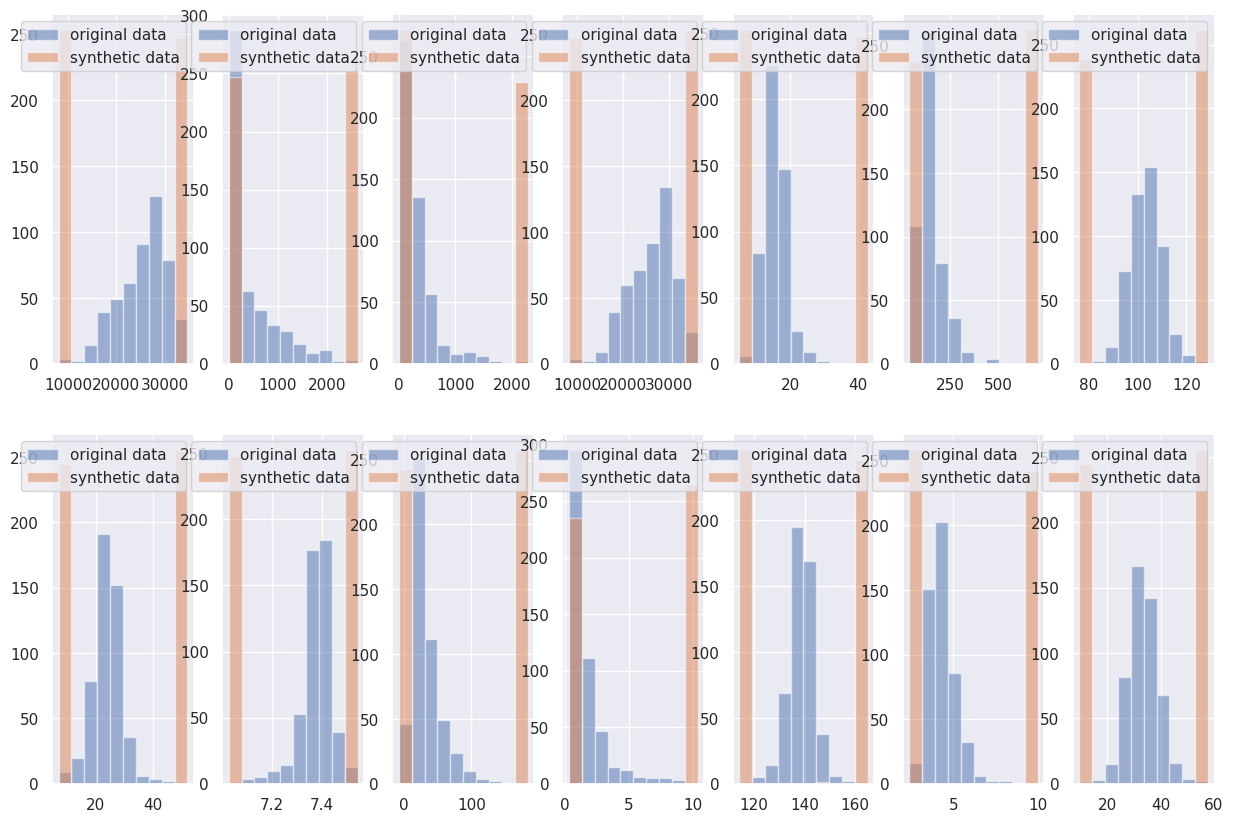

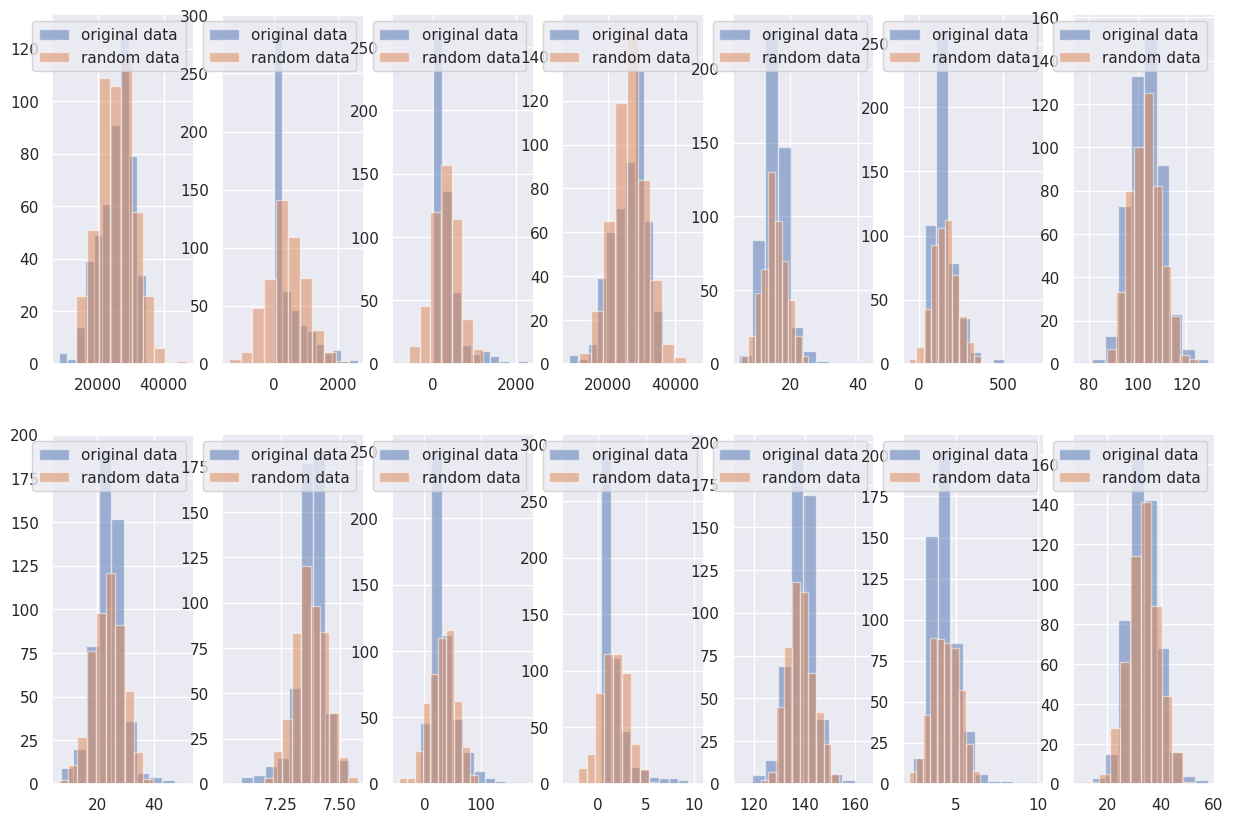

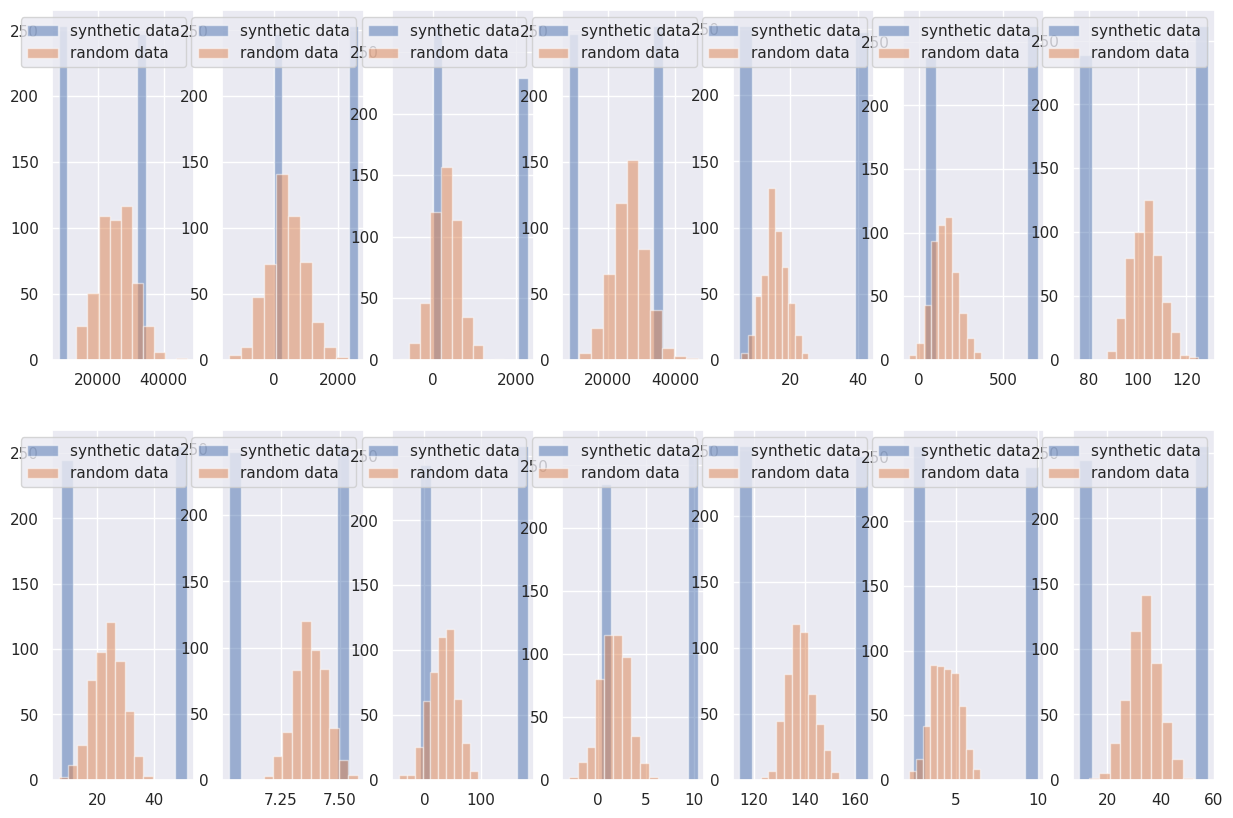

In [31]:
from matplotlib import pyplot as plt


def plot(df1, df2, row, column):

  fig, a = plt.subplots(row, column, figsize=(15, 10))
  
  a = a.ravel()

  column = 0
  for idx,ax in enumerate(a):
    
    ax.hist(df1[0].iloc[:, column].to_numpy(), alpha = 0.5, label=df1[1] )
    # ax.hist(df_random.iloc[:, column].to_numpy(), alpha = 0.5, label="random sampling")
    ax.hist(df2[0].iloc[:, column].to_numpy(), alpha = 0.5, label=df2[1])
    ax.legend()
    

    column += 1

original = (old_new_data[0], "original data")
synthetic = (synthetic, "synthetic data")
random = (df_random, "random data")

plot(original, synthetic, 2, 7)
plot(original, random, 2, 7)
plot(synthetic, random, 2, 7)


# plt.tight_layout()
 
  #plt.pyplot.hist(df_random[])
  #plt.pyplot.hist(synthetic)

# df_random.hist()
# synthetic.hist()

In [32]:
absolute_diff_sum_array

def duplicate_n_times(element, n):
  result = []
  for i in range(n):
    result.append(element)
  return result



from tabulate import tabulate

info = {"": ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"],
        "sum": absolute_diff_sum_array,
        "number of parameters": total_params_array,
        "number of training steps": duplicate_n_times(TIME_STEP, len(model_params)),
        "number of samples generated": duplicate_n_times(SAMPLE_SIZE, len(model_params))
}
print(tabulate(info, headers='keys', tablefmt="fancy_grid"))


╒═════════╤══════════════════════════════════════════╤════════════════════════╤════════════════════════════╤═══════════════════════════════╕
│         │ sum                                      │   number of parameters │   number of training steps │   number of samples generated │
╞═════════╪══════════════════════════════════════════╪════════════════════════╪════════════════════════════╪═══════════════════════════════╡
│ Model 1 │ (7.372521270458748, 4.010785940624946)   │                 178052 │                      10000 │                           500 │
├─────────┼──────────────────────────────────────────┼────────────────────────┼────────────────────────────┼───────────────────────────────┤
│ Model 2 │ (9.140166548310727, 3.736302389657707)   │                 178052 │                      10000 │                           500 │
├─────────┼──────────────────────────────────────────┼────────────────────────┼────────────────────────────┼───────────────────────────────┤
│ Model 3 │ (